# Ad Campaign Recommender
---

## Problem Statement
 The goal is to predict user demographics (age and gender) based on app usage behavior, phone brand, and event data to recommend personalized ad campaigns.

## Load Libraries

In [1]:
# Import necessary libraries for data manipulation, analysis, and visualization
import pandas as pd  # Pandas is used for data manipulation and analysis; it provides data structures like DataFrame.
import numpy as np   # NumPy is used for numerical operations and working with arrays.

# Import libraries for statistical data visualization
import seaborn as sns  # Seaborn is a Python data visualization library based on Matplotlib that provides a high-level interface for drawing attractive and informative statistical graphics.
import matplotlib.pyplot as plt  # Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.

# Import libraries related to geographical mapping
import csv  # CSV module allows reading from and writing to CSV files, which are commonly used for storing tabular data.
from mpl_toolkits.basemap import Basemap  # Basemap toolkit allows the creation of static maps with various projections; it is an extension for Matplotlib.

# Import serialization and additional machine learning algorithms
import joblib
from sklearn.cluster import MiniBatchKMeans  # MiniBatchKMeans is a variant of K-means clustering with reduced computation cost using mini-batches.

# Import XGBoost library for gradient boosting framework
import xgboost as xgb

# Additional imports for visualization and machine learning pipelines
from matplotlib.ticker import FuncFormatter  # Allows customization of tick labels on Matplotlib plots.
from sklearn.decomposition import NMF  # Non-negative Matrix Factorization is a group of algorithms in multivariate analysis and linear algebra.

# Import tools for splitting datasets and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV  # Tools for splitting data into training/testing sets and hyperparameter tuning via grid search.
from sklearn.preprocessing import StandardScaler, LabelEncoder  # LabelEncoder encodes categorical labels as integers.

# Import various machine learning classifiers
from sklearn.linear_model import LogisticRegression  # Logistic Regression is used for binary classification tasks.
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier is an ensemble method based on multiple decision trees.
from vecstack import stacking  # Stacking utility from the vecstack library, which provides a way to stack models in machine learning pipelines.

# Import XGBoost classifier and evaluation metrics
from xgboost import XGBClassifier  # XGBoost (Extreme Gradient Boosting) is an optimized distributed gradient boosting library.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Metrics for evaluating the performance of classification models.
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay  # Tools to display and analyze the performance of classification models.

# Import metrics related to ROC curve and AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc  # Functions to compute Area Under the Curve (AUC) for Receiver Operating Characteristic (ROC) curves.

# Import tools for handling class imbalance in datasets
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique helps handle imbalanced datasets by oversampling the minority class.
from imblearn.pipeline import make_pipeline  # Pipeline constructor from imbalanced-learn to integrate resampling with model training.

# Import StackingClassifier for ensemble learning
from mlxtend.classifier import StackingClassifier

# Disable warnings to clean up output; generally used when warnings are expected but deemed non-critical.
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings to avoid clutter in the console/output.

# The `pickle` module is used for serializing and de-serializing Python object structures.
import pickle

## Load Functions

### Format Numbers as per Indian numbering system

In [2]:
# Function to format number according to Indian numbering system
def indian_number_format(x, pos):
    """
    Converts a numerical value to a string representation using the Indian numbering system.

    Parameters:
    x (float or int): The number to be formatted.
    pos (int): The position of the tick label on the axis (not used).

    Returns:
    str: The formatted string with the appropriate suffix (Cr, L, K) or the original number.
    """

    # Check if x is greater than or equal to one crore (10 million)
    if x >= 1e7:
        # If the result has a fractional part, format it with one decimal place followed by 'Cr'
        return '{:.1f}Cr'.format(x*1e-7) if x*1e-7 % 1 else '{:.0f}Cr'.format(x*1e-7)

    # Check if x is greater than or equal to one lakh (100 thousand)
    elif x >= 1e5:
        # If the result has a fractional part, format it with one decimal place followed by 'L'
        return '{:.1f}L'.format(x*1e-5) if x*1e-5 % 1 else '{:.0f}L'.format(x*1e-5)

    # Check if x is greater than or equal to one thousand
    elif x >= 1e3:
        # If the result has a fractional part, format it with one decimal place followed by 'K'
        return '{:.1f}K'.format(x*1e-3) if x*1e-3 % 1 else '{:.0f}K'.format(x*1e-3)

    else:
        # Return the number as an integer if it's less than one thousand
        return int(x)

### Create Count Plot

In [3]:
def count_plot(df, col, rotate_label=False, rotate_plot=False, fig_size=(20, 7)):
    """
    Create a count plot for a given column in the DataFrame.
    :param df: The input DataFrame.
    :param col: The name of the column to be plotted.
    :param rotate_label: Whether to rotate the x-axis labels. Default is False
    :param rotate_plot: Whether to rotate the plot itself. Default is False.
    :param fig_size: Size of the plot. Default is (20, 7).
    :return: Count plot for a given column in the DataFrame.
    """


    if rotate_plot:
        # Create a figure with a larger height for a vertical plot
        plt.figure(figsize=(20, 20)) # Increase the height for a vertical plot
        ax = sns.countplot(data=df, y=col, hue=col, palette='husl', saturation=1, dodge=False, order=df[col].value_counts().index)

        # Format y-axis labels to include commas
        formatter = FuncFormatter(indian_number_format)
        plt.gca().xaxis.set_major_formatter(formatter)

    else:
        # Create a figure with a smaller height for a horizontal plot
        plt.figure(figsize=fig_size)
        ax = sns.countplot(data=df, x=col, hue=col, palette='husl', saturation=1, dodge=False, order=df[col].value_counts().index)

        # Format y-axis labels to include commas
        formatter = FuncFormatter(indian_number_format)
        plt.gca().yaxis.set_major_formatter(formatter)

    # Show the X-axis title and hide the Y-axis title
    plt.xlabel(f'\n{col}', fontsize=14, fontweight='bold')
    plt.ylabel('')

    # Increase the size of the ticks
    plt.tick_params(labelsize=14)

    # Rotate only the x ticks
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90 if rotate_label else 0)

    # Get the total count of the column
    total = df[col].count()

    # Annotate the bars with fmt from matplotlib v3.7.0
    for container in ax.containers:
        ax.bar_label(container, fmt=lambda x: f'{(x/total)*100:0.1f}%', label_type='edge', fontsize=14, color='black')

    # Add space at the end of the bar for the labels
    ax.margins(x=0.1)

    # Provide a Title
    plt.title(f'Distribution of {col}', fontsize=16, fontweight='bold', pad=15)

    return plt.show()

### Create Barplot

In [4]:
def create_bar_plot(df, y_axis, subtitle=None):
    """
    Create a bar plot for a given column in the DataFrame.
    :param df: The DataFrame containing data.
    :param y_axis: The column of the DataFrame to be plotted on y-axis.
    :param subtitle: An optional parameter for providing a subtitle to the plot.
    :return: Displays the bar plot and returns Matplotlib figure object if needed for further manipulations.
    """

    # Set figure size and style for plotting
    plt.figure(figsize=(20, 7))
    ax = sns.barplot(data=df, x='Month', y=y_axis, errorbar=None, palette='husl', hue='Month', estimator='sum')

    # Format y-axis labels to include commas
    formatter = FuncFormatter(indian_number_format)
    plt.gca().yaxis.set_major_formatter(formatter)

    # Show the X-axis title and hide the Y-axis title
    plt.xlabel('\nMonth', fontsize=14, fontweight='bold')
    plt.ylabel('')

    # Increase the size of the ticks
    plt.tick_params(labelsize=14)

    # Add space at the end of the bar for the labels
    ax.margins(x=0.1)

    # Annotate the bars with fmt from matplotlib v3.7.0
    for container in ax.containers:
        ax.bar_label(container, fmt=lambda x: f'{indian_number_format(x, None)} ({round(x, 2)})' if x > 999999 else f'{indian_number_format(x, None)}', label_type='edge', fontsize=14, color='black', padding=5)

    # Provide a Title
    plt.title(f'Performance of {y_axis} ({subtitle})', fontsize=16, fontweight='bold', pad=20)

    # Hide Gridlines
    plt.grid(False)

    # Hide top border
    ax.spines['top'].set_visible(False)

    # Hide border to the right
    ax.spines['right'].set_visible(False)

    # Return the plot when finished
    return plt.show()

### Plot Heatmap

In [5]:
def create_heatmap(df, fig_size=(20, 7)):
    """
    This function creates a heatmap to visualize the correlation matrix of a given DataFrame.

    :param df: The DataFrame containing data.
    :param fig_size: An optional parameter for setting figure size. Default value is (20, 7).
    :return: Displays the heatmap and returns Matplotlib figure object if needed for further manipulations.
    """

    # Set figure size and create a figure object
    plt.figure(figsize=fig_size)

    # Create a heatmap using seaborn's heatmap function
    sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)

    # Return the figure object for further manipulation if needed
    return plt.show()

### Create BoxPlot

In [6]:
def create_boxplot(df, axis):
    plt.figure(figsize=(20, 7))
    ax = sns.boxplot(data=df, x=axis)

    # Increase the size of the ticks
    plt.tick_params(labelsize=14)

    # Provide a Title
    plt.title(f'Distribution of {axis}', fontsize=16, fontweight='bold', pad=20)

     # Hide Gridlines
    plt.grid(False)

    # Show the X-axis title and hide the Y-axis title
    plt.xlabel(axis, fontsize=14, fontweight='bold')

    return plt.show()

### Apply SMOTE

In [7]:
def apply_smote(df, pred_variable):
    """
    Applies SMOTE (Synthetic Minority Over-sampling Technique) to balance the classes in a dataset.

    :param df: A pandas DataFrame containing the dataset. The DataFrame should have columns representing features
               and one column for the prediction variable.
    :type df: pd.DataFrame

    :param pred_variable: The name of the column in 'df' that contains the target variable (the class labels).
                          This is the variable for which we want to balance the classes.
    :type pred_variable: str

    :return: A new pandas DataFrame with the same features as the input but with balanced class distribution
             achieved by oversampling the minority class using SMOTE.

    """

    X = df.drop(columns=[pred_variable])                        # Separating feature columns from the target column; 'X' now contains only
                                                                # the independent variables (features) of the dataset.
    y = df[pred_variable]                                       # Extracting the target variable (the prediction variable) into a separate Series, 'y'.

    # Initializing SMOTE with an automatic sampling strategy and a fixed random state for reproducibility.
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Applying SMOTE to resample the data. This step synthesizes new examples in the minority class
    # based on feature space similarities, resulting in a balanced dataset.
    X_resampled, y_resampled = smote.fit_resample(X, y)         # 'fit_resample' both fits the SMOTE model and resamples the data.

    # Concatenating the resampled features with the resampled target variable to form a new DataFrame
    # that has balanced classes.
    return pd.concat([X_resampled, y_resampled], axis=1)        # Returns the new DataFrame with balanced classes.

### Plot Confusion Matrix

In [8]:
def plot_confusion_matrix_stacked(stacking_model, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Plot a stacked confusion matrix for the given stacking model.

    :param stacking_model: The fitted stacking model used to make predictions. (estimator)
    :param X_test: Features of the test dataset. (pd.DataFrame)
    :param y_test: True labels of the test dataset. (pd.Series)
    :return: None
    """

    # Create figure with a specified size for better visibility
    plt.figure(figsize=(20, 7))

    # Make predictions on the test dataset using the provided stacking model
    y_pred = stacking_model.predict(X_test)

    # Compute the confusion matrix by comparing true labels (y_test) and predicted labels (y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Create an instance of ConfusionMatrixDisplay to visualize the computed confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot the confusion matrix using a specified colormap ('YlGnBu' for yellow-green-blue gradient)
    disp.plot(cmap='YlGnBu')

    # Add descriptive title and axis labels for clarity in the plot
    plt.title('Confusion Matrix for Stacking Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Display the plot to show the confusion matrix visually
    plt.show()

### Plot ROC Curve

In [9]:
def plot_roc_curve_stacked(stacking_model, X_test: pd.DataFrame, y_test: pd.Series) -> None:
    """
    Plots the ROC curve for each class of a stacking model.

    This function calculates and plots the Receiver Operating Characteristic (ROC)
    curves for each class in a multi-class classification problem using a provided
    stacking model. It also computes and displays the Area Under the Curve (AUC)
    score for each class's ROC curve.

    :param stacking_model: The trained stacking model with a predict_proba method.
                           This should be able to provide probability estimates for
                           each class in a multi-class classification problem.
    :param X_test: A pandas DataFrame containing the test dataset features. The input
                   data used by the model to make predictions.
    :param y_test: A pandas Series containing the true labels of the test dataset.
                   These are the actual class labels for the samples in X_test.
    :return: None
    """

    # Determine the number of unique classes in the target variable
    n_classes = len(np.unique(y_test))

    # Create a figure and axis object with specified size
    fig, ax = plt.subplots(figsize=(20, 7))

    # Loop over each class to compute and plot its ROC curve
    for i in range(n_classes):
        # Compute the false positive rate (fpr), true positive rate (tpr),
        # and thresholds for the current class using roc_curve function.
        fpr, tpr, _ = roc_curve(y_test == i, stacking_model.predict_proba(X_test)[:, i])

        # Calculate the Area Under the Curve (AUC) score for the ROC curve
        auc_score = auc(fpr, tpr)

        # Plot the ROC curve with a label that includes class number and AUC score
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (area = {auc_score:.2f})')

    # Plot the diagonal line representing random chance
    plt.plot([0, 1], [0, 1], 'k--')

    # Set the limits for the x-axis and y-axis
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    # Label the axes
    plt.xlabel('False Positive Rate')

    # Label the y-axis as True Positive Rate
    plt.ylabel('True Positive Rate')

    # Add a title to the plot
    plt.title('ROC Curve for Stacking Model')

    # Add a legend in the lower right corner with labels for each class's ROC curve
    plt.legend(loc="lower right")

    # Display the plot on screen
    plt.show()

## Load Data

### App Events

In [10]:
# Read data from a CSV file named 'app_events.csv' located in the 'CSV files' directory
# This will load the data into a Pandas DataFrame called `app_events`.
app_events = pd.read_csv('CSV files/app_events.csv')

In [11]:
# Display the first 5 rows of the 'app_events' DataFrame to get a quick overview of its structure.
app_events.head()

event_id               app_id  is_installed  is_active
0         2  5927333115845830913             1          1
1         2 -5720078949152207372             1          0
2         2 -1633887856876571208             1          0
3         2  -653184325010919369             1          1
4         2  8693964245073640147             1          1

In [12]:
# Use the .info() method on the 'app_events' DataFrame to get concise information about it,
# including the number of non-null entries in each column, and data types.
app_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


### App Events Metadata

In [13]:
# Read the CSV file 'app_events_meta_data.csv' from the 'CSV files' directory into a DataFrame.
# The parameters specify additional options for reading:
# - `quoting=csv.QUOTE_NONE`: Indicates that no special interpretation should be given to quote characters in the CSV, treating them as regular text.
# - `low_memory=False`: Prevents pandas from trying to save memory by parsing the file in chunks, which can lead to inconsistent data type determination; this is important for large datasets or when exact column types are needed.
# - `header=1`: Specifies that the second row (index 1) should be used as the header for columns rather than the first one.
app_events_metadata = pd.read_csv('CSV files/app_events_meta_data.csv', quoting=csv.QUOTE_NONE, low_memory=False, header=1)

In [14]:
# Display the first 5 rows of 'app_events_metadata' to provide an initial look at its structure and contents.
app_events_metadata.head()

app_id  label_id         category
0  7324884708820027918       251          Finance
1 -4494216993218550286       251          Finance
2  6058196446775239644       406          unknown
3  6058196446775239644       407  DS_P2P net loan
4  8694625920731541625       406          unknown

In [15]:
# Use the .info() method on 'app_events_metadata' to get a summary of the DataFrame,
# including details like number of non-null entries per column, data types, etc.
app_events_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   app_id    459943 non-null  int64 
 1   label_id  459943 non-null  int64 
 2   category  459943 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.5+ MB


### Train Event Data

In [16]:
# Load the 'train_event_data.csv' file into a DataFrame named `train_event_data`.
# The CSV file is expected to be located in the 'CSV files' directory.
train_event_data = pd.read_csv('CSV files/train_event_data.csv')

In [17]:
# Convert the 'datetimestamp' column from its current format into pandas datetime objects.
# The parameter `dayfirst=False` specifies that day-month-year order should not be assumed,
# which means it defaults to year-month-day ordering unless specified otherwise by the data format.
train_event_data['datetimestamp'] = pd.to_datetime(train_event_data['datetimestamp'], dayfirst=False)

In [18]:
# Display the first 5 rows of 'train_event_data' DataFrame, providing a snapshot
# of its structure and sample content for quick inspection.
train_event_data.head()

device_id gender  age group_train   event_id       datetimestamp  \
0 -7548291590301750000      M   33        M32+  2369465.0 2016-05-03 15:55:35   
1 -7548291590301750000      M   33        M32+  1080869.0 2016-05-03 06:07:16   
2 -7548291590301750000      M   33        M32+  1079338.0 2016-05-04 03:28:02   
3 -7548291590301750000      M   33        M32+  1078881.0 2016-05-04 02:53:08   
4 -7548291590301750000      M   33        M32+  1068711.0 2016-05-03 15:59:35   

   latitude  longitude  
0     33.98     116.79  
1     33.98     116.79  
2     33.98     116.79  
3     33.98     116.79  
4     33.98     116.79

In [19]:
# Use .info() to obtain a summary description of 'train_event_data', which includes
# information such as total number of entries, non-null counts per column, data types,
# and memory usage. This is useful for initial data exploration and validation purposes.
train_event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1266933 non-null  int64         
 1   gender         1266933 non-null  object        
 2   age            1266933 non-null  int64         
 3   group_train    1266933 non-null  object        
 4   event_id       1215598 non-null  float64       
 5   datetimestamp  1215598 non-null  datetime64[ns]
 6   latitude       1215598 non-null  float64       
 7   longitude      1215598 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 77.3+ MB


### Train Mobile Brand

In [20]:
# Load the CSV file 'train_mobile_brand.csv' into a DataFrame named `train_mobile_brand`.
# The CSV file is expected to be located in the 'CSV files' directory.
train_mobile_brand = pd.read_csv('CSV files/train_mobile_brand.csv')

In [21]:
# Display the first 5 rows of the DataFrame `train_mobile_brand` to quickly inspect
# its structure and some sample data.
train_mobile_brand.head()

device_id gender  age group_train phone_brand device_model
0 -7548291590301750000      M   33        M32+      Huawei     è£è€€3C
1  6943568600617760000      M   37        M32+      Xiaomi        xnote
2  5441349705980020000      M   40        M32+        OPPO          R7s
3 -5393876656119450000      M   33        M32+      Xiaomi         MI 4
4  4543988487649880000      M   53        M32+     samsung    Galaxy S4

In [22]:
# Use the .info() method on `train_mobile_brand` to obtain a summary description,
# which includes details such as number of entries, non-null counts per column,
# data types, and memory usage. This is useful for initial exploration and validation.
train_mobile_brand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     74840 non-null  int64 
 1   gender        74840 non-null  object
 2   age           74840 non-null  int64 
 3   group_train   74840 non-null  object
 4   phone_brand   74840 non-null  object
 5   device_model  74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


## Data Cleaning and Wrangling

### App Events

In [23]:
# Display detailed information about the 'app_events' DataFrame.
# The verbose parameter set to True will show more details such as memory usage
# and dtype for each column, which can be helpful in understanding data types and size implications.
app_events.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 4 columns):
 #   Column        Dtype
---  ------        -----
 0   event_id      int64
 1   app_id        int64
 2   is_installed  int64
 3   is_active     int64
dtypes: int64(4)
memory usage: 991.0 MB


In [24]:
# Check for null (missing) values across all columns of the 'app_events' DataFrame.
# This returns a Series with the count of non-null entries per column, allowing you to quickly identify
# columns that have missing data which might need further investigation or handling.
app_events.isnull().sum()

event_id        0
app_id          0
is_installed    0
is_active       0
dtype: int64

In [25]:
# Count occurrences of each unique value in the 'is_installed' column of 'app_events'.
# This method provides a Series where index labels are the unique values and values
# are their corresponding counts, useful for understanding distribution and spotting anomalies.
app_events['is_installed'].value_counts()

is_installed
1    32473067
Name: count, dtype: int64

In [26]:
# Calculate normalized (percentage) occurrence of each value in the 'is_active' column
# of 'app_events'. The normalization divides by the total number of observations,
# resulting in a percentage representation of occurrences. This is useful for
# understanding how frequently different states occur relative to the whole dataset.
app_events['is_active'].value_counts(normalize=True)*100

is_active
0    60.789056
1    39.210944
Name: proportion, dtype: float64

In [27]:
# Check for duplicate rows in the 'app_events' DataFrame.
# The duplicated() method returns a boolean Series indicating whether each row is a duplicate
# (i.e., has been observed in a previous row). By calling sum(), you get the total number of duplicates.
app_events.duplicated().sum()

0

In [28]:
# Randomly sample 10 rows from the 'app_events' DataFrame without replacement.
# This method returns a subset of the DataFrame, which can be useful for quick inspection
# or analysis of the data structure and content. The random sampling helps in providing
# a varied look at different parts of the dataset.
app_events.sample(10)

event_id               app_id  is_installed  is_active
15073104   1507239 -5955918336844778663             1          0
31762378   3177914  -861266404539539653             1          0
21840010   2187977 -6799509164833422300             1          0
20346263   2037090  6290203818979399510             1          0
17233716   1725494   791242420671894460             1          0
21967455   2201707 -3663244261911822034             1          1
18711383   1872935  -583654421088403436             1          0
29003875   2903506 -3060988468431536700             1          0
29764249   2981157 -6799509164833422300             1          1
8489936     850032 -6172775651801283024             1          0

### Train Event Data

In [29]:
# Get Info
train_event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266933 entries, 0 to 1266932
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1266933 non-null  int64         
 1   gender         1266933 non-null  object        
 2   age            1266933 non-null  int64         
 3   group_train    1266933 non-null  object        
 4   event_id       1215598 non-null  float64       
 5   datetimestamp  1215598 non-null  datetime64[ns]
 6   latitude       1215598 non-null  float64       
 7   longitude      1215598 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 77.3+ MB


In [30]:
# Get count of duplicates
train_event_data.duplicated().sum()

0

In [31]:
# Check for Null values
train_event_data.isnull().sum()

device_id            0
gender               0
age                  0
group_train          0
event_id         51335
datetimestamp    51335
latitude         51335
longitude        51335
dtype: int64

In [32]:
# Percentage of missing values
51335 / 1266933 * 100

4.0519111902523655

In [33]:
# Investigating missing values
train_event_data[train_event_data['event_id'].isnull()]

device_id gender  age group_train  event_id datetimestamp  \
1215595   398514470209561000      M   68        M32+       NaN           NaT   
1215596 -3073918292047050000      M   27      M25-32       NaN           NaT   
1215597  5805880616488060000      M   39        M32+       NaN           NaT   
1215598 -2403560729305410000      M   25      M25-32       NaN           NaT   
1215599 -1889893391998300000      M   22       M0-24       NaN           NaT   
...                      ...    ...  ...         ...       ...           ...   
1266928 -8270585312108800000      F   32      F25-32       NaN           NaT   
1266929  9140950698473710000      M   41        M32+       NaN           NaT   
1266930 -5051737733034250000      M   25      M25-32       NaN           NaT   
1266931 -6901678500015010000      F   20       F0-24       NaN           NaT   
1266932  6076451050607320000      M   21       M0-24       NaN           NaT   

         latitude  longitude  
1215595       NaN        NaN  
1215596       NaN        NaN  
1215597       NaN        NaN  
1215598       NaN        NaN  
1215599       NaN        NaN  
...           ...        ...  
1266928       NaN        NaN  
1266929       NaN        NaN  
1266930       NaN        NaN  
1266931       NaN        NaN  
1266932       NaN        NaN  

[51335 rows x 8 columns]

In [34]:
# Checking if the Device IDs with missing Event IDs have any previous data
device_id = train_event_data.loc[train_event_data['event_id'].isnull(), 'device_id']

train_event_data[
    ~(train_event_data['event_id'].isnull()) &              # Get data with non-blank event IDs
    (train_event_data['device_id'].isin(device_id))         # Check if any of the device IDs is present in the ones with missing event IDs
]

Empty DataFrame
Columns: [device_id, gender, age, group_train, event_id, datetimestamp, latitude, longitude]
Index: []

In [35]:
# Create dataset with no missing data
train_event_data_non_missing = train_event_data[~train_event_data['event_id'].isnull()].reset_index(drop=True).copy()

In [36]:
# Check data with missing location info
train_event_data_non_missing[
    (train_event_data_non_missing['latitude'] == 0) &
    (train_event_data_non_missing['longitude'] == 0)
]

device_id gender  age group_train   event_id  \
292      6943568600617760000      M   37        M32+  1279824.0   
293      5441349705980020000      M   40        M32+  1814584.0   
294     -5393876656119450000      M   33        M32+   534667.0   
295     -5393876656119450000      M   33        M32+  2791295.0   
296     -5393876656119450000      M   33        M32+  2124751.0   
...                      ...    ...  ...         ...        ...   
1215593  4521177520949810000      F   26      F25-32  2811648.0   
1215594  4521177520949810000      F   26      F25-32   504315.0   
1215595  7532333004539760000      M   29      M25-32   511683.0   
1215596  7532333004539760000      M   29      M25-32  1725229.0   
1215597  7532333004539760000      M   29      M25-32  1545030.0   

              datetimestamp  latitude  longitude  
292     2016-05-01 11:59:32       0.0        0.0  
293     2016-05-02 23:55:47       0.0        0.0  
294     2016-05-02 21:29:35       0.0        0.0  
295     2016-05-06 22:55:28       0.0        0.0  
296     2016-05-06 23:06:44       0.0        0.0  
...                     ...       ...        ...  
1215593 2016-05-03 19:24:54       0.0        0.0  
1215594 2016-05-05 09:43:15       0.0        0.0  
1215595 2016-05-02 18:02:21       0.0        0.0  
1215596 2016-05-02 18:07:45       0.0        0.0  
1215597 2016-05-02 18:02:37       0.0        0.0  

[356157 rows x 8 columns]

In [37]:
# Checking if the Device IDs with missing locations have any previous data
device_id = train_event_data_non_missing.loc[
    (train_event_data_non_missing['latitude'] == 0) &
    (train_event_data_non_missing['longitude'] == 0),
    'device_id'].drop_duplicates()

train_event_data_non_missing[
    (train_event_data_non_missing['latitude'] != 0) &                   # Get data with locations
    (train_event_data_non_missing['longitude'] != 0) &                  # Get data with locations
    (train_event_data_non_missing['device_id'].isin(device_id))         # Check if any of the device IDs is present in the ones with missing event IDs
]

device_id gender  age group_train   event_id  \
298      4543988487649880000      M   53        M32+  2385752.0   
299      4543988487649880000      M   53        M32+  1077652.0   
301      4543988487649880000      M   53        M32+  1001152.0   
303      4543988487649880000      M   53        M32+   973989.0   
305      4543988487649880000      M   53        M32+   880454.0   
...                      ...    ...  ...         ...        ...   
1215571  -537035954505421000      M   32      M25-32   319018.0   
1215572  -537035954505421000      M   32      M25-32   228172.0   
1215573  -537035954505421000      M   32      M25-32  3153772.0   
1215575  -537035954505421000      M   32      M25-32  3055520.0   
1215576  -537035954505421000      M   32      M25-32  2412443.0   

              datetimestamp  latitude  longitude  
298     2016-05-05 04:39:46     30.88     104.26  
299     2016-05-05 00:42:38     30.88     104.26  
301     2016-05-07 22:54:59     30.88     104.26  
303     2016-05-07 22:09:18     30.88     104.26  
305     2016-05-07 22:36:24     30.88     104.26  
...                     ...       ...        ...  
1215571 2016-05-04 20:35:01     30.74     120.72  
1215572 2016-05-02 15:03:02     30.76     120.72  
1215573 2016-05-02 14:41:27     30.76     120.72  
1215575 2016-05-04 07:41:26     30.76     120.72  
1215576 2016-05-04 20:34:53     30.79     120.69  

[646447 rows x 8 columns]

In [38]:
# Adding missing locations for device IDs with mode of the respective device IDs
try:
    # Attempt to read a pre-existing parquet file containing event data without missing values.
    train_event_data_non_missing = pd.read_parquet('train_event_data_non_missing.parquet')

except FileNotFoundError:
    # If the file does not exist, iterate over each device ID to fill in missing latitude and longitude values.
    for d_id in device_id:

        # Get the mode of latitudes for a specific device ID where latitude is non-zero.
        # The mean of the modes is taken if there are multiple modes.
        lat = train_event_data_non_missing.loc[
            (train_event_data_non_missing['device_id'] == d_id) &
            (train_event_data_non_missing['latitude'] != 0),
            'latitude'
        ].mode().mean()

        # Get the mode of longitudes for a specific device ID where longitude is non-zero.
        # The mean of the modes is taken if there are multiple modes.
        lon = train_event_data_non_missing.loc[
            (train_event_data_non_missing['device_id'] == d_id) &
            (train_event_data_non_missing['longitude'] != 0),
            'longitude'
        ].mode().mean()

        # Update the latitude values where they are currently zero for this device ID.
        train_event_data_non_missing.loc[
            (train_event_data_non_missing['device_id'] == d_id) &
            (train_event_data_non_missing['latitude'] == 0),
            'latitude'
        ] = lat

        # Update the longitude values where they are currently zero for this device ID.
        train_event_data_non_missing.loc[
            (train_event_data_non_missing['device_id'] == d_id) &
            (train_event_data_non_missing['longitude'] == 0),
            'longitude'
        ] = lon

    # Save the updated DataFrame with no missing latitudes and longitudes to a parquet file.
    train_event_data_non_missing.to_parquet('train_event_data_non_missing.parquet', index=False)

In [39]:
# Filter and retrieve rows from the DataFrame where latitude or longitude is either zero or null.
train_event_data_non_missing[
    (train_event_data_non_missing['latitude'] == 0) |               # Check if latitude is exactly zero
    (train_event_data_non_missing['longitude'] == 0) |              # Check if longitude is exactly zero
    (train_event_data_non_missing['latitude'].isnull()) |           # Check if latitude is null/NaN
    (train_event_data_non_missing['longitude'].isnull())            # Check if longitude is null/NaN
]

device_id gender  age group_train   event_id  \
292      6943568600617760000      M   37        M32+  1279824.0   
293      5441349705980020000      M   40        M32+  1814584.0   
294     -5393876656119450000      M   33        M32+   534667.0   
295     -5393876656119450000      M   33        M32+  2791295.0   
296     -5393876656119450000      M   33        M32+  2124751.0   
...                      ...    ...  ...         ...        ...   
1215593  4521177520949810000      F   26      F25-32  2811648.0   
1215594  4521177520949810000      F   26      F25-32   504315.0   
1215595  7532333004539760000      M   29      M25-32   511683.0   
1215596  7532333004539760000      M   29      M25-32  1725229.0   
1215597  7532333004539760000      M   29      M25-32  1545030.0   

              datetimestamp  latitude  longitude  
292     2016-05-01 11:59:32       NaN        NaN  
293     2016-05-02 23:55:47       NaN        NaN  
294     2016-05-02 21:29:35       NaN        NaN  
295     2016-05-06 22:55:28       NaN        NaN  
296     2016-05-06 23:06:44       NaN        NaN  
...                     ...       ...        ...  
1215593 2016-05-03 19:24:54       NaN        NaN  
1215594 2016-05-05 09:43:15       NaN        NaN  
1215595 2016-05-02 18:02:21       NaN        NaN  
1215596 2016-05-02 18:07:45       NaN        NaN  
1215597 2016-05-02 18:02:37       NaN        NaN  

[198172 rows x 8 columns]

In [40]:
# Percentage of missing location
train_event_data_non_missing['latitude'].isnull().sum() / train_event_data_non_missing.shape[0] * 100

16.301441759529055

In [41]:
# Create a copy of the DataFrame, excluding any rows where latitude or longitude is null.
event_data = train_event_data_non_missing[
    # Use bitwise NOT operator (~) to exclude rows with null values in latitude or longitude.
    ~(train_event_data_non_missing['latitude'].isnull()) &
    ~(train_event_data_non_missing['longitude'].isnull())
].copy()

# event_data now contains all records where both latitude and longitude are present (non-null).

In [42]:
# Identify rows in the DataFrame where latitude values fall outside the valid range of -90 to 90 degrees.
event_data[~event_data['latitude'].between(-90, 90)]            # Check if latitude is not within the inclusive range [-90, 90]

Empty DataFrame
Columns: [device_id, gender, age, group_train, event_id, datetimestamp, latitude, longitude]
Index: []

In [43]:
# Identify rows in the DataFrame where longitude values fall outside the valid range of -180 to 180 degrees.
event_data[~event_data['longitude'].between(-180, 180)]         # Check if longitude is not within the inclusive range [-180, 180]

Empty DataFrame
Columns: [device_id, gender, age, group_train, event_id, datetimestamp, latitude, longitude]
Index: []

In [44]:
# Get the updated dataset info
event_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017426 entries, 0 to 1215589
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   device_id      1017426 non-null  int64         
 1   gender         1017426 non-null  object        
 2   age            1017426 non-null  int64         
 3   group_train    1017426 non-null  object        
 4   event_id       1017426 non-null  float64       
 5   datetimestamp  1017426 non-null  datetime64[ns]
 6   latitude       1017426 non-null  float64       
 7   longitude      1017426 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 69.9+ MB


In [45]:
# Sample 10 random rows from the train_event_data DataFrame.
train_event_data.sample(10)

device_id gender  age group_train   event_id  \
892865  -8412643697165830000      M   25      M25-32  1009573.0   
1160962 -1319995297521480000      M   31      M25-32  2501126.0   
979233  -5652570657932440000      M   37        M32+  1287246.0   
513278  -3178958522047730000      M   30      M25-32  2220898.0   
77233   -3621597192443600000      M   29      M25-32  2893238.0   
699786   4676982795249940000      M   52        M32+  2375397.0   
229954   7276613474548020000      F   25      F25-32  1673377.0   
868807  -2688612302430330000      F   60        F32+   518214.0   
1007024  7011511313708690000      F   35        F32+   454927.0   
865589  -8129655779260570000      M   26      M25-32   996140.0   

              datetimestamp  latitude  longitude  
892865  2016-05-04 10:44:33     34.32     108.94  
1160962 2016-05-03 10:45:54     29.87     121.61  
979233  2016-05-01 16:19:33     30.55     104.19  
513278  2016-05-02 21:28:34     32.78     119.43  
77233   2016-05-01 23:54:01     28.20     112.99  
699786  2016-05-04 19:21:21      0.00       0.00  
229954  2016-05-07 14:47:38     33.76     113.29  
868807  2016-05-06 14:11:25     31.26     121.48  
1007024 2016-05-06 15:11:58     41.76     123.44  
865589  2016-05-01 20:50:26     31.35     106.03

### App Events Metadata

In [46]:
# Display information about the app_events_metadata DataFrame.
# This includes details such as data types of columns, number of non-null entries, and memory usage.
app_events_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459943 entries, 0 to 459942
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   app_id    459943 non-null  int64 
 1   label_id  459943 non-null  int64 
 2   category  459943 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.5+ MB


In [47]:
# Check for duplicates
app_events_metadata.duplicated().sum()

491

In [48]:
# Identify and retrieve duplicate rows in the app_events_metadata DataFrame.
app_events_metadata[app_events_metadata.duplicated()]                   # Check for duplicate rows based on all columns by default

app_id  label_id                      category
434287  2769964875577105774        13                   game-Puzzle
434288  2769964875577105774        54              checkpoints game
434298 -1818668014932219636        77                 3 kindom game
434299 -1818668014932219636        98  japanese comic and animation
434300 -8114484819647853523        16                  game-Parkour
...                     ...       ...                           ...
440137  8361804816696760166        88            millitary and wars
440144 -8114484819647853914        16                  game-Parkour
440181  4039082331238985568        17                   game-Racing
440211  8896942649643336297       138           professional skills
444091  6058196446775239644       256                    Securities

[491 rows x 3 columns]

In [49]:
# Drop duplicates
app_events_metadata = app_events_metadata.drop_duplicates().copy()

In [50]:
# Sample 10 random rows from the app_events_metadata DataFrame.
app_events_metadata.sample(10)

app_id  label_id               category
111789  3750879963195310186       548           Industry tag
61348   3966705752924151588       713             Services 1
199330 -5062859925277956674       812    Parkour avoid class
405939 -3055281764167401468       874            comfortable
419626  1906103259353818987        13            game-Puzzle
76356  -9046610821782210066       704  Property Industry 2.0
416649  1392552675451011607       932                 travel
116977 -4059045654946515451       548           Industry tag
416477 -8557014580022981193       943     Destination Region
5254    4032741676399318087       251                Finance

### Train Mobile Brand

In [51]:
# Display information about the train_mobile_brand DataFrame.
# This includes details such as data types of columns, number of non-null entries, and memory usage.
train_mobile_brand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   device_id     74840 non-null  int64 
 1   gender        74840 non-null  object
 2   age           74840 non-null  int64 
 3   group_train   74840 non-null  object
 4   phone_brand   74840 non-null  object
 5   device_model  74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.4+ MB


In [52]:
# Identify duplicate entries in 'device_id' column, sort them by 'device_id',
# and retrieve these duplicated rows from the train_mobile_brand DataFrame.
train_mobile_brand[
    train_mobile_brand['device_id'].duplicated()                        # Check for duplicates specifically in the 'device_id' column
].sort_values('device_id')                                              # Sort resulting duplicates by 'device_id'

device_id gender  age group_train phone_brand   device_model
11688 -9198513807097370000      M   22       M0-24     Coolpad             F2
51230 -8977849817626950000      M   30      M25-32      Huawei       è£è€€4A
21608 -8916894184536070000      M   44        M32+      Xiaomi           MI 3
1961  -8744527543418580000      F   34        F32+      Huawei         Mate 8
21853 -8599383878807040000      F   34        F32+      Huawei         Mate 8
...                    ...    ...  ...         ...         ...            ...
21176  8857408777371990000      M   27      M25-32        OPPO            R7s
60619  8981770763506940000      F   18       F0-24     samsung  Galaxy Note 2
7583   9094512285229740000      M   18       M0-24      Huawei       è£è€€4A
47418  9130151287294640000      M   29      M25-32        vivo           X1ST
2294   9196371203514830000      M   25      M25-32        OPPO        R7 Plus

[195 rows x 6 columns]

In [53]:
# Filter the train_mobile_brand DataFrame to retrieve rows where 'device_id' is equal to -9198513807097370000.
train_mobile_brand[train_mobile_brand['device_id'] == -9198513807097370000]

device_id gender  age group_train phone_brand device_model
11687 -9198513807097370000      M   22       M0-24     Coolpad           F2
11688 -9198513807097370000      M   22       M0-24     Coolpad           F2

In [54]:
# Remove duplicate rows based on 'device_id', ensuring each device ID appears only once.
# The `.drop_duplicates()` method is used with the subset parameter set to ['device_id'].
# A copy of the resulting DataFrame is created to ensure changes do not affect the original.
train_mobile_brand = train_mobile_brand.drop_duplicates(subset=['device_id']).copy()

In [55]:
# Count the occurrences of each unique value in the 'gender' column of train_mobile_brand DataFrame.
train_mobile_brand['gender'].value_counts()

gender
M    47904
F    26741
Name: count, dtype: int64

In [56]:
# Count the occurrences of each unique value in the 'age' column and sort them by index.
train_mobile_brand['age'].value_counts().sort_index()

age
1      1
6      4
10     5
11     4
12    14
      ..
88     5
89     3
90     1
94     1
96     1
Name: count, Length: 85, dtype: int64

In [57]:
# Count the occurrences of each unique value in the 'group_train' column of train_mobile_brand DataFrame.
train_mobile_brand['group_train'].value_counts()

group_train
M25-32    19837
M32+      16284
M0-24     11783
F25-32    10716
F32+       9755
F0-24      6270
Name: count, dtype: int64

In [58]:
# Count the occurrences of each unique value in the 'phone_brand' column and sort them by index (brand name).
train_mobile_brand['phone_brand'].value_counts().sort_index()

phone_brand
AUX            4
Bacardi        3
Bifer         23
CUBE          67
Changhong      7
            ... 
xiangmi        4
ximi           7
yougo         24
youmi        192
yuxin        170
Name: count, Length: 97, dtype: int64

In [59]:
# Convert all entries in the 'phone_brand' column to lowercase.
train_mobile_brand['phone_brand'] = train_mobile_brand['phone_brand'].str.lower()

In [60]:
# Count the occurrences of each unique value in the 'device_model' column of train_mobile_brand DataFrame.
train_mobile_brand['device_model'].value_counts()

device_model
xnote                 3013
MI 3                  2299
MI 2S                 2136
Galaxy Note 3         2065
MI 4                  1910
                      ... 
MediaPad 10 Link+?       1
a1234C                   1
S90-e                    1
F8909                    1
A238t                    1
Name: count, Length: 1438, dtype: int64

In [61]:
# Sample 10 random rows from the train_mobile_brand DataFrame.
train_mobile_brand.sample(10)

device_id gender  age group_train phone_brand    device_model
41907  8526334926117580000      M   21       M0-24        vivo             X5L
59600 -7139788141281670000      M   30      M25-32      huawei        è£è€€3C
50993 -1588331863030420000      M   52        M32+        oppo           R827T
66283  9036636369455210000      F   26      F25-32     coolpad          900tr2
49878  4224826758357990000      F   40        F32+     samsung  Galaxy Grand 2
55438  1860605891604150000      M   33        M32+      xiaomi           MI 2S
39426 -5979652810886130000      M   24       M0-24      ktouch             T91
3420   7385811426264570000      M   25      M25-32      xiaomi             x12
68351 -1067727210678640000      M   40        M32+     samsung   Galaxy Note 2
56845  7001434652028160000      M   31      M25-32      gionee            X817

### Notes:
- **App Events**
    - There were no duplicates, or missing values in the data
- **Train Event**
    - Around 4% of the records are missing.
    - A new dataset is being created to store information with no missing data **(Scenario 1)**
    - Checked for Device IDs with either Latitude or Longitude = 0
        - For Device IDs with available location, 0 values were replaced with the Device IDs mean location
        - Rest were dropped
- **App Events Metadata**
    - No missing data
    - Duplicates were dropped
- **Train Mobile Brand**
    - No missing data
    - Duplicates were dropped

## Exploratory Data Analysis

### App Events

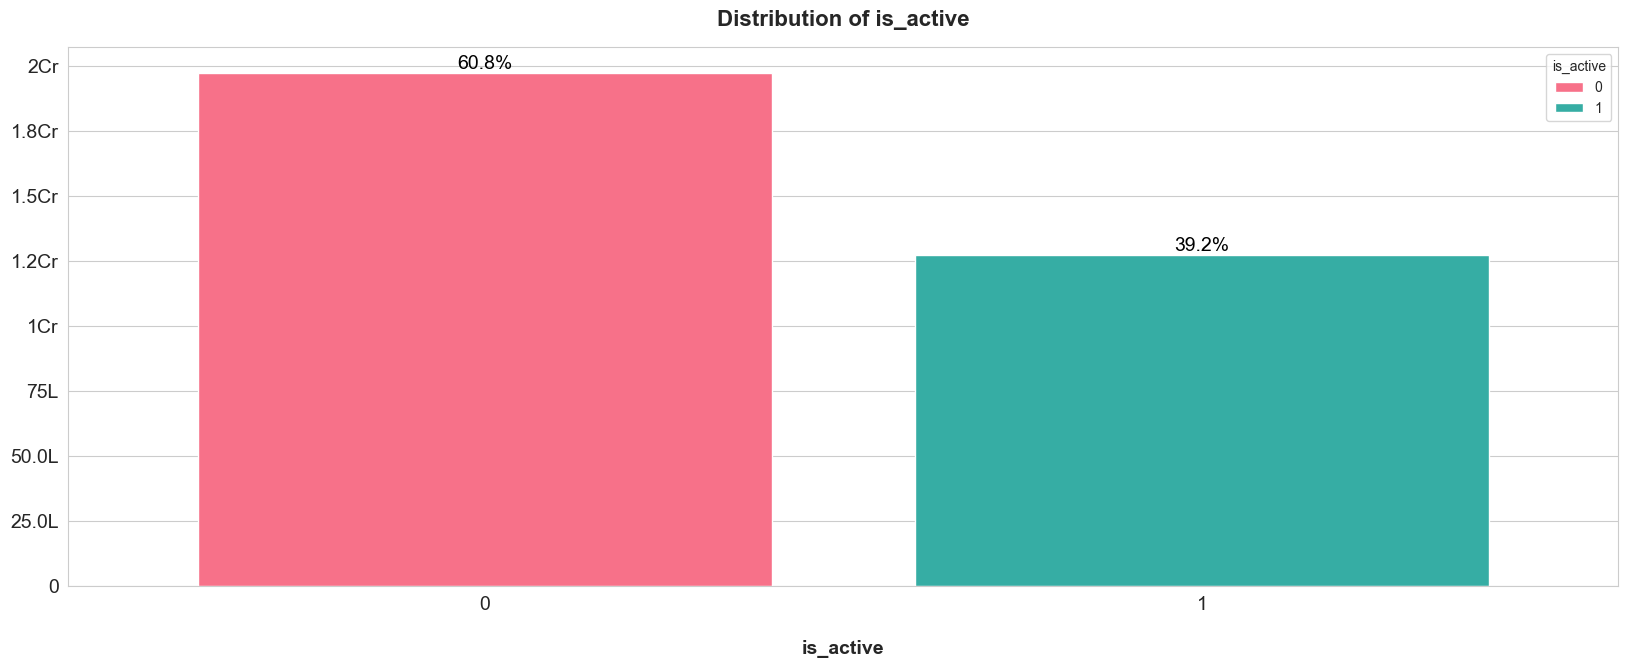

In [62]:
# Show active users distribution
count_plot(app_events, 'is_active')

In [63]:
# Accessing the number of rows in the 'app_events' DataFrame.
app_events.shape[0]

32473067

In [64]:
# Counting occurrences of each unique value in the 'is_installed' column
app_events['is_installed'].value_counts()

is_installed
1    32473067
Name: count, dtype: int64

In [65]:
# Dropping the 'is_installed' column from the 'app_events' DataFrame.
app_events = app_events.drop(columns=['is_installed']).copy()

In [66]:
# Converting events to categorical column
app_events['event_id'] = app_events['event_id'].astype('category')

In [67]:
# Displaying summary information about the 'app_events' DataFrame.
app_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32473067 entries, 0 to 32473066
Data columns (total 3 columns):
 #   Column     Dtype   
---  ------     -----   
 0   event_id   category
 1   app_id     int64   
 2   is_active  int64   
dtypes: category(1), int64(2)
memory usage: 663.0 MB


In [68]:
# Sampling 10 random rows from the 'app_events' DataFrame to inspect its data.
app_events.sample(10)

event_id               app_id  is_active
27086595  2713369 -3925027452315157003          1
22168363  2222103 -3955212733485100109          1
26857612  2690505 -8504475857937456387          0
18093398  1812573  7167114343576723123          0
3880879    389140  8693964245073640147          1
30451467  3048299  3358418900419361927          1
14369271  1440661  2882500560467681793          0
25270698  2530408   628020936226491308          1
28097936  2815635  6611625488841405564          0
17190110  1720635  5927333115845830913          1

### Event Data

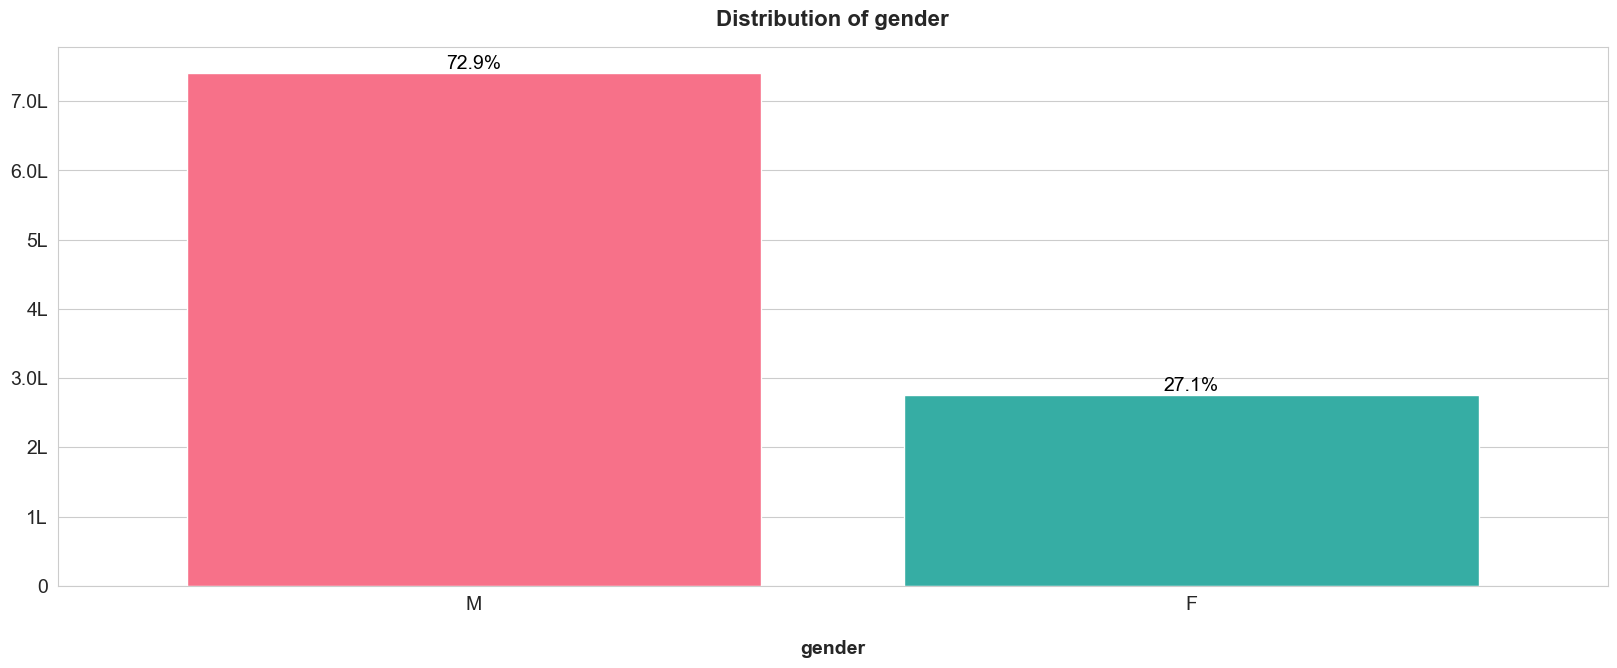

In [69]:
# Check gender distribution
count_plot(event_data, 'gender')

In [70]:
# Convert Gender to numeric
map_gender = {'F': 0, 'M': 1}

event_data['gender'] = event_data['gender'].map(map_gender)

In [71]:
# Counting occurrences of each unique value in the 'gender' column
event_data['gender'].value_counts()

gender
1    741357
0    276069
Name: count, dtype: int64

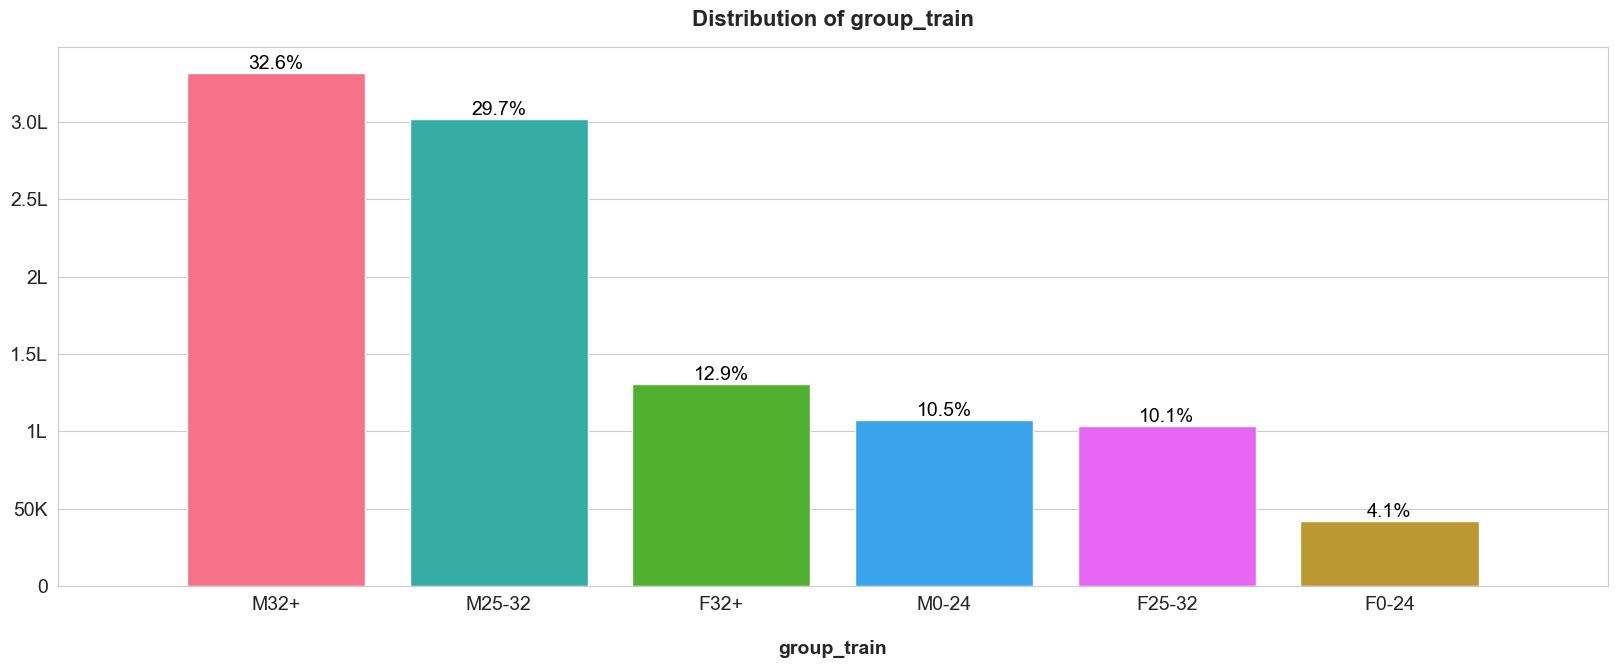

In [72]:
# Check age distribution
count_plot(event_data, 'group_train')

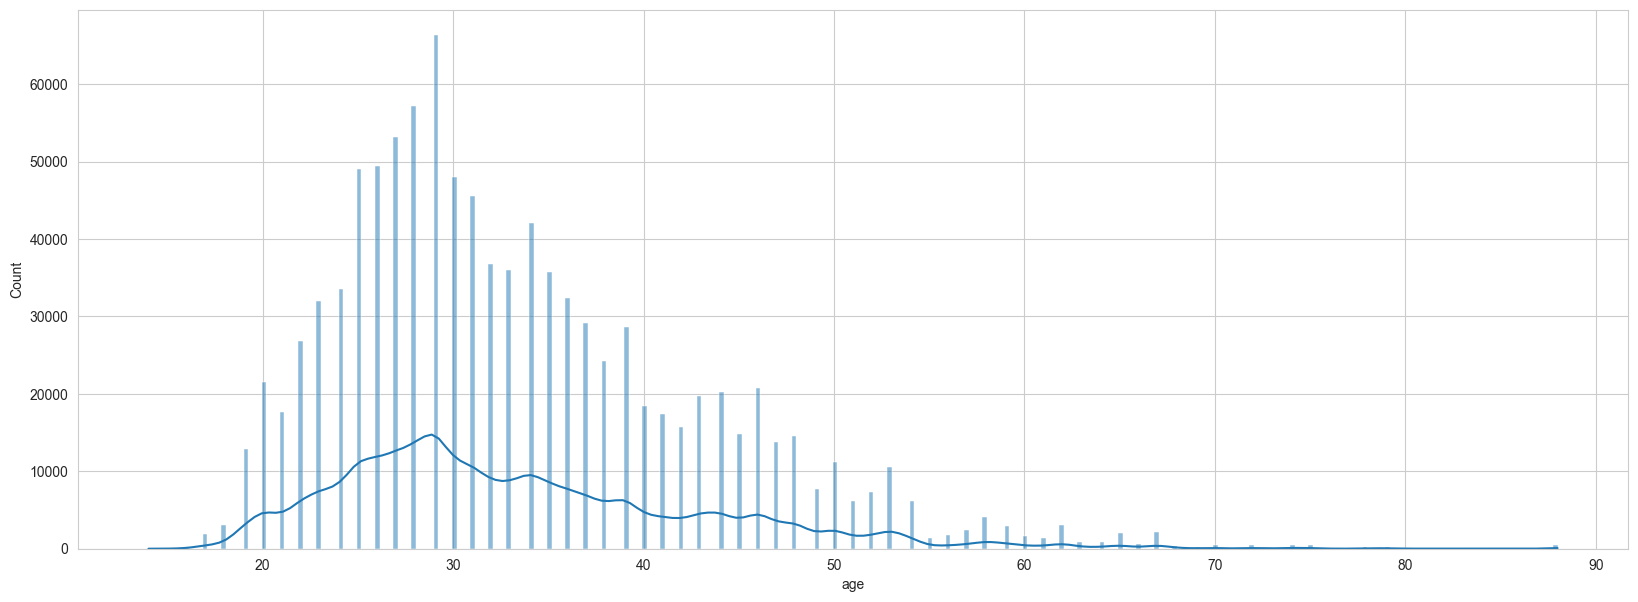

In [73]:
# Setting up the figure size for better visualization.
plt.figure(figsize=(20, 7))

# Creating a histogram overlaid with a kernel density estimate (KDE) plot
# for the 'age' column in the 'event_data' DataFrame.
# The `histplot` function from seaborn is used to generate this combined plot,
# providing both the distribution of age values and their probability density.
sns.histplot(event_data, x='age', kde=True)

# Displaying the plot on the screen.
plt.show()

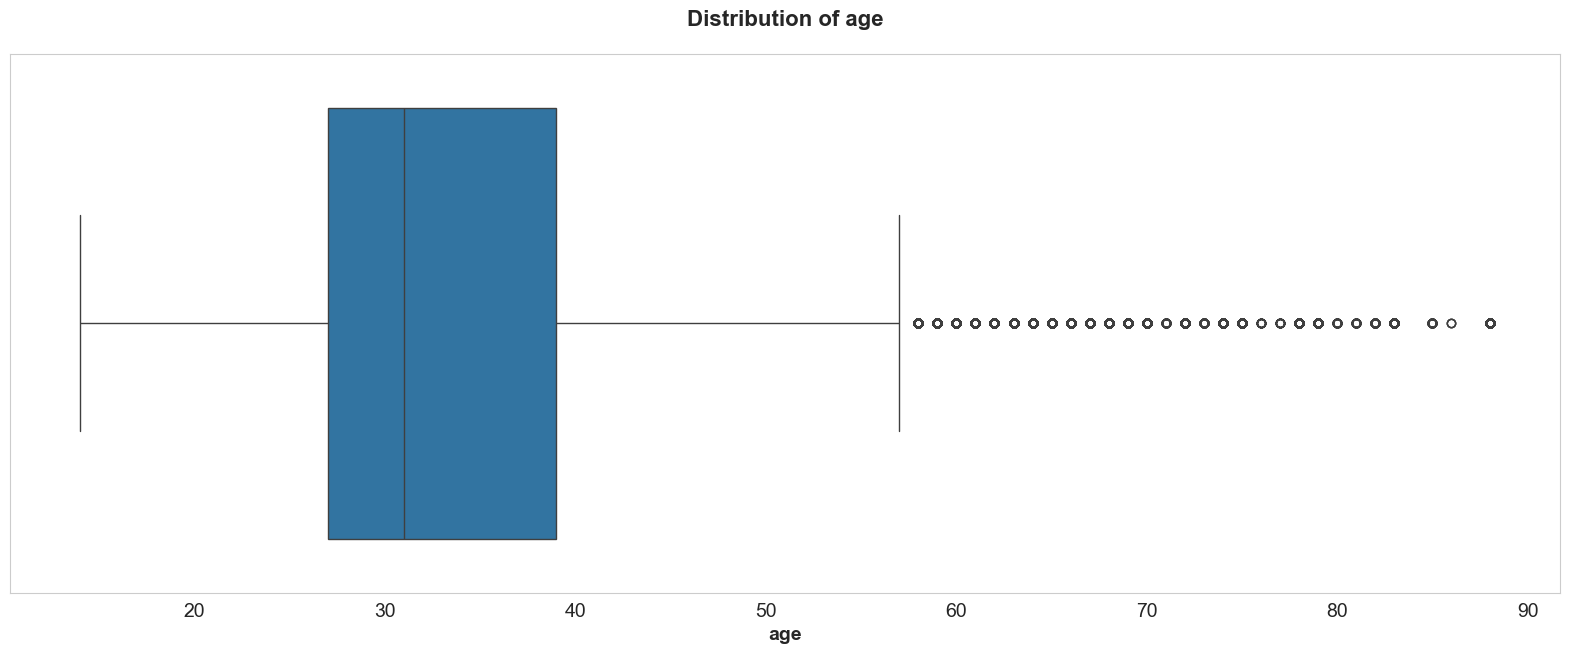

In [74]:
# Call function to create a boxplot for the 'age' column in the 'event_data' DataFrame.
create_boxplot(event_data, 'age')

In [75]:
def tag_age_group(age):
    """
    Categorizes a given age into predefined age groups.

    :param age: The age value to categorize. (int or float)
    :return: A string representing the age group.
             Returns 'Less than 20' for ages below 20,
             'Above 60' for ages above 60, and specific ranges for other ages.
    """

    if age < 20:
        return 'Less than 20'

    # Categorizing ages into groups from 20 to less than 25
    if 20 <= age < 25:
        return '20 to 24'

    # Categorizing ages into groups from 25 to less than 30
    if 25 <= age < 30:
        return '25 to 29'

    # Categorizing ages into groups from 30 to less than 35
    if 30 <= age < 35:
        return '30 to 34'

    # Categorizing ages into groups from 35 to less than 40
    if 35 <= age < 40:
        return '35 to 39'

    # Categorizing ages into groups from 40 to less than 45
    if 40 <= age < 45:
        return '40 to 44'

    # Categorizing ages into groups from 45 to less than 50
    if 45 <= age < 50:
        return '45 to 49'

    # Categorizing ages into groups from 50 to 54 inclusive
    if 50 <= age <= 55:
        return '50 to 54'

    # Categorizing ages into groups from 55 to 60 inclusive
    if 55 <= age <= 60:
        return '55 to 60'

    # Handling ages greater than 60
    if age > 60:
        return 'Above 60'

In [76]:
# Creating a new column 'age_group' in the 'event_data' DataFrame.
# This column categorizes each individual's age into predefined groups
# using the `tag_age_group` function. The `apply` method is used to apply
# this function to every entry in the 'age' column, and the result is stored
# in the new 'age_group' column.
event_data['age_group'] = event_data['age'].apply(tag_age_group)

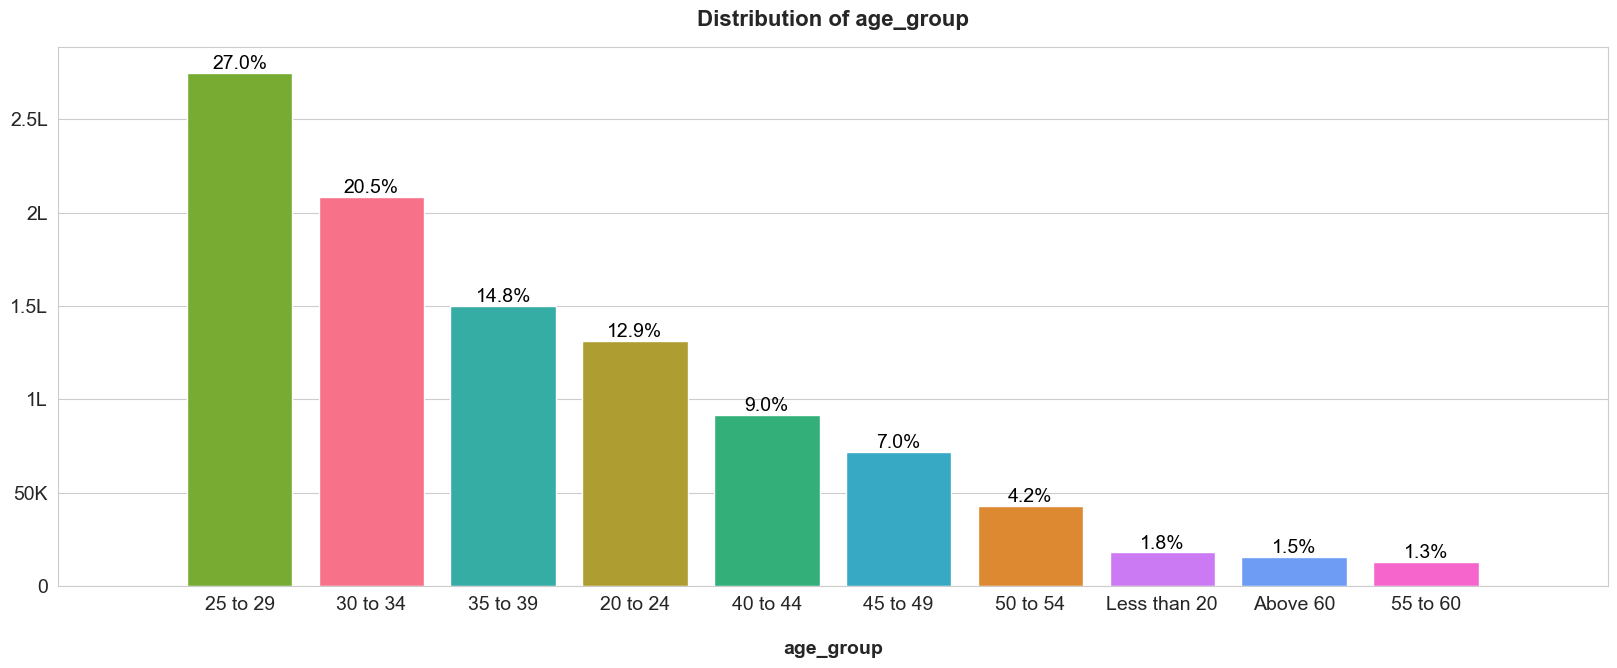

In [77]:
# Call function to create a count plot for the 'age_group' column in the 'event_data' DataFrame.
count_plot(event_data, 'age_group')

In [78]:
# Counting occurrences of each unique value in the 'age' column
# of the 'event_data' DataFrame. This method returns a Series with
# unique age values as indices and their counts as values, providing a summary
# of how many times each distinct age appears in the dataset.
event_data['age'].value_counts()

age
29    66297
28    57177
27    53110
26    49417
25    49063
      ...  
77       22
76       21
15       15
86        3
14        2
Name: count, Length: 73, dtype: int64

In [79]:
# Dropping the columns 'group_train' and 'age' from the 'event_data' DataFrame.
# The `drop` method is used to remove specified columns.
# The parameter drop='columns' ensures that only columns are targeted for removal.
# Using `.copy()` creates a new DataFrame, avoiding potential warnings related
# to chained indexing or modifications on views of the original DataFrame.

# The 'errors' parameter set to 'ignore' allows the function to proceed without error
# if any specified column does not exist in the DataFrame.
event_data = event_data.drop(columns=['group_train', 'age'], errors='ignore').copy()

In [80]:
# Converting the data types of specific columns in the 'event_data' DataFrame to categorical.

# Changing the data type of the 'device_id' column to category.
# This conversion is typically done for memory efficiency and improved performance
# when dealing with large datasets where the number of unique values is relatively small.
event_data['device_id'] = event_data['device_id'].astype('category')

# Similarly, changing the data type of the 'event_id' column to category
# for similar reasons as above. This can facilitate faster operations like groupby or join.
event_data['event_id'] = event_data['event_id'].astype('category')

#### Geospatial Data analysis

Displaying: Global Distribution of Geospatial Events


<Figure size 2000x1000 with 0 Axes>

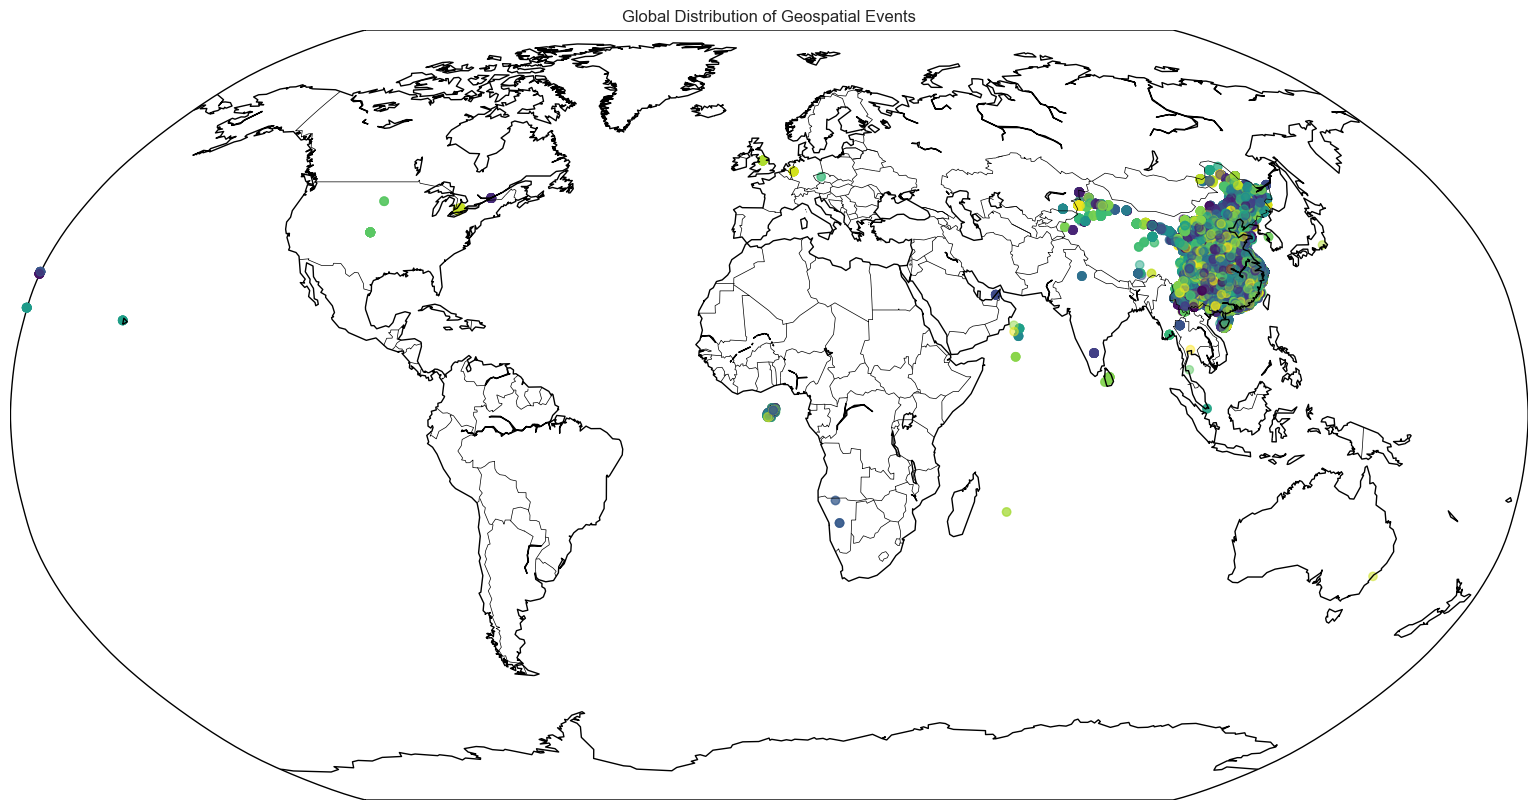

Displaying: Temporal Analysis


<Figure size 2000x1000 with 0 Axes>

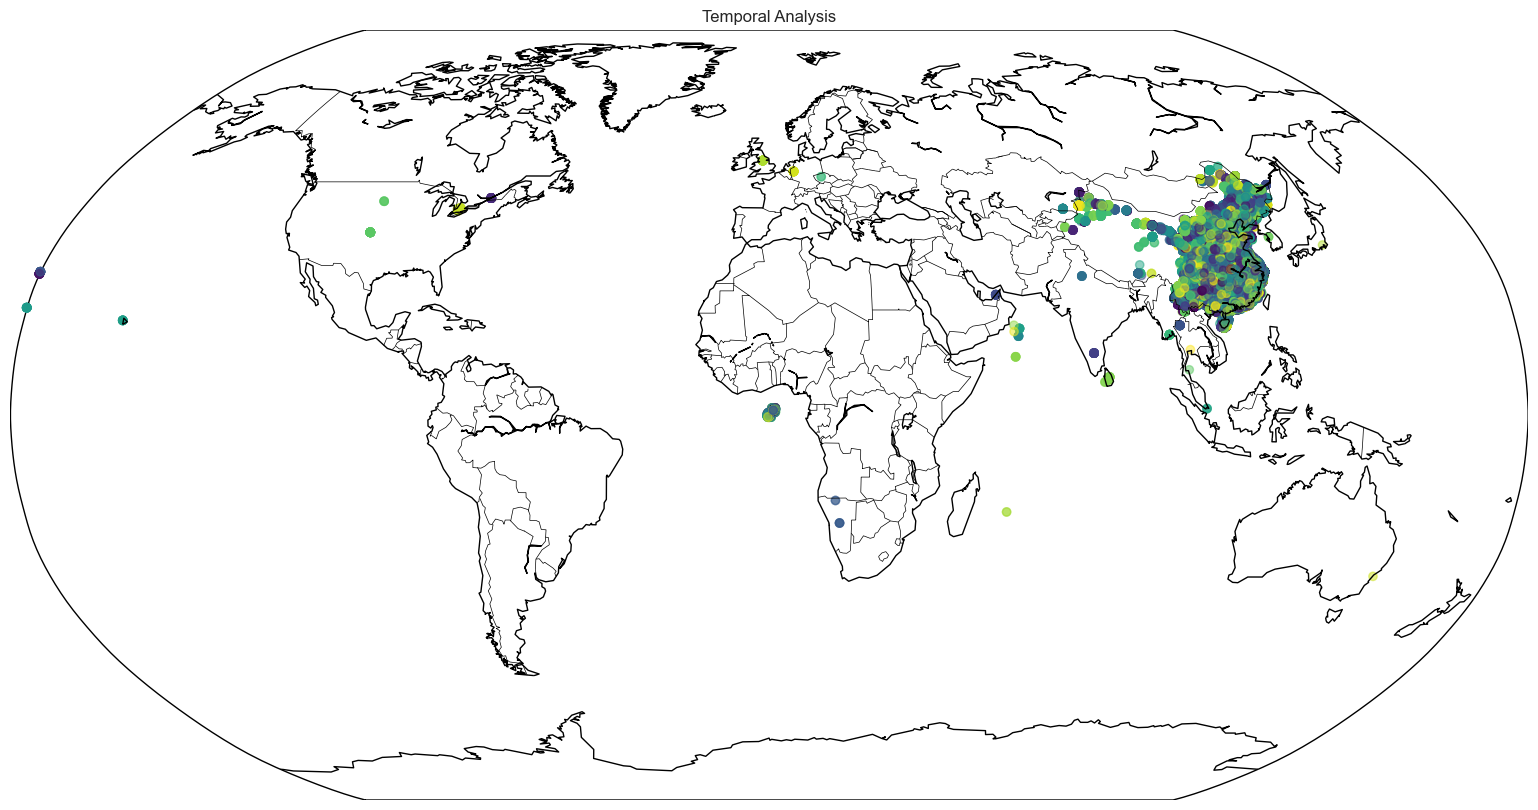

Displaying: MiniBatchKMeans Clustering Results


<Figure size 2000x1000 with 0 Axes>

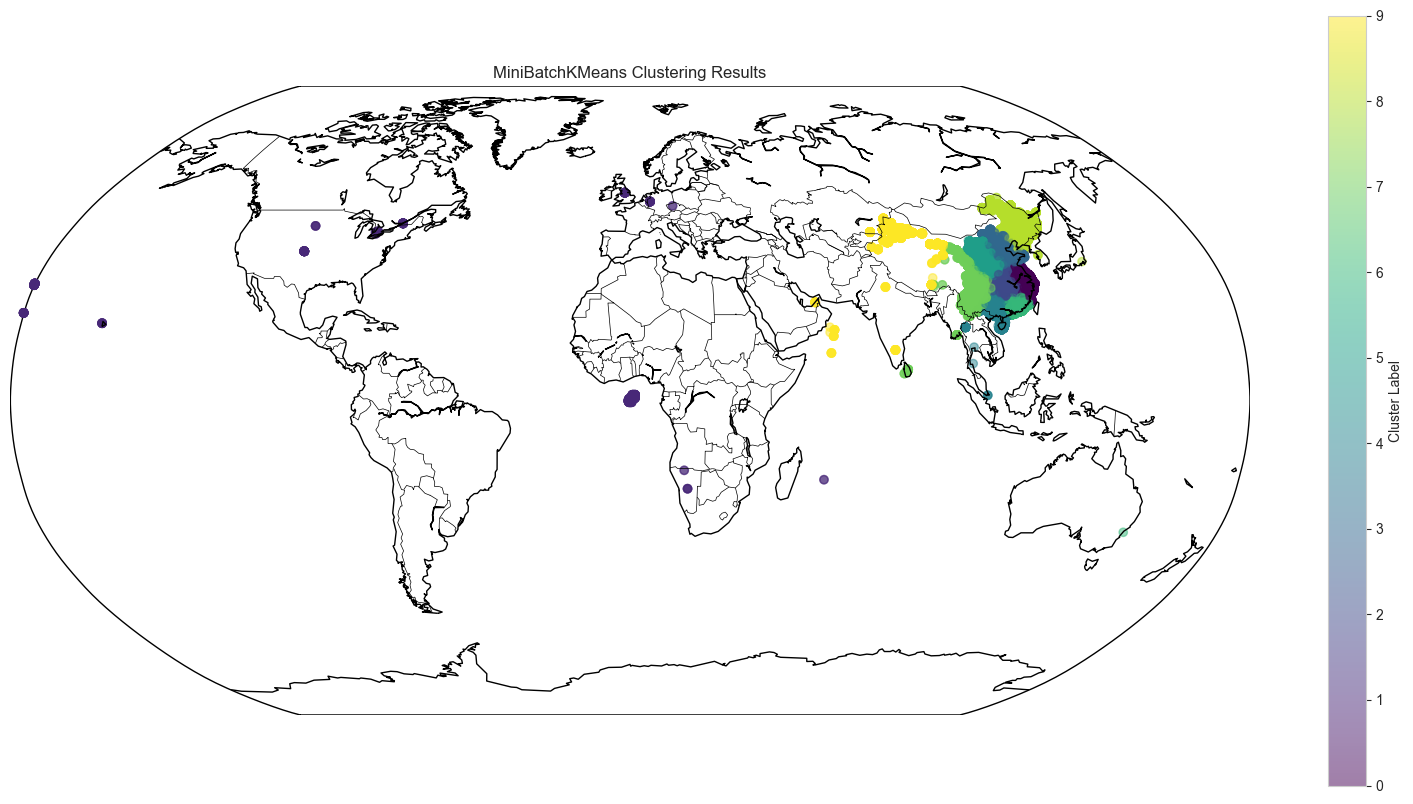

In [81]:
try:
    """
    Attempt to load previously saved geospatial plots from a pickle file.
    If the file is not found, process and create new plots.
    """
    with open("geospatial_plots.pkl", "rb") as f:
        loaded_plots = pickle.load(f)

except FileNotFoundError:
    # Initialize an empty dictionary to store plot figures.
    plot_data = {}

    # Copy event data for processing. Sample a fraction for faster computation.
    df = event_data.copy()
    df = df.sample(frac=0.4, random_state=42)                           # Sampling to reduce dataset size.

    # Convert 'datetimestamp' column to datetime objects for time-based analysis.
    df['datetimestamp'] = pd.to_datetime(df['datetimestamp'])

    # Extract hour information from the timestamp and count events per hour.
    df['hour'] = df['datetimestamp'].dt.strftime('%H')
    hourly_events = df.groupby('hour')['event_id'].count()

    # Prepare latitude and longitude for clustering.
    coords = df[['latitude', 'longitude']].values
    coords_rad = np.radians(coords)                                     # Convert coordinates to radians.

    # Configure MiniBatchKMeans clustering with specified parameters.
    min_batch_size = 1000                                               # Determines the number of samples per batch.
    km_clusterer = MiniBatchKMeans(n_clusters=10, batch_size=min_batch_size, init='k-means++', max_iter=100)

    print(f"Number of coordinates: {len(coords_rad)}")
    labels = km_clusterer.fit_predict(coords_rad)                       # Perform clustering.

    # Verify the integrity of label assignment.
    if len(labels) != len(df):
        print(f"Number of labels ({len(labels)}) does not match number of data points ({len(df)})")
        raise ValueError("Mismatch in the number of labels and data points")

    # Calculate the number of unique clusters, ignoring noise (-1).
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise label (-1)
    print(f"Clusters found: {n_clusters}")
    if n_clusters > 0:
        # Display the count of events per cluster.
        print("\nCluster Sizes:")
        print(pd.Series(labels).value_counts())
    else:
        # Indicate absence of clusters.
        print("\nNo clusters found.")

    # Existing visualization code with modifications to save plots instead of showing
    def plot_map(title, labels=None):
        """
        Function to create and save a map plot with optional clustering labels.

        :param title: Title for the generated plot.
        :param labels: Optional cluster labels for coloring points.
        """

        plt.figure(figsize=(20, 10))
        plt.title(title)

        # Initialize a global map using Basemap projection.
        m = Basemap(projection='robin', lat_0=0, lon_0=0)               # Robinson projection centered on the origin.
        m.drawcoastlines()
        m.drawcountries()

        x, y = m(df['longitude'].values, df['latitude'].values)

        if labels is not None:
            sc = plt.scatter(x, y, c=labels, cmap='viridis', marker='o', alpha=0.5)
            plt.colorbar(sc, label='Cluster Label')                     # Add a color bar for cluster identification.
        else:
            plt.scatter(x, y, marker='o', alpha=0.5)
        plot_data[title] = plt.gcf()                                    # Save the current figure in the dictionary.
        plt.close()

    # Generate and save geospatial plots using defined function.
    plot_map("Global Distribution of Geospatial Events")
    plot_map("MiniBatchKMeans Clustering Results", labels)

    # Plot a bar chart for hourly event distribution and save it as an image file.
    plt.figure(figsize=(10, 5))
    plt.title("Hourly Event Counts")

    hourly_events.plot(kind='bar', color='blue')                         # Bar plot of events by hour.
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Events")
    plt.grid(axis='y')

    plt.savefig("hourly_event_counts.png")                              # Save the figure to a file.
    plot_data["Hourly Event Counts"] = plt.gcf()
    plt.close()

    # Serialize and save the dictionary containing all plot figures.
    with open("geospatial_plots.pkl", "wb") as f:
        pickle.dump(plot_data, f)

    # Reload plots from the saved pickle file.
    with open("geospatial_plots.pkl", "rb") as f:
        loaded_plots = pickle.load(f)

finally:
    """
    After loading or creating plots, display all stored figures.
    """
    # Loop through all stored figures and display them
    for plot_name, fig in loaded_plots.items():
        print(f"Displaying: {plot_name}")  # Optional: Show which plot is being displayed

        # Recreate the figure with its original size and canvas properties.
        plt.figure(figsize=fig.get_size_inches())                        # Match the saved size of the figure.
        new_manager = plt.figure().canvas.manager
        new_manager.canvas.figure = fig

        # Set up the current figure's canvas to match the loaded one.
        fig.set_canvas(new_manager.canvas)

        # Display the restored plot on screen.
        plt.show()


In [82]:
# Extract latitude and longitude columns from event_data DataFrame into an array of coordinates.
coords = event_data[['latitude', 'longitude']].values

# Convert coordinate values (in degrees) to radians, which is necessary for distance calculations on a sphere (like Earth).
coords_rad = np.radians(coords)

# Initialize MiniBatchKMeans with specified parameters:
# n_clusters: Number of clusters to form. Set to 10 here.
# batch_size: The number of samples per minibatch. Adjust based on dataset size; larger datasets may require larger sizes for efficiency.
# init: Method for initialization ('k-means++' is generally a good choice).
# max_iter: Maximum number of iterations per single run.
min_batch_size = 1000  # Adjust based on your dataset size
km_clusterer = MiniBatchKMeans(n_clusters=10, batch_size=min_batch_size, init='k-means++', max_iter=100)

# Perform clustering on the radian-converted coordinates and store cluster labels back in the DataFrame under a new column 'cluster'.
event_data['cluster'] = km_clusterer.fit_predict(coords_rad)

# Output the number of unique clusters identified by the MiniBatchKMeans algorithm.
print(f"Clusters found: {event_data['cluster'].nunique()}")

Clusters found: 10


In [83]:
# Convert numeric cluster labels to strings and prepend 'Cluster ' to each label.
# This transformation aids in better readability when the cluster labels are displayed or used later on.
event_data['cluster'] = 'Cluster ' + event_data['cluster'].astype(str)

#### Storing Cluster with location values

In [84]:
# Select specific columns: 'latitude', 'longitude', and 'cluster' from the event_data DataFrame.
# The drop_duplicates() method is used to remove any duplicate rows based on these selected columns,
# ensuring that each combination of latitude, longitude, and cluster appears only once in the resulting DataFrame.
# Save the resulting DataFrame to a Parquet file named 'sector_data.parquet'.
# The index=False parameter ensures that pandas does not write row indices into the file.
# Parquet is an efficient columnar storage format, which is particularly well-suited for storing large datasets.
event_data[['latitude', 'longitude', 'cluster']].drop_duplicates().to_parquet('sector_data.parquet', index=False)

In [85]:
# This line retrieves 10 random samples from 'event_data'.
event_data.sample(10)

device_id  gender   event_id       datetimestamp  latitude  \
285668  -1897714234304560000       1  2883712.0 2016-05-02 16:48:09     22.91   
715653  -7900794321699520000       0   905708.0 2016-05-05 16:48:10     35.40   
1058188  2488356127177220000       0  2120217.0 2016-05-01 20:18:32     29.86   
1122819 -8907202230497200000       0   553597.0 2016-05-02 15:35:47     23.26   
1030739 -2611733232907370000       0   129774.0 2016-05-03 11:44:20     30.48   
585073  -1212279021374790000       0  1889441.0 2016-05-06 09:35:56     28.84   
823036  -1503499447994880000       1  3048483.0 2016-05-06 04:44:54     24.26   
456474  -8532200769734000000       1  2736669.0 2016-05-04 17:54:15     31.95   
843326  -7740351173556550000       1  1116293.0 2016-05-05 11:02:44     24.02   
259515  -5881744170197720000       1  1237472.0 2016-05-07 19:23:29     26.93   

         longitude age_group    cluster  
285668      108.49  20 to 24  Cluster 2  
715653      116.60  35 to 39  Cluster 9  
1058188     107.08  35 to 39  Cluster 3  
1122819     113.26  25 to 29  Cluster 2  
1030739     105.59  40 to 44  Cluster 3  
585073      112.36  45 to 49  Cluster 4  
823036      116.11  35 to 39  Cluster 2  
456474      118.87  25 to 29  Cluster 8  
843326      114.79  25 to 29  Cluster 2  
259515      102.16  20 to 24  Cluster 3

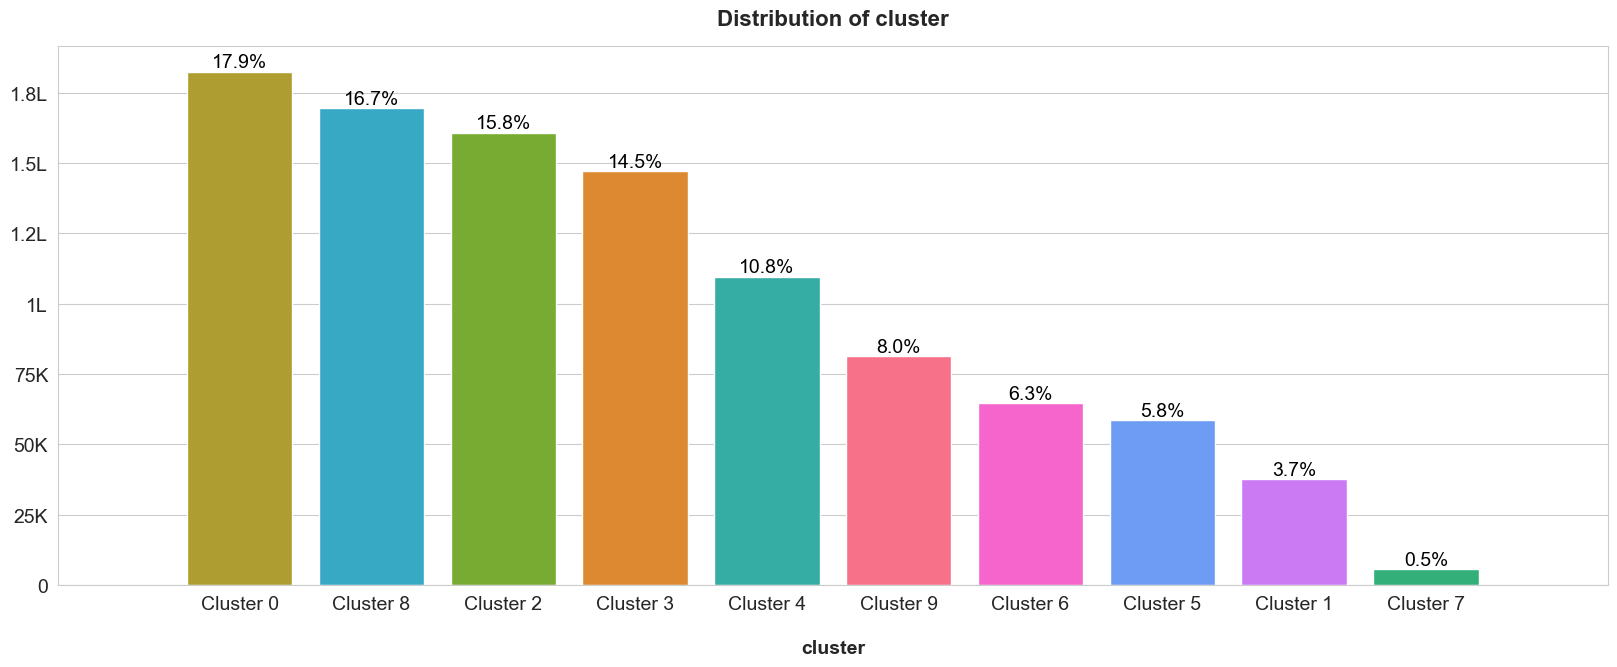

In [86]:
# This line generates a bar plot showing how many times each cluster appears.
count_plot(event_data, 'cluster')

In [87]:
# Accessing the shape attribute to get the dimensions of the DataFrame
event_data.shape

(1017426, 8)

In [88]:
# Convert 'datetimestamp' column from string to datetime format using pd.to_datetime
event_data['datetimestamp'] = pd.to_datetime(event_data['datetimestamp'], format='%Y-%m-%d %H:%M:%S')               # Specify date and time format

# Extract relevant features for datetimestamp: year, month, day, hour
event_data['Year'] = event_data['datetimestamp'].dt.strftime('%Y')                                                  # Extract year from datetime
event_data['Month'] = event_data['datetimestamp'].dt.strftime('%m')                                                 # Extract month (as zero-padded decimal)
event_data['Day'] = event_data['datetimestamp'].dt.strftime('%d')                                                   # Extract day of the month
event_data['Hour'] = event_data['datetimestamp'].dt.strftime('%H')                                                  # Extract hour in 24-hour format

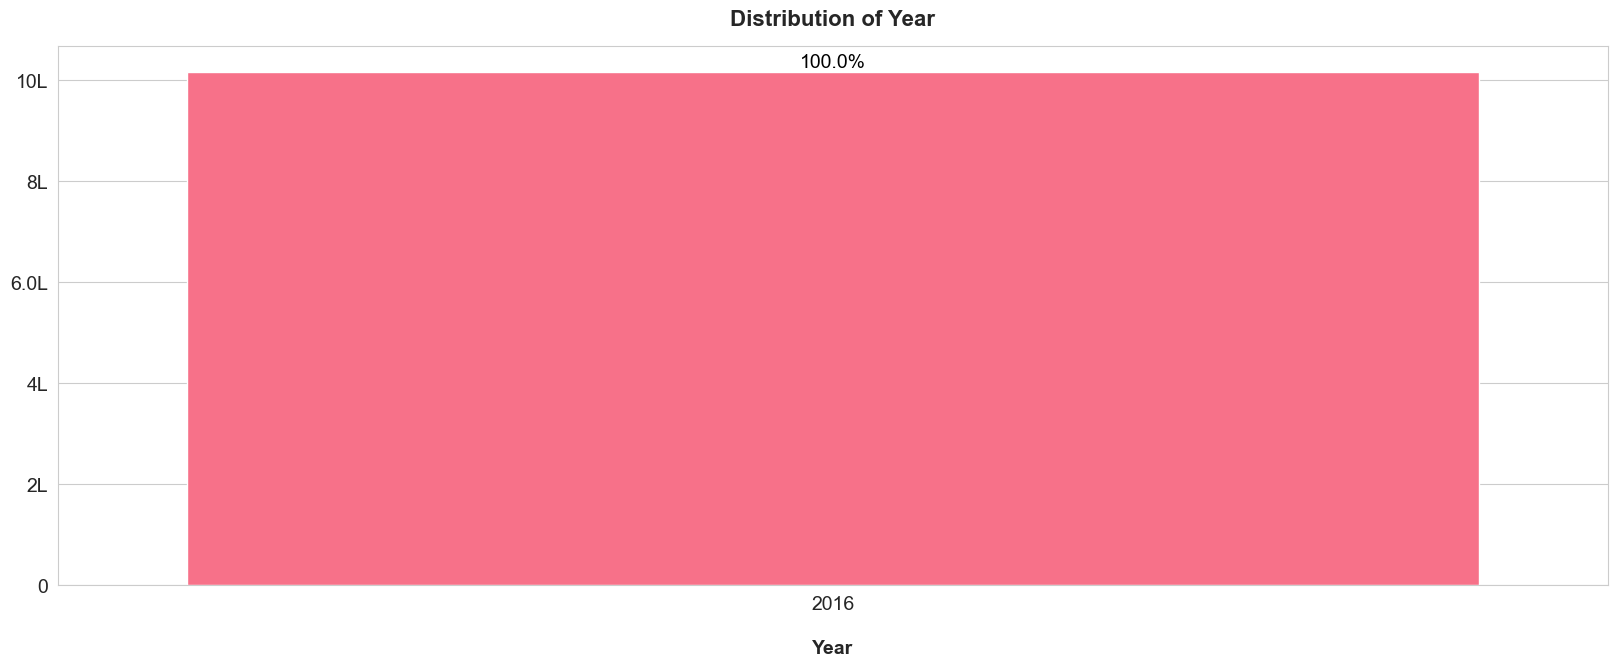

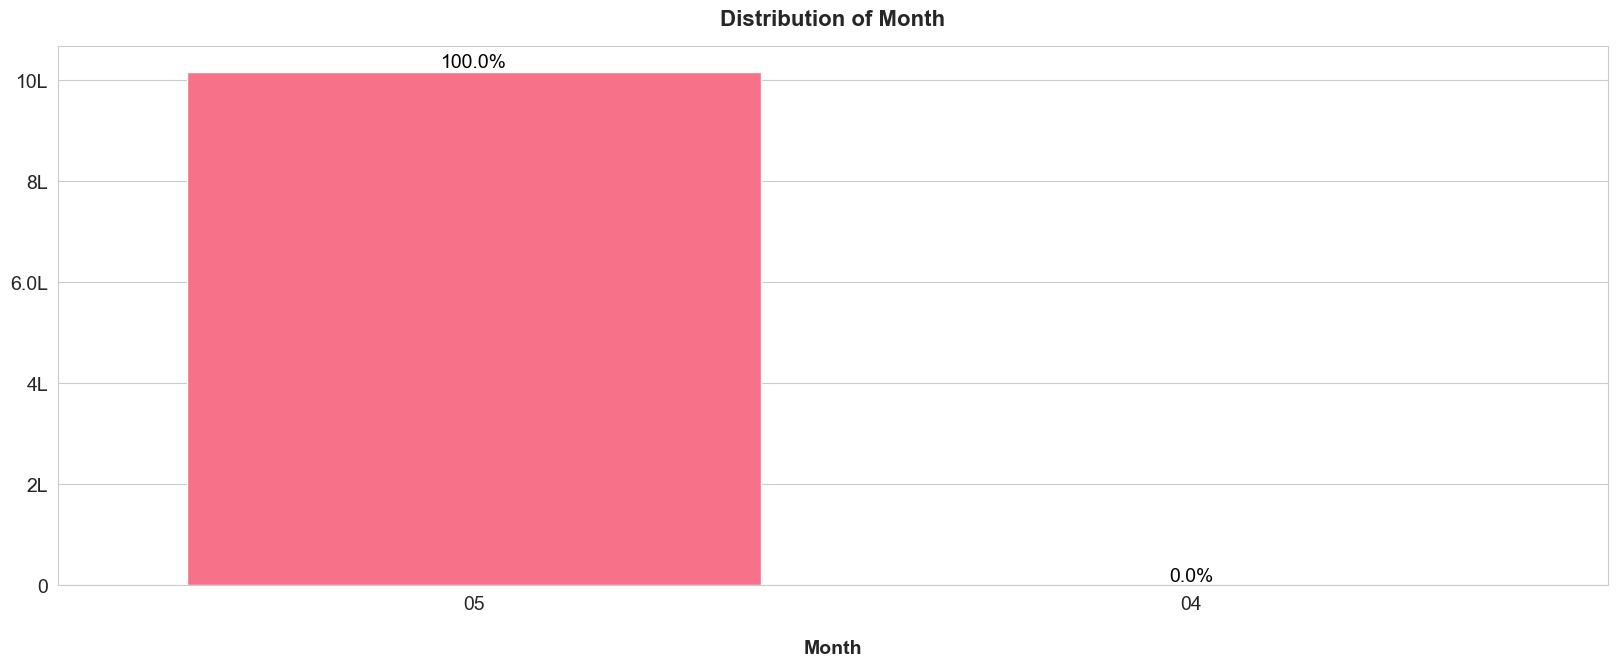

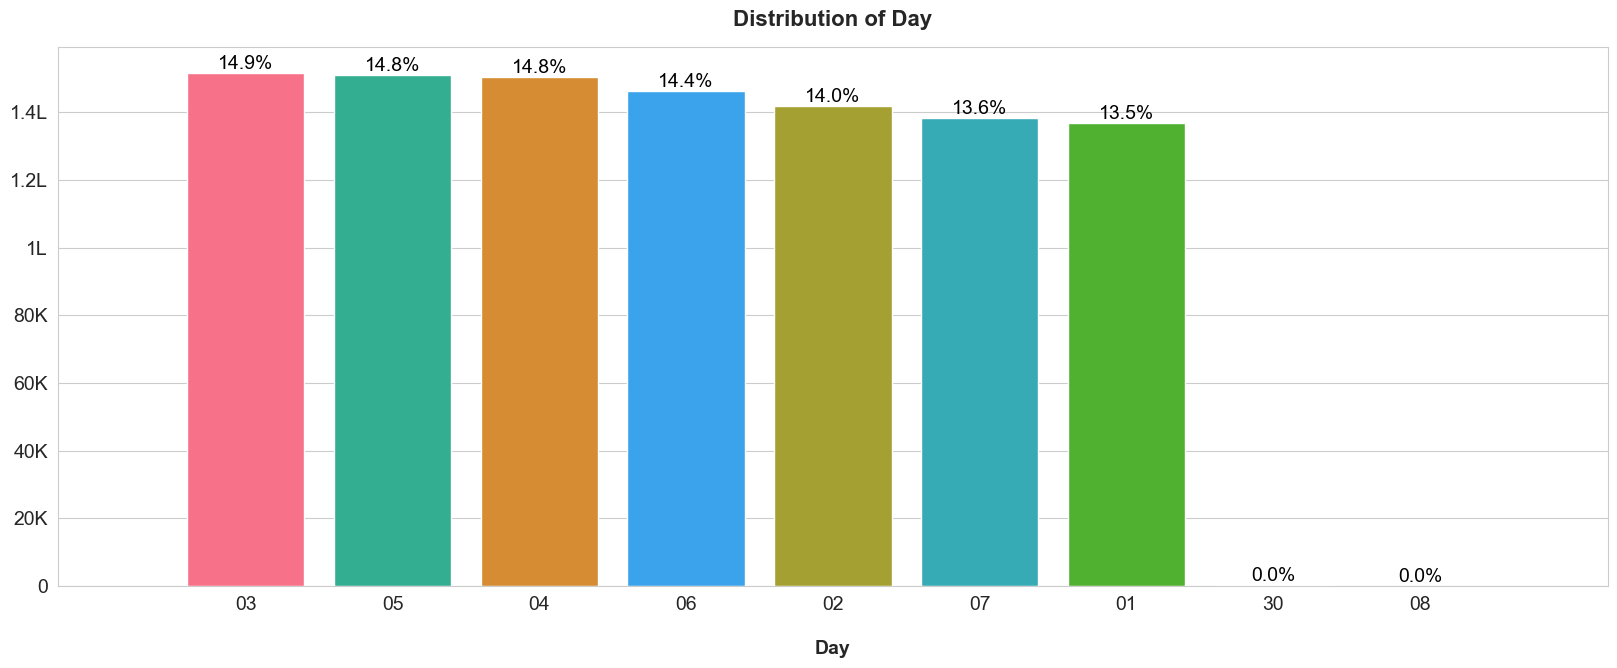

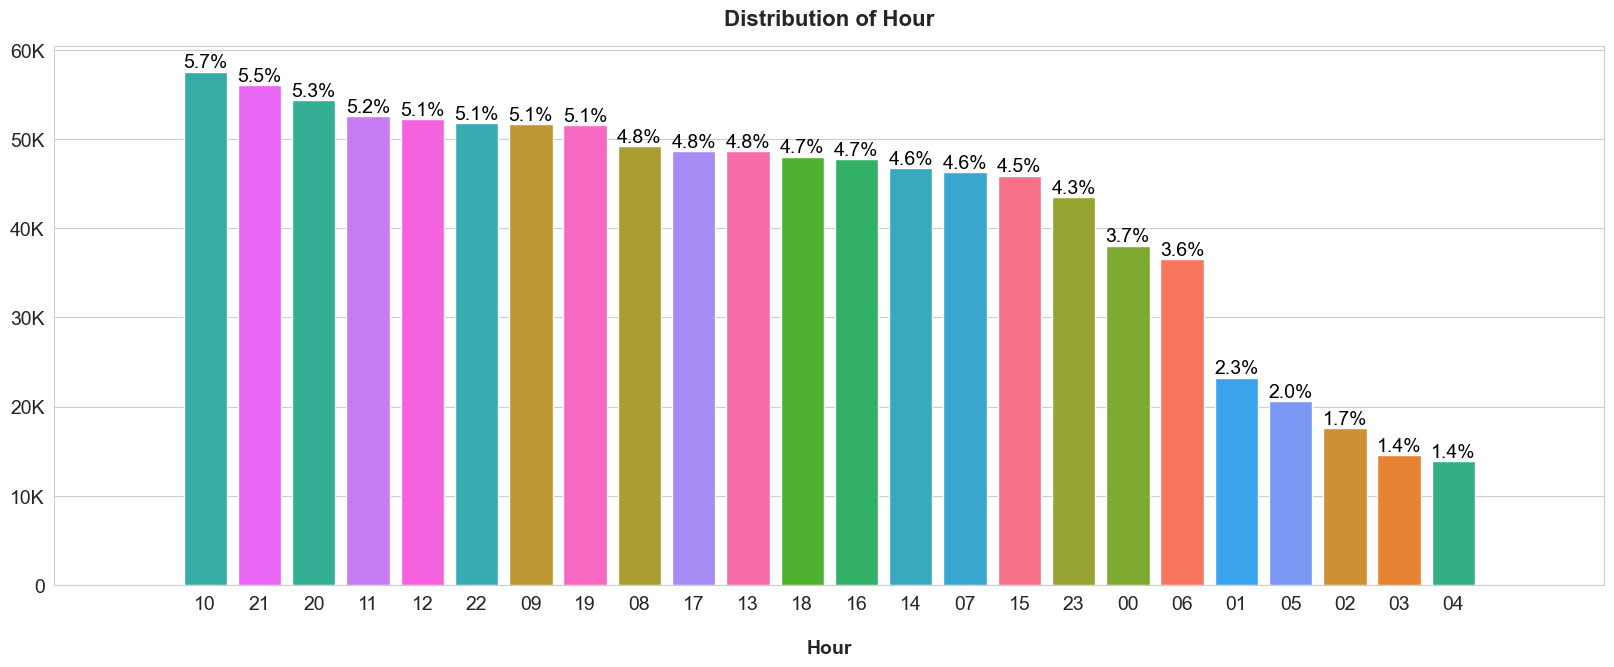

In [89]:
# Iterate over a list of time-related strings that define categories within event data.
# Each category represents a different level of granularity in timestamps:
# 'Year', 'Month', 'Day', and 'Hour'.
for x in ['Year', 'Month', 'Day', 'Hour']:
    # Call the function `count_plot` for each category.
    # This function likely generates a plot to visualize the count of events
    # occurring at different values within each specified time category (e.g.,
    # counts of events per year, month, day, or hour).

    # The variable `event_data` is expected to be a dataset containing event information,
    # where each entry has attributes corresponding to these time categories.

    # The purpose of this loop is to generate and display visualizations for the
    # distribution of events across different granularities in time, which can help
    # identify patterns or trends specific to each time category (e.g., more events
    # on certain days, hours, etc.).
    count_plot(event_data, x)

In [90]:
# Create a copy of the `event_data` DataFrame while dropping specific columns.
# The columns being dropped are 'Year' and 'Month'. Dropping these columns might
# be necessary for analyses that do not require yearly or monthly granularity,
# such as focusing on daily or hourly data.

# Use the `.drop()` method with parameters:
# - `columns=['Year', 'Month']`: specifies which columns to remove.
# - `inplace=False` is implied because we're assigning the result to a new variable (`event_data`).

# The `.copy()` method ensures that modifications are made on the new DataFrame
# and do not affect the original `event_data`. This helps maintain data integrity
# by preserving the original dataset for other analyses or purposes.
event_data = event_data.drop(columns=['Year', 'Month']).copy()

In [91]:
# Add a new column 'weekday' to the `event_data` DataFrame.
# The values for this column are derived from the 'datetimestamp' column.

# Use pandas datetime accessor `.dt` to extract the weekday information:
# - `event_data['datetimestamp'].dt.weekday`:
#   - This extracts the day of the week as an integer where Monday=0 and Sunday=6.
# The resulting series is assigned to a new column 'weekday' in `event_data`.

# This operation allows for analyses that consider the day-of-the-week patterns,
# such as identifying trends or behaviors specific to certain weekdays (e.g.,
# more events on Mondays versus Fridays).
event_data['weekday'] = event_data['datetimestamp'].dt.weekday

In [92]:
# Define a dictionary to map integer weekday codes to their corresponding
# string representations (names of the days).

map_weekday = {
  0: "Monday",                                                  # Maps integer 0 to Monday
  1: "Tuesday",                                                 # Maps integer 1 to Tuesday
  2: "Wednesday",                                               # Maps integer 2 to Wednesday
  3: "Thursday",                                                # Maps integer 3 to Thursday
  4: "Friday",                                                  # Maps integer 4 to Friday
  5: "Saturday",                                                # Maps integer 5 to Saturday
  6: "Sunday"                                                   # Maps integer 6 to Sunday
}


# Use the `map()` function to transform the 'weekday' column in `event_data`.
# This replaces each weekday integer with its corresponding string name using
# the `map_weekday` dictionary.

# The transformation makes the data more readable and user-friendly, as it
# converts technical codes into human-readable day names.
event_data['weekday'] = event_data['weekday'].map(map_weekday)

In [93]:
# Add a new column 'week_of_month' to the `event_data` DataFrame.
# The values for this column are calculated based on the day of the month from
# the 'datetimestamp' column.

# Use pandas datetime accessor `.dt` to perform operations:
# - `event_data['datetimestamp'].dt.day`: Extracts the day part of each date (1-31).
# - The floor division operator `// 7` is used to determine which week of the month
#   a particular day falls into, based on integer division.
# - Adding 1 adjusts the result so that weeks start at 1 instead of 0.

# This operation categorizes each date into one of four potential weeks within its
# respective month, making it easier to analyze patterns or trends specific to these
# weekly segments.
event_data['week_of_month'] = event_data['datetimestamp'].dt.day // 7 + 1

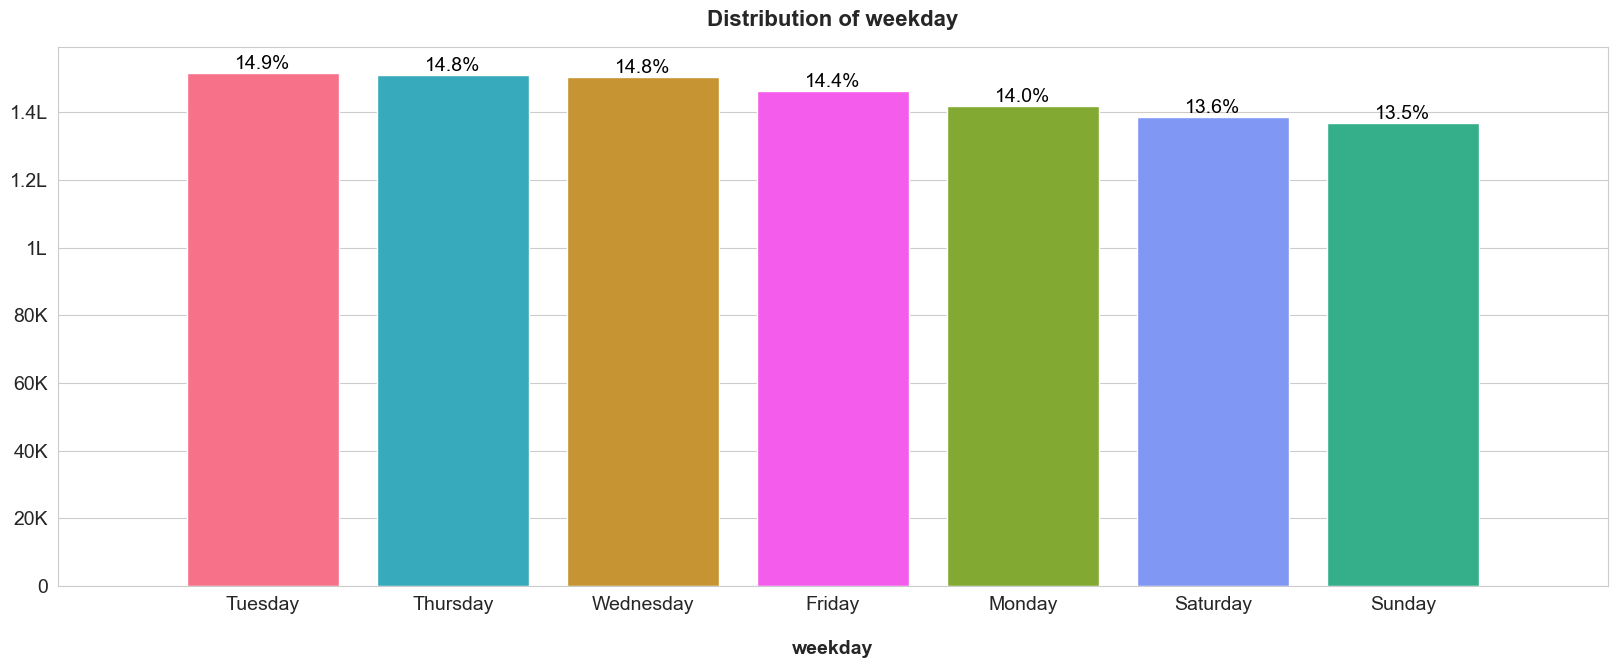

In [94]:
# Call the `count_plot` function with `event_data` and the string 'weekday'.
# This generates a plot visualizing the count distribution of events across
# different weekdays.

# The `event_data` DataFrame contains event information, including a 'weekday'
# column that specifies the day of the week for each event in text format (e.g., "Monday").

# By passing 'weekday' as an argument to `count_plot`, the function is expected
# to create a visualization that highlights how events are distributed or vary
# across different days of the week, allowing users to easily identify trends or
# patterns related to specific weekdays.
count_plot(event_data, 'weekday')

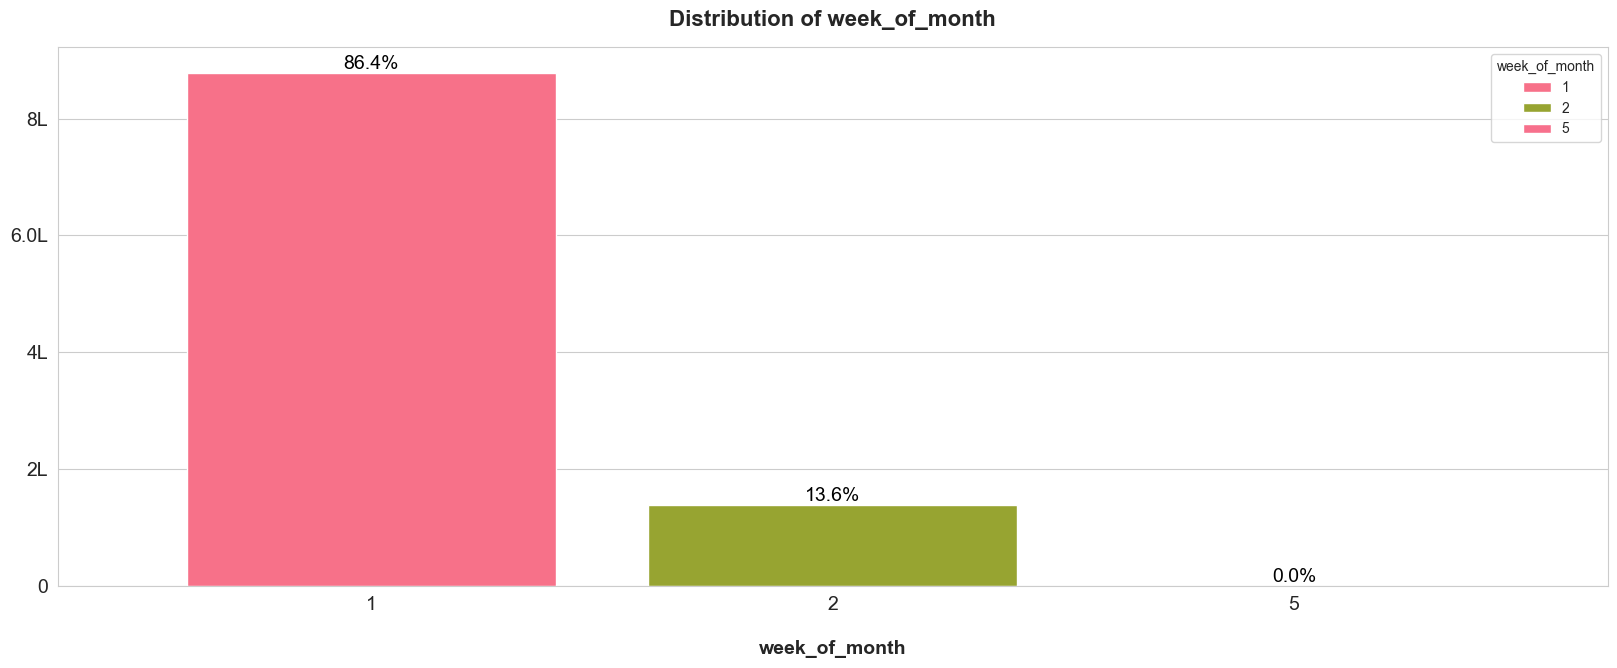

In [95]:
# Call the `count_plot` function with `event_data` and the string 'week_of_month'.
# This generates a plot visualizing the count distribution of events across
# different weeks within a month.

# The `event_data` DataFrame includes a 'week_of_month' column that indicates
# which week of its respective month each event occurred. Weeks are numbered from 1 to 4.

# By passing 'week_of_month' as an argument, the function is expected to produce
# a visualization illustrating how events are distributed or vary across these
# weekly segments within months, aiding in identifying patterns specific to certain weeks.
count_plot(event_data, 'week_of_month')

In [96]:
def get_hour_category(hour):
    """
    Categorizes a given hour into one of four parts of the day: Night, Morning,
    Afternoon, or Evening.

    :param hour: An integer representing an hour in 24-hour format (0-23).
    :return: A string indicating the part of the day corresponding to the hour.
             - 'Night' for hours 0 through 5
             - 'Morning' for hours 6 through 11
             - 'Afternoon' for hours 12 through 17
             - 'Evening' for hours 18 through 23

    This function helps in converting numerical hour values into descriptive
    time-of-day categories, which can be useful for analyses involving daily cycles.
    """

    # Check if the hour falls within nighttime (midnight to early morning)
    if 0 <= hour <=5:
        return 'Night'

    # Check if the hour falls within the morning period
    if 6 <= hour <=11:
        return 'Morning'

    # Check if the hour falls within the afternoon period
    if 12 <= hour <=17:
        return 'Afternoon'

    # If none of the above conditions are met, it must be evening
    if 18 <= hour <=23:
        return 'Evening'

In [97]:
# Convert the 'Hour' column in `event_data` to numeric data type.
# This ensures that any operations or functions applied to this column
# will treat its values as numbers, which is necessary for accurate calculations.

# Using `pd.to_numeric()` facilitates any subsequent numerical operations
# and helps prevent errors related to mixed data types.
event_data['Hour'] = pd.to_numeric(event_data['Hour'])

# Add a new column 'Hour_Category' to the `event_data` DataFrame by applying
# the function `get_hour_category` to each value in the 'Hour' column.

# The `.apply()` method is used here to transform each hour into its
# corresponding part-of-day category (e.g., Night, Morning, Afternoon, Evening).
# This categorization aids in analyses that require understanding of events
# based on the time-of-day context.
event_data['Hour_Category'] = event_data['Hour'].apply(get_hour_category)

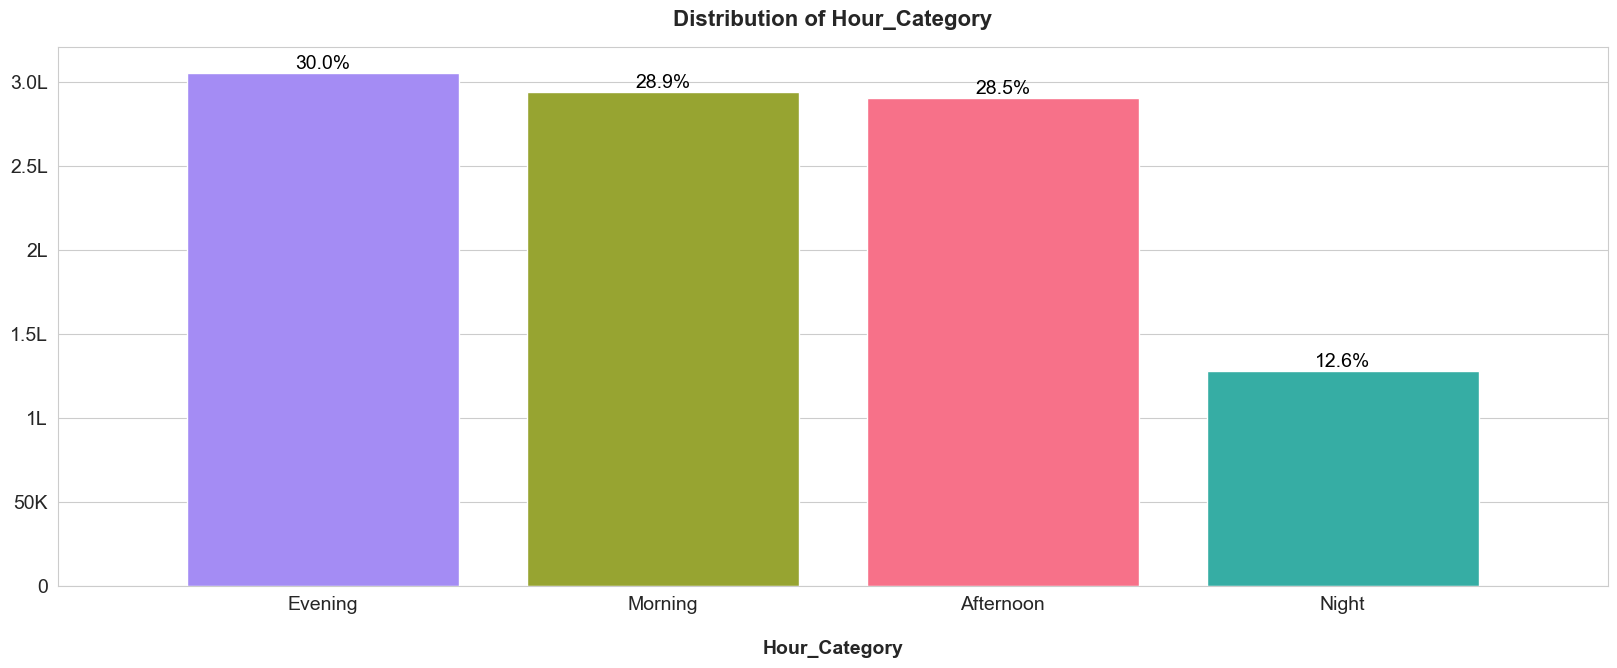

In [98]:
# Call the `count_plot` function with `event_data` and the string 'Hour_Category'.
# This generates a plot visualizing the count distribution of events across
# different categories of time-of-day: Night, Morning, Afternoon, or Evening.

# The `event_data` DataFrame includes an 'Hour_Category' column that indicates
# which part of the day each event occurred, derived from the original hour data.
# These categories are determined by the function `get_hour_category`.

# By passing 'Hour_Category' as an argument to `count_plot`, a visualization is
# created that highlights how events are distributed or vary across these time-of-day
# segments. This can help identify patterns such as higher activity during certain
# times of the day, facilitating more intuitive temporal analysis.
count_plot(event_data, 'Hour_Category')

In [99]:
# Drop the 'Hour' column from the `event_data` DataFrame and create a copy of
# the resulting DataFrame to ensure the original data is not altered.

# The `.drop()` method removes the specified columns ('Hour' in this case),
# effectively cleaning up or simplifying the dataset by removing redundant or
# unnecessary data, especially if it's already encapsulated within other features
# like 'Hour_Category'.
event_data = event_data.drop(columns=['Hour'])

In [100]:
# Convert the 'week_of_month' column from numerical values to strings and prepend
# each value with 'Week '. This transformation creates more descriptive labels for
# each week of the month.

# `event_data['week_of_month']` contains integer values representing which week
# (1 through 4) of a month an event occurred.
# Using `.astype(str)` converts these integers to strings, allowing string concatenation.
# The addition of 'Week ' before each value enhances readability and context for analysis.

# The result is that the 'week_of_month' column now contains more descriptive labels
# such as "Week 1", "Week 2", etc., which can be useful in visualizations or reports
# where clarity of time periods is important.
event_data['week_of_month'] = 'Week ' + event_data['week_of_month'].astype(str)

In [101]:
# Drop specific columns ('datetimestamp', 'latitude', 'longitude', 'Day') from
# the `event_data` DataFrame and create a copy of the resulting DataFrame. This
# ensures that the original data remains unchanged.

# The `.drop()` method is used to remove these columns, which might be unnecessary
# for certain analyses or visualizations, thereby simplifying the dataset.

# Dropping 'datetimestamp' might be due to already having derived useful features like
# 'weekday', 'week_of_month', and 'Hour_Category'.
# 'latitude' and 'longitude' are dropped likely because spatial analysis is not needed.
# 'Day' is removed since more granular temporal features have been computed.

# Using `inplace=False` (implied by assignment) ensures that a new DataFrame with
# the specified columns removed is returned, preserving the original dataset intact.
event_data = event_data.drop(columns=['datetimestamp', 'latitude', 'longitude', 'Day'])

In [102]:
# Define a list `col_to_encode` containing column names from `event_data`.
# These columns include categorical features that need to be transformed into
# numerical format for certain types of data analysis or modeling.

# The listed columns:
# - 'age_group': Represents different age categories.
# - 'cluster': Indicates cluster assignments, possibly from clustering algorithms.
# - 'weekday': Contains day-of-the-week names.
# - 'week_of_month': Includes descriptive labels like "Week 1", "Week 2", etc.
# - 'Hour_Category': Contains parts of the day such as Night, Morning, Afternoon, or Evening.

# Encoding these categorical variables is necessary because many machine learning
# models require numerical input. This list will be used in subsequent operations to
# apply encoding techniques like one-hot encoding or label encoding to convert these
# categories into a format suitable for analysis.
col_to_encode = ['age_group', 'cluster', 'weekday', 'week_of_month', 'Hour_Category']

In [103]:
# Convert the specified categorical columns in `event_data` to dummy/indicator variables
# using one-hot encoding and create a copy of the resulting DataFrame.

# The method `pd.get_dummies()` is used to transform each categorical column listed
# in `col_to_encode` into separate binary (0 or 1) columns, representing the presence
# or absence of each category. This process is known as one-hot encoding.

# One-hot encoding is necessary for many machine learning algorithms that require
# numerical input. Each original category value is replaced with a new column for
# each unique category in the data.

# By setting `columns=col_to_encode`, we specify which columns to apply this transformation
# to, ensuring only relevant categorical features are encoded.
# The `.copy()` method ensures that these changes do not affect the original DataFrame,
# maintaining data integrity by working on a new copy instead.
event_data = pd.get_dummies(event_data, columns=col_to_encode).copy()

#### Relation b/w Age Group and Location Clusters

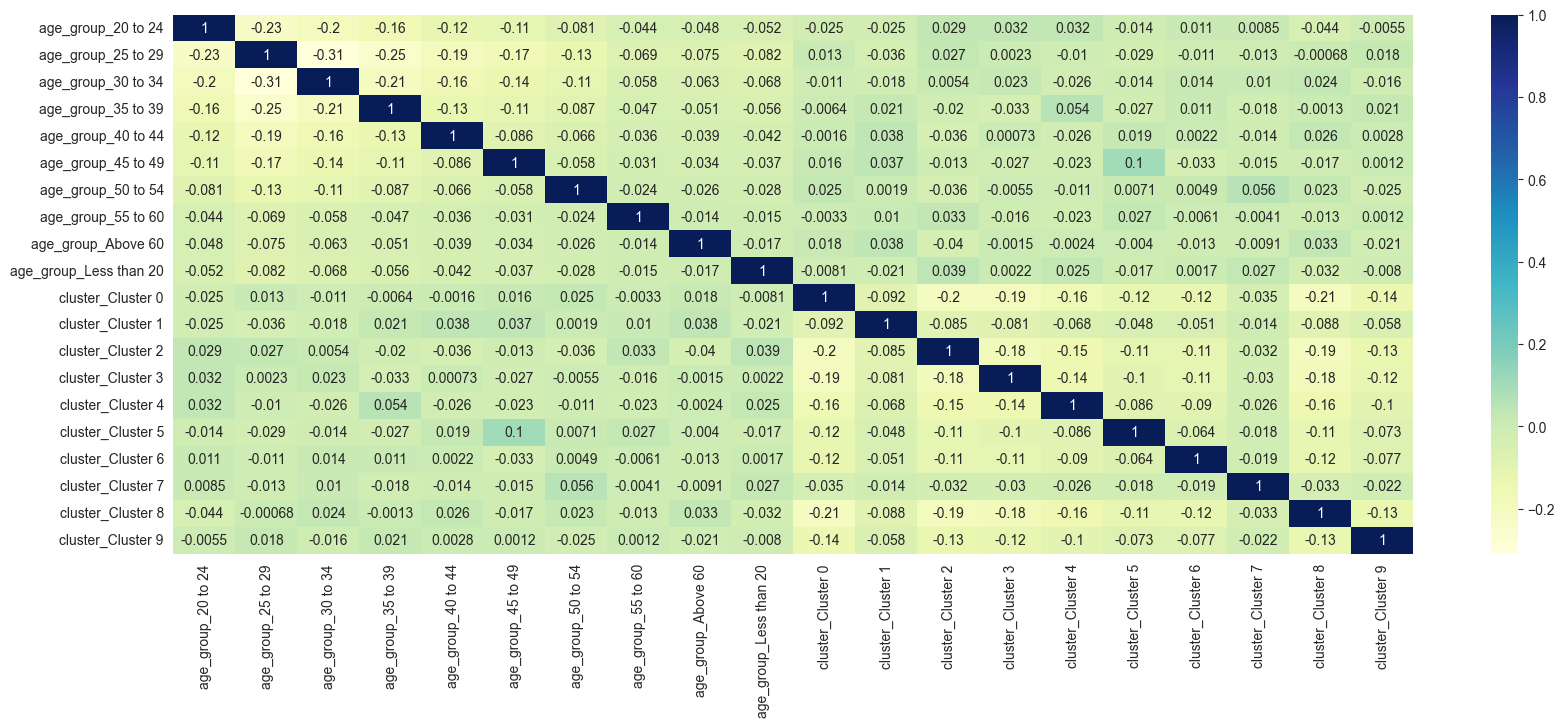

In [104]:
# Call the `create_heatmap` function with a subset of columns from `event_data`.
# The selected columns include binary indicators for age groups and clusters.

# These columns are derived from one-hot encoding categorical variables such as:
# - 'age_group': Transformed into multiple binary columns representing different age ranges.
# - 'cluster': Converted into binary columns indicating membership in various clusters,
#   likely obtained through a clustering algorithm like K-means.

# The function `create_heatmap` is expected to generate a heatmap visualization
# for the provided data. A heatmap will display correlations or co-occurrence patterns
# between these age groups and cluster assignments, which can reveal interesting
# relationships or trends within the dataset.

# By visualizing this subset of columns, analysts can better understand how different
# clusters are distributed across various age groups, potentially uncovering demographic
# insights.
create_heatmap(event_data[['age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20',
       'cluster_Cluster 0', 'cluster_Cluster 1', 'cluster_Cluster 2',
       'cluster_Cluster 3', 'cluster_Cluster 4', 'cluster_Cluster 5',
       'cluster_Cluster 6', 'cluster_Cluster 7', 'cluster_Cluster 8',
       'cluster_Cluster 9']])

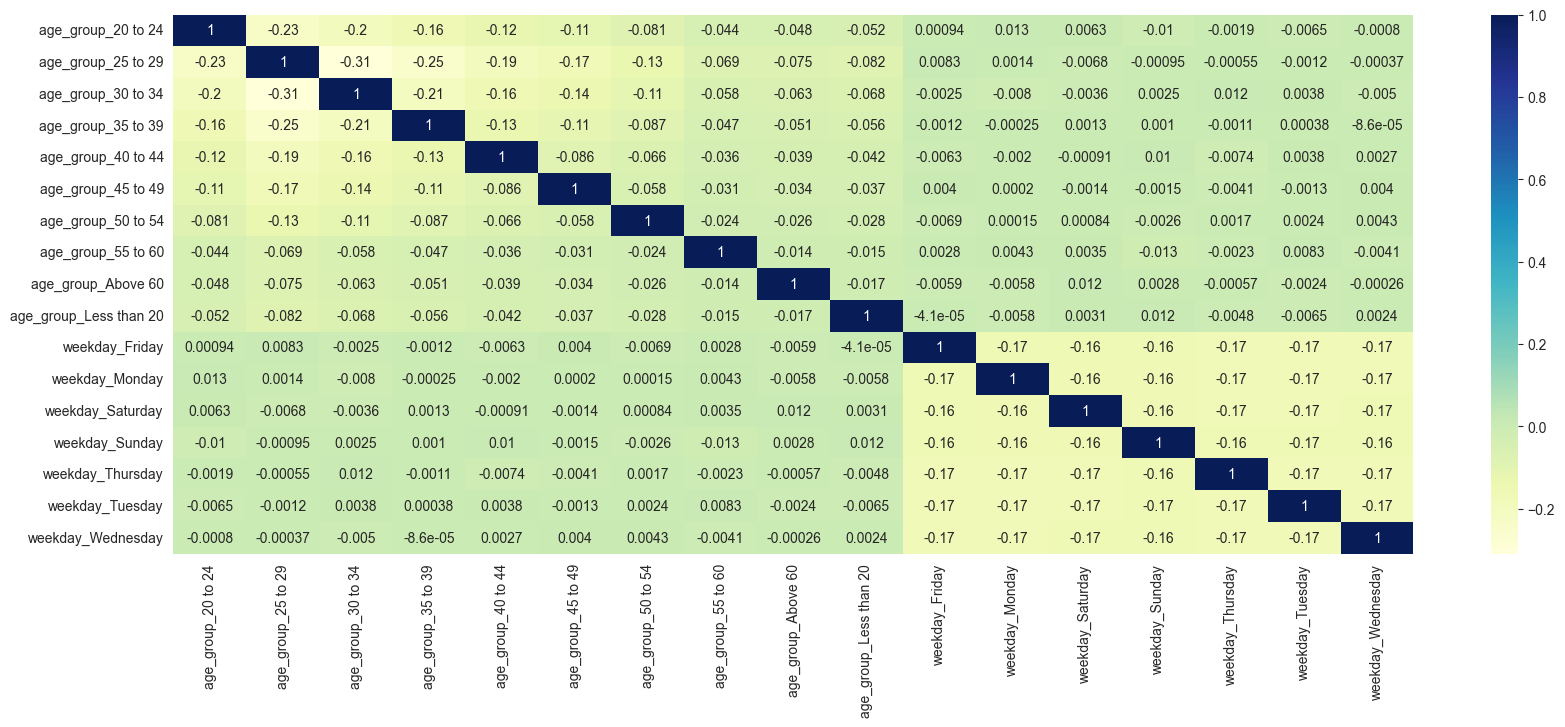

In [105]:
create_heatmap(event_data[['age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday']])

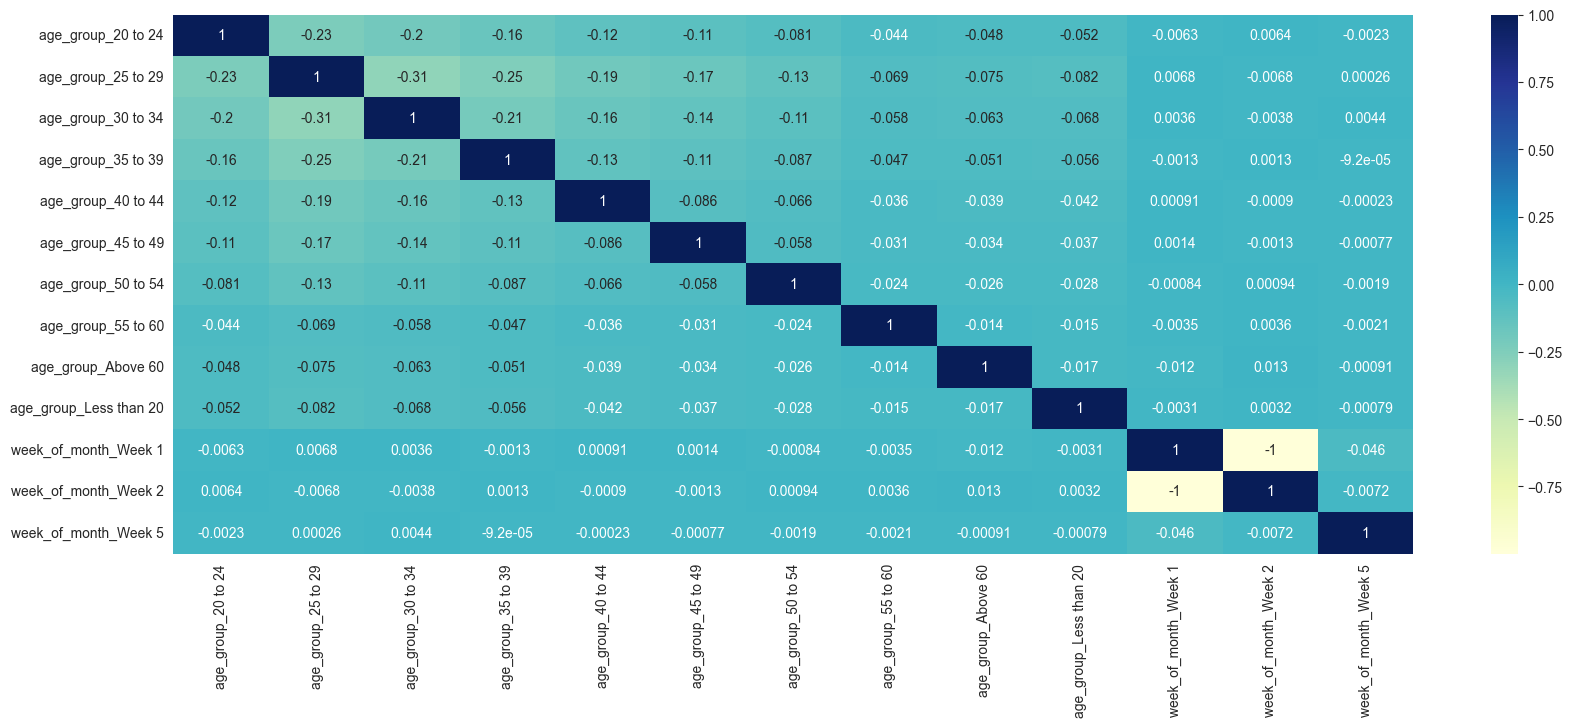

In [106]:
create_heatmap(event_data[['age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20', 'week_of_month_Week 1',
       'week_of_month_Week 2', 'week_of_month_Week 5']])

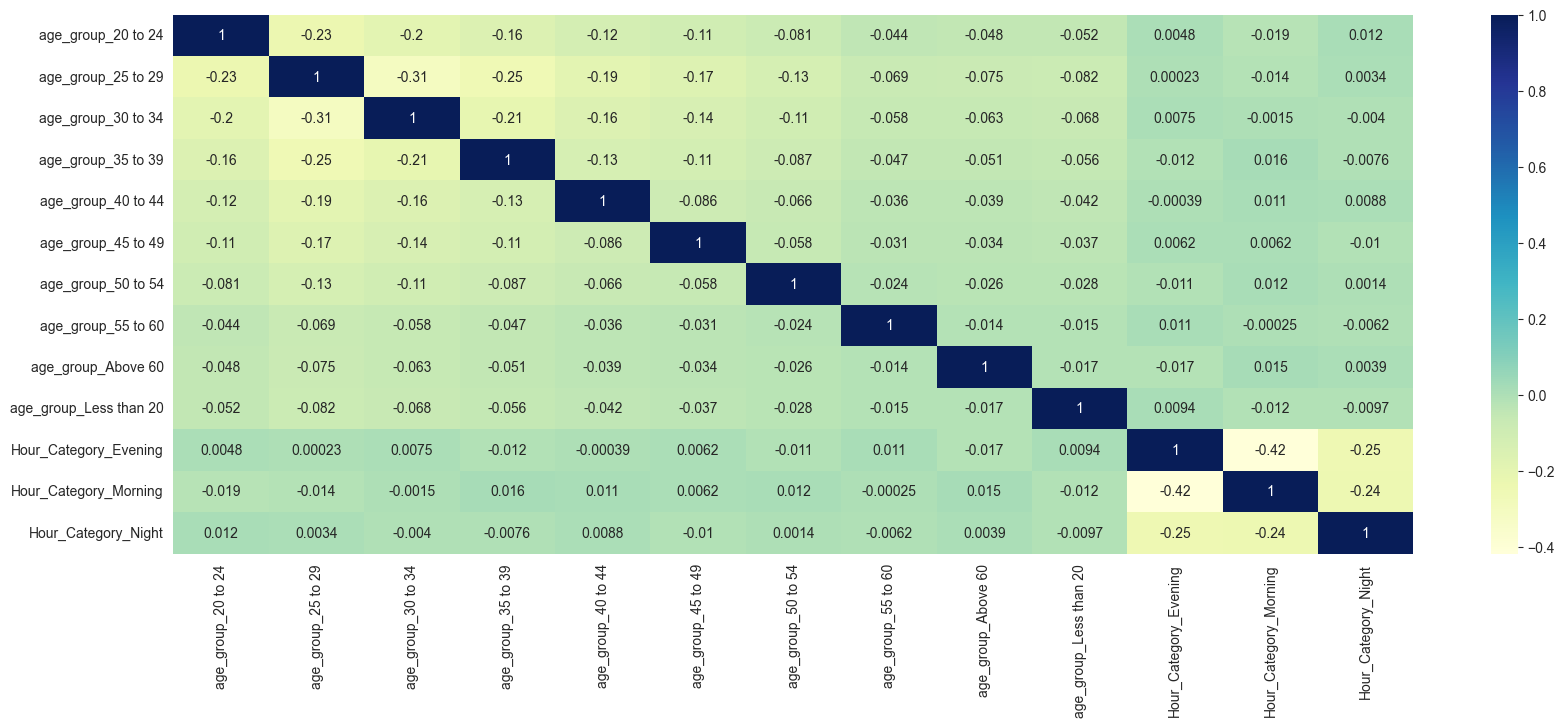

In [107]:
create_heatmap(event_data[['age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20', 'Hour_Category_Evening',
       'Hour_Category_Morning', 'Hour_Category_Night']])

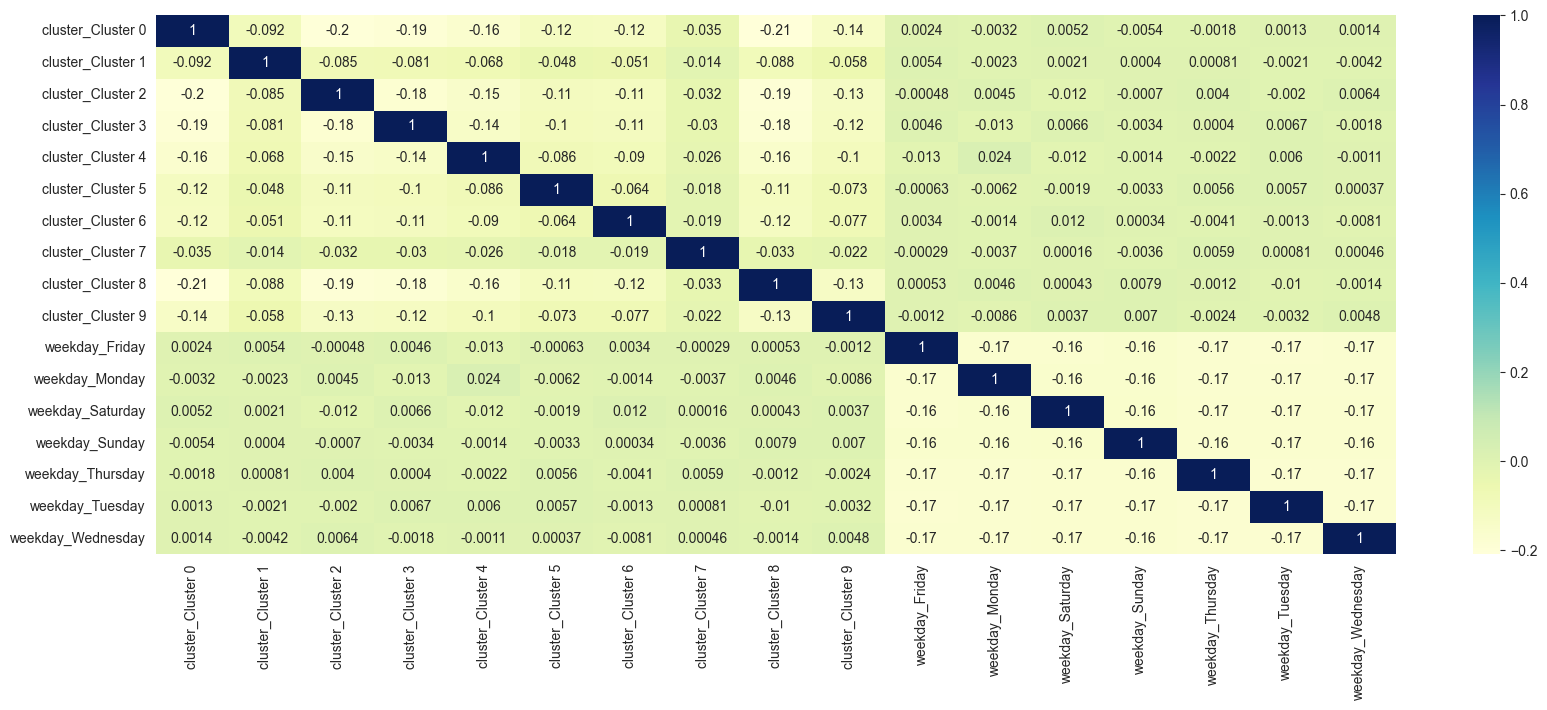

In [108]:
create_heatmap(event_data[['cluster_Cluster 0', 'cluster_Cluster 1', 'cluster_Cluster 2',
       'cluster_Cluster 3', 'cluster_Cluster 4', 'cluster_Cluster 5',
       'cluster_Cluster 6', 'cluster_Cluster 7', 'cluster_Cluster 8',
       'cluster_Cluster 9', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday']])

In [109]:
event_data.columns

Index(['device_id', 'gender', 'event_id', 'age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20',
       'cluster_Cluster 0', 'cluster_Cluster 1', 'cluster_Cluster 2',
       'cluster_Cluster 3', 'cluster_Cluster 4', 'cluster_Cluster 5',
       'cluster_Cluster 6', 'cluster_Cluster 7', 'cluster_Cluster 8',
       'cluster_Cluster 9', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'week_of_month_Week 1',
       'week_of_month_Week 2', 'week_of_month_Week 5',
       'Hour_Category_Afternoon', 'Hour_Category_Evening',
       'Hour_Category_Morning', 'Hour_Category_Night'],
      dtype='object')

In [110]:
# Use the `.sample()` method on `event_data` to randomly select 10 rows from the DataFrame.
event_data.sample(10)

device_id  gender   event_id  age_group_20 to 24  \
531129   3294449415906600000       1   631406.0               False   
193799  -1800023624954420000       1  3157021.0               False   
1106523  3026036052479290000       1  1600797.0               False   
881833   6216880192444760000       0    33910.0               False   
517843  -7074696261128900000       1    13887.0               False   
175956   -669426881946113000       1  1546900.0               False   
611958   7473034691150290000       1    49385.0               False   
198437  -9174142387982010000       1  2470291.0               False   
340519  -7079635384229620000       1  2292716.0               False   
292295  -8705128918819760000       0  1082519.0               False   

         age_group_25 to 29  age_group_30 to 34  age_group_35 to 39  \
531129                 True               False               False   
193799                 True               False               False   
1106523               False                True               False   
881833                 True               False               False   
517843                False               False               False   
175956                False               False               False   
611958                False               False               False   
198437                False                True               False   
340519                 True               False               False   
292295                 True               False               False   

         age_group_40 to 44  age_group_45 to 49  age_group_50 to 54  ...  \
531129                False               False               False  ...   
193799                False               False               False  ...   
1106523               False               False               False  ...   
881833                False               False               False  ...   
517843                 True               False               False  ...   
175956                False               False                True  ...   
611958                 True               False               False  ...   
198437                False               False               False  ...   
340519                False               False               False  ...   
292295                False               False               False  ...   

         weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
531129              False            False               True   
193799              False            False              False   
1106523              True            False              False   
881833              False            False               True   
517843               True            False              False   
175956              False            False               True   
611958              False            False              False   
198437              False            False              False   
340519              False             True              False   
292295               True            False              False   

         week_of_month_Week 1  week_of_month_Week 2  week_of_month_Week 5  \
531129                   True                 False                 False   
193799                  False                  True                 False   
1106523                  True                 False                 False   
881833                   True                 False                 False   
517843                   True                 False                 False   
175956                   True                 False                 False   
611958                  False                  True                 False   
198437                   True                 False                 False   
340519                   True                 False                 False   
292295                   True                 False                 False   

         Hour_Category_Afternoon  Hour_Category_Evenin

### Event Meta Data

In [111]:
# Convert all entries in the 'category' column to lowercase and strip leading/trailing whitespace.
app_events_metadata['category'] = app_events_metadata['category'].str.lower().str.strip()

In [112]:
# display_top_category_frequencies
print(app_events_metadata['category'].value_counts(normalize=True).head(10))

category
industry tag             0.123848
custom label             0.117392
tencent                  0.107345
game                     0.106011
property industry 2.0    0.099460
1 free                   0.041534
services 1               0.025770
property industry new    0.021667
relatives 1              0.019647
irritation / fun 1       0.019221
Name: proportion, dtype: float64


In [113]:
# Return the number of unique categories in the 'category' column.
app_events_metadata['category'].nunique()

468

In [114]:
# Create a DataFrame `df` for storing transformed data.
df = pd.DataFrame()

# Use LabelEncoder from scikit-learn to convert our categorical labels into numerical values
# Assuming 'category_col' is your column with 468 categories
le = LabelEncoder()
df['category'] = le.fit_transform(app_events_metadata['category'])

# Apply Non-negative Matrix Factorization (NMF) to reduce the dimensionality of our data.
# Perform NMF
nmf = NMF(n_components=50, random_state=42)

# Transform the data using NMF with 50 components
X_nmf = nmf.fit_transform(df[['category']])

In [115]:
# Print the shape of the transformed data to verify the dimensionality reduction.
print(X_nmf.shape)

(459452, 50)


In [116]:
# Print the shape of the original metadata DataFrame to understand its size.
app_events_metadata.shape

(459452, 3)

In [117]:
# Generate a list of column names from 'category_1' to 'category_50'.
['category_' + str(x) for x in range(1, 51)]

['category_1',
 'category_2',
 'category_3',
 'category_4',
 'category_5',
 'category_6',
 'category_7',
 'category_8',
 'category_9',
 'category_10',
 'category_11',
 'category_12',
 'category_13',
 'category_14',
 'category_15',
 'category_16',
 'category_17',
 'category_18',
 'category_19',
 'category_20',
 'category_21',
 'category_22',
 'category_23',
 'category_24',
 'category_25',
 'category_26',
 'category_27',
 'category_28',
 'category_29',
 'category_30',
 'category_31',
 'category_32',
 'category_33',
 'category_34',
 'category_35',
 'category_36',
 'category_37',
 'category_38',
 'category_39',
 'category_40',
 'category_41',
 'category_42',
 'category_43',
 'category_44',
 'category_45',
 'category_46',
 'category_47',
 'category_48',
 'category_49',
 'category_50']

In [118]:
# Create a DataFrame with transformed NMF features.
df = pd.DataFrame(X_nmf, columns=['app_category_' + str(x) for x in range(1, 51)])

In [119]:
# Display the first few rows of the DataFrame to verify its contents.
df.head()

app_category_1  app_category_2  app_category_3  app_category_4  \
0       28.253136        0.833205        1.464660        1.323487   
1        0.845944        0.910152        0.741533        1.735891   
2      305.587958        0.749612        1.471373        0.502529   
3        0.000000        0.000000        0.000000        0.000000   
4      287.790195        1.985983        4.591720        2.233950   

   app_category_5  app_category_6  app_category_7  app_category_8  \
0        2.230779        2.015016        1.815819        0.669044   
1        0.348975        0.874247        4.081150        0.377735   
2        0.634122        1.545646        4.036986        1.025235   
3        0.000000        0.000000        0.000000        0.000000   
4        3.287469        1.047740        2.741222        1.531188   

   app_category_9  app_category_10  ...  app_category_41  app_category_42  \
0        0.716756         2.110792  ...         0.210047         2.095862   
1        0.557263         0.161079  ...         0.492156         2.828272   
2        2.577630         1.420588  ...         0.966127         1.852995   
3        0.000000         3.060414  ...         1.714781         0.248256   
4        0.960294         1.676080  ...         0.450315         1.066709   

   app_category_43  app_category_44  app_category_45  app_category_46  \
0         1.519036         0.708964         0.848406         3.166615   
1         3.478120         0.399493         0.562310         1.691634   
2         0.463236         2.695411         0.374712         0.833713   
3         1.092644         1.873239         2.597088         0.723762   
4         1.275212         1.838288         0.772476         1.499252   

   app_category_47  app_category_48  app_category_49  app_category_50  
0         0.640717         0.564847         0.011064         0.507577  
1         2.676397         2.857079         1.129328         0.642587  
2         1.912407         0.332616         0.125947         2.473051  
3         1.027642         1.413612         3.819922         0.876261  
4         1.946469         0.664906         1.758794         1.362331  

[5 rows x 50 columns]

In [120]:
# Concatenate the original DataFrame with the new NMF features.
app_events_metadata = pd.concat([app_events_metadata, df], axis=1)

In [121]:
# Print the shape of the updated metadata DataFrame to verify the number of columns added.
app_events_metadata.shape

(459943, 53)

In [122]:
# Drop the original 'category' column since it's replaced by NMF features.
app_events_metadata = app_events_metadata.drop(columns=['category'])

In [123]:
# Randomly sample and display 10 rows from the updated metadata DataFrame.
app_events_metadata.sample(10)

app_id  label_id  app_category_1  app_category_2  \
11341  -7.752989e+17     719.0    1.818107e+02        1.117614   
453921 -2.421932e+18     854.0    1.926082e+02        1.201016   
260009  7.047176e+18     795.0    8.293978e+00        0.987454   
456743  6.641347e+18     854.0    1.935243e+02        0.718391   
137297 -4.846893e+18     789.0    1.622565e+02        3.664854   
421847  5.418585e+18      32.0    2.007391e-11        0.000000   
39301  -7.265444e+18     710.0    2.034563e+02        0.388681   
250788 -1.693751e+18     795.0    2.616129e+01        1.005670   
40244  -8.160784e+18     706.0    0.000000e+00        0.000000   
413867  7.992221e+18     548.0    8.670861e+01        2.516930   

        app_category_3  app_category_4  app_category_5  app_category_6  \
11341         2.606583        0.611776        0.083837    5.950319e-01   
453921        0.328244        1.192406        1.929670    2.364388e-01   
260009        0.521119        3.095174        0.592599    1.170581e+00   
456743        0.257511        0.361693        2.636316    5.232399e-01   
137297        0.304502        1.662301        2.455805    1.842914e+00   
421847        0.000000        0.000000        0.000000    1.546628e-14   
39301         1.522784        1.301996        2.679620    3.756494e+00   
250788        2.903784        1.411134        1.427577    3.149733e-01   
40244         0.000000        0.000000        0.000000    0.000000e+00   
413867        0.628038        0.143344        0.269927    1.065182e+00   

        app_category_7  app_category_8  ...  app_category_41  app_category_42  \
11341         0.156709        0.616258  ...         2.424350         1.864749   
453921        1.031842        5.625022  ...         3.083463         1.019027   
260009        5.517261        4.081271  ...         0.528107         0.848544   
456743        1.698179        3.963286  ...         1.918567         2.154367   
137297        0.691768        3.931617  ...         2.800893         0.781035   
421847        2.008537        1.190016  ...         0.525556         2.073546   
39301         1.389190        0.771379  ...         0.181486         1.599614   
250788        0.653329        2.281109  ...         1.979578         1.130179   
40244         0.000000        0.000000  ...         5.306887         4.079467   
413867        1.703712        2.743511  ...         3.258577         2.853502   

        app_category_43  app_category_44  app_category_45  app_category_46  \
11341          2.508628         2.912948         1.384236         1.617004   
453921         4.318796         1.591921         1.582422         0.379101   
260009         0.348773         5.582192         2.841308         2.141804   
456743         1.069978         3.620105         0.343431         1.516343   
137297         1.795950         4.105929         1.382120         2.428811   
421847         4.674211         2.800209         1.980015         3.569122   
39301          1.983343         1.369433         0.375153         0.072917   
250788         0.655194         2.685856         4.881140         1.601840   
40244          2.844840         0.267441         3.981653         1.391269   
413867         4.484679         5.013871         1.726102         0.284381   

        app_category_47  app_category_48  app_category_49  app_category_50  
11341          0.440765         2.392460         0.323709         3.679914  
453921         2.301372         0.889208         0.431528         1.274346  
260009         1.340336         3.207928         1.037531         5.531641  
456743         2.464806         2.750237         0.034940         3.987266  
137297         0.487902         1.148605         0.658139         1.412207  
421847         0.503464         3.641877         1.721254         2.155048  
39301          1.343207         2.490545         0.241455         2.770592  
250788         3.601265         0.954210         1.496096         0.971879  
40244          1.986219     

### Mobile Brand

In [124]:
# Returns the number of unique phone brands in the 'phone_brand' column.
train_mobile_brand['phone_brand'].nunique()

97

In [125]:
# Prints the top 10 most frequent phone brands along with their counts.
print(train_mobile_brand['phone_brand'].value_counts().head(10))

phone_brand
xiaomi     17300
samsung    13669
huawei     12960
oppo        5783
vivo        5637
meizu       4698
coolpad     3339
lenovo      2691
gionee      1123
htc         1013
Name: count, dtype: int64


In [126]:
# Creates a DataFrame containing the top 10 most frequent phone brands along with their counts.
df = train_mobile_brand['phone_brand'].value_counts().head(10).reset_index()

In [127]:
# Display dataframe
df

phone_brand  count
0      xiaomi  17300
1     samsung  13669
2      huawei  12960
3        oppo   5783
4        vivo   5637
5       meizu   4698
6     coolpad   3339
7      lenovo   2691
8      gionee   1123
9         htc   1013

In [128]:
# Creates a new column 'phone_brand_category' that is a copy of the 'phone_brand' column.
train_mobile_brand['phone_brand_category'] = train_mobile_brand['phone_brand']

In [129]:
# Sets the value of 'phone_brand_category' to 'Others' for rows where 'phone_brand' is not in the list of top 10 brands.
train_mobile_brand.loc[~train_mobile_brand['phone_brand'].isin(df['phone_brand']), 'phone_brand_category'] = 'Others'

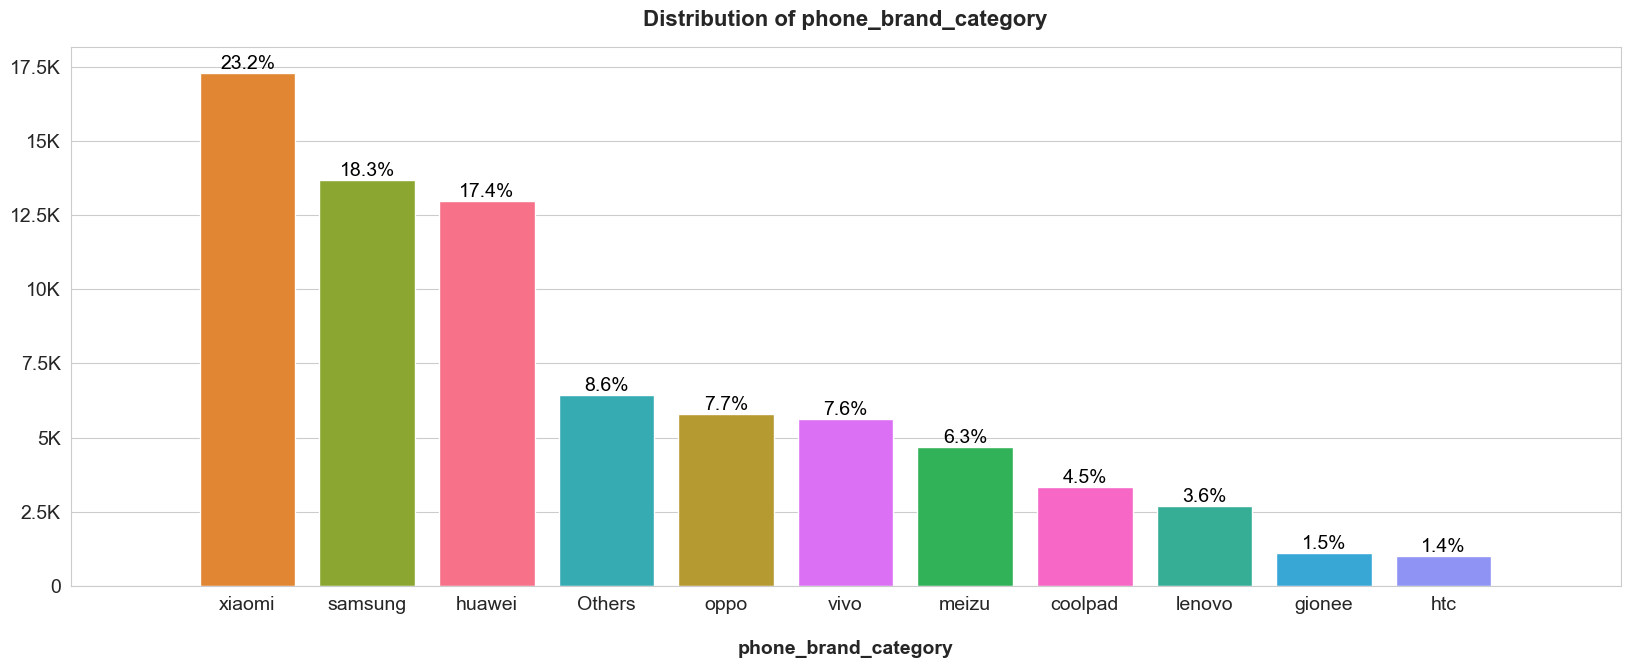

In [130]:
# Generates a count plot for the 'phone_brand_category' column to visualize the distribution of phone brand categories.
count_plot(train_mobile_brand, 'phone_brand_category')

In [131]:
# Returns the number of unique device models in the 'device_model' column.
train_mobile_brand['device_model'].nunique()

1438

In [132]:
# Drops multiple columns from the DataFrame, ignoring any errors if a column does not exist.
train_mobile_brand = train_mobile_brand.drop(columns=['gender', 'age', 'group_train', 'device_model', 'phone_brand'], errors='ignore')

In [133]:
# Converts the 'phone_brand_category' column into multiple binary columns (one-hot encoding) and updates the DataFrame.
train_mobile_brand = pd.get_dummies(train_mobile_brand, columns=['phone_brand_category'])

In [134]:
# Randomly samples and returns 10 rows from the DataFrame for a quick overview.
train_mobile_brand.sample(10)

device_id  phone_brand_category_Others  \
63184 -5820212615102200000                        False   
54573  8749952834949880000                        False   
63308  5304228903976830000                         True   
51181 -4240753775439690000                         True   
39508 -1525412815880790000                        False   
21435  6876811576852770000                        False   
9037  -8488067985183720000                        False   
12116  5563522700802590000                        False   
22038 -8300989452721720000                        False   
36202 -3924269410900640000                        False   

       phone_brand_category_coolpad  phone_brand_category_gionee  \
63184                         False                        False   
54573                         False                        False   
63308                         False                        False   
51181                         False                        False   
39508                         False                        False   
21435                         False                        False   
9037                          False                        False   
12116                          True                        False   
22038                         False                        False   
36202                         False                        False   

       phone_brand_category_htc  phone_brand_category_huawei  \
63184                     False                         True   
54573                     False                        False   
63308                     False                        False   
51181                     False                        False   
39508                     False                        False   
21435                     False                        False   
9037                      False                        False   
12116                     False                        False   
22038                     False                        False   
36202                     False                         True   

       phone_brand_category_lenovo  phone_brand_category_meizu  \
63184                        False                       False   
54573                        False                       False   
63308                        False                       False   
51181                        False                       False   
39508                        False                        True   
21435                        False                        True   
9037                         False                       False   
12116                        False                       False   
22038                        False                       False   
36202                        False                       False   

       phone_brand_category_oppo  phone_brand_category_samsung  \
63184                      False                         False   
54573                      False                         False   
63308                      False                         False   
51181                      False                         False   
39508                      False                         False   
21435                      False                         False   
9037                       False                         False   
12116                      False                         False   
22038                      False                         False   
36202                      False                         False   

       phone_brand_category_vivo  phone_brand_category_xiaomi  
63184                      False                        False  
54573                       True                        False  
63308                      False                        False  
51181                      False                        False  
39508                      False                        False  
21435                      False                        False  
9037       

### Notes:
- 39% of the app users are active
- Almost 71% of the users are males
- 27% of the users are in the age range of 25 to 29
- Majority of the users are from East China
- The first week of the month saw 86% of the users
- Majority (30%) of the users were in evening, and the least at night (12%)
- Majority (23%) of the users used Xiaomi phones

## Merging Dataset

In [135]:
try:
    data = pd.read_parquet('data.parquet')

except FileNotFoundError:
    """
    Handle case where 'data.parquet' is not found.

    Merges train_mobile and train_events on 'device_id'.
    """
    data = pd.merge(train_mobile_brand, event_data, on='device_id', how='inner')

    # Merges the result with app_events on 'event_id'.
    data = pd.merge(data, app_events, on='event_id', how='inner')

    # Creates a pivot table from the merged data to get the maximum 'is_active' for each 'event_id'.
    is_active = data.pivot_table(
        index='event_id',
        values='is_active',
        aggfunc='max'
    )

    # Drops the 'is_active' column and makes a copy.
    data = data.drop(columns=['is_active']).copy()

    # Identifies columns with 'id' in their name but not 'event_id'.
    id_columns = data.columns[(data.columns.str.contains('id')) & (~data.columns.str.contains('event_id'))]

    """
    Drops the identified ID columns and makes a copy.
    Errors are ignored if any column is not found.
    """
    data = data.drop(columns=id_columns, errors='ignore').copy()

    # Removes duplicate rows from the DataFrame.
    data = data.drop_duplicates()

    # Sets 'event_id' as the index of the DataFrame.
    data = data.set_index('event_id')

    # Merges the previously created pivot table with the main DataFrame on 'event_id'.
    data = data.merge(is_active, on='event_id', how='left')

    # # Join metadata to df using app_id
    # data = pd.merge(data, app_events_metadata, on='app_id', how='inner')

    # Exports the final DataFrame to 'data.parquet' with index set as True.
    data.to_parquet('data.parquet', index=True)

In [136]:
# Get the shape of the data, which returns a tuple representing the dimensions of the data.
data.shape

(358223, 46)

In [137]:
"""
Generate a list of column names that are not numeric.
"""

# Use a list comprehension to iterate over each column in the dataframe 'data'
# and check if the column's data type is not numeric using pd.api.types.is_numeric_dtype.
# If the condition is true, include the column name in the resulting list.
[col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]

[]

In [138]:
# Return a sequence (Index object) of the column names in the DataFrame `data`.
data.columns

Index(['phone_brand_category_Others', 'phone_brand_category_coolpad',
       'phone_brand_category_gionee', 'phone_brand_category_htc',
       'phone_brand_category_huawei', 'phone_brand_category_lenovo',
       'phone_brand_category_meizu', 'phone_brand_category_oppo',
       'phone_brand_category_samsung', 'phone_brand_category_vivo',
       'phone_brand_category_xiaomi', 'gender', 'age_group_20 to 24',
       'age_group_25 to 29', 'age_group_30 to 34', 'age_group_35 to 39',
       'age_group_40 to 44', 'age_group_45 to 49', 'age_group_50 to 54',
       'age_group_55 to 60', 'age_group_Above 60', 'age_group_Less than 20',
       'cluster_Cluster 0', 'cluster_Cluster 1', 'cluster_Cluster 2',
       'cluster_Cluster 3', 'cluster_Cluster 4', 'cluster_Cluster 5',
       'cluster_Cluster 6', 'cluster_Cluster 7', 'cluster_Cluster 8',
       'cluster_Cluster 9', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 

In [139]:
# Randomly sample and return 10 rows from the DataFrame `data`.
data.sample(10)

phone_brand_category_Others  phone_brand_category_coolpad  \
event_id                                                               
3133787.0                        False                         False   
742391.0                         False                         False   
2335403.0                        False                         False   
61747.0                          False                         False   
635627.0                         False                         False   
287246.0                         False                         False   
1468031.0                        False                          True   
709776.0                         False                         False   
903657.0                         False                         False   
2014579.0                        False                         False   

           phone_brand_category_gionee  phone_brand_category_htc  \
event_id                                                           
3133787.0                        False                     False   
742391.0                         False                     False   
2335403.0                        False                     False   
61747.0                          False                     False   
635627.0                         False                     False   
287246.0                         False                     False   
1468031.0                        False                     False   
709776.0                         False                     False   
903657.0                         False                      True   
2014579.0                        False                     False   

           phone_brand_category_huawei  phone_brand_category_lenovo  \
event_id                                                              
3133787.0                         True                        False   
742391.0                         False                        False   
2335403.0                         True                        False   
61747.0                          False                        False   
635627.0                          True                        False   
287246.0                         False                        False   
1468031.0                        False                        False   
709776.0                         False                        False   
903657.0                         False                        False   
2014579.0                         True                        False   

           phone_brand_category_meizu  phone_brand_category_oppo  \
event_id                                                           
3133787.0                       False                      False   
742391.0                        False                      False   
2335403.0                       False                      False   
61747.0                         False                      False   
635627.0                        False                      False   
287246.0                        False                      False   
1468031.0                       False                      False   
709776.0                        False                      False   
903657.0                        False                      False   
2014579.0                       False                      False   

           phone_brand_category_samsung  phone_brand_category_vivo  ...  \
event_id                                                            ...   
3133787.0                         False                      False  ...   
742391.0                           True                      False  ...   
2335403.0                         False                      False  ...   
61747.0                           False                      False  ...   
635627.0                          False                      False  ...   
287246.0                           True                      False  ...   
1468031.0                         False                    

## Model Building

### Scenario 1 - Gender Prediction

#### Target variable distribution

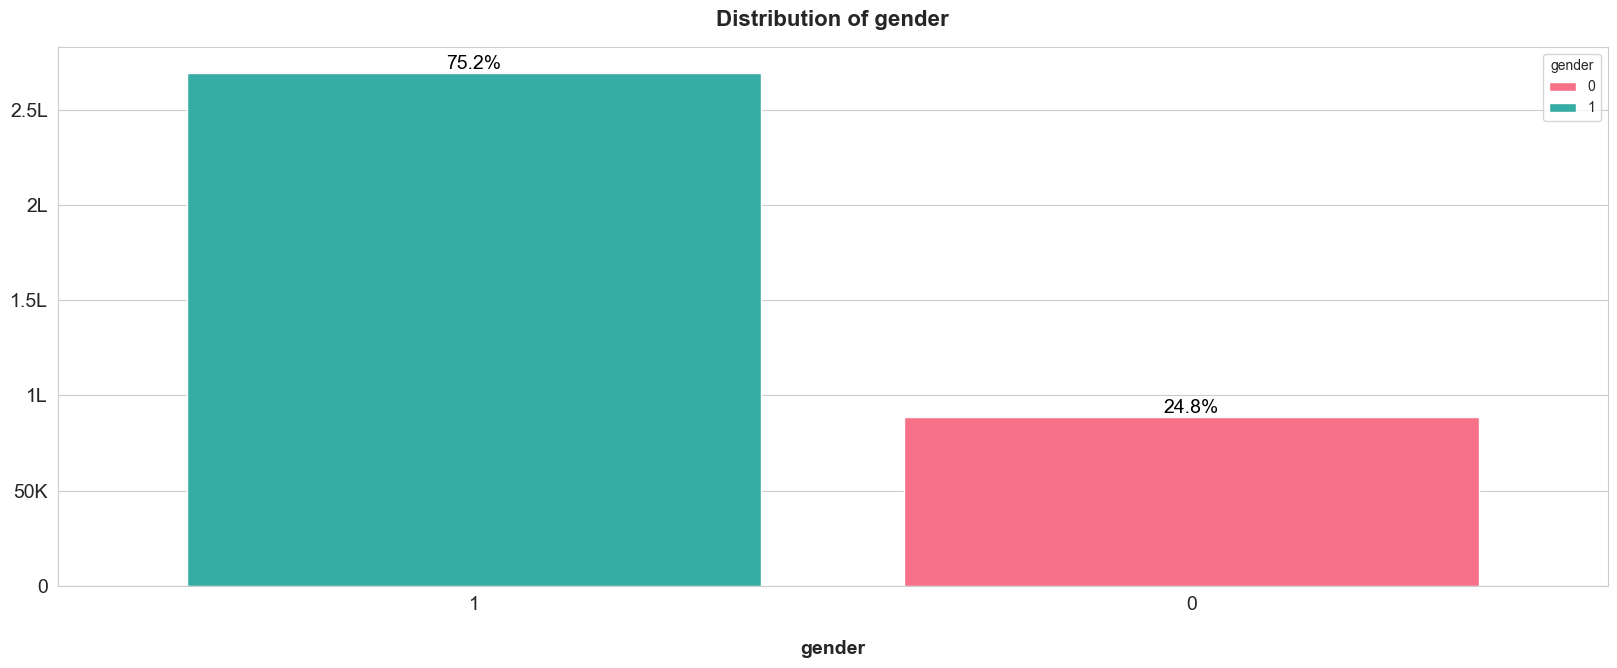

In [140]:
# Generate a count plot for the 'gender' column in the DataFrame `data`.
count_plot(data, 'gender')

In [141]:
try:
    # Try to read preprocessed gender data from a Parquet file
    data_gender = pd.read_parquet('data_gender_smote.parquet')

except FileNotFoundError:
    # If the file is not found, apply SMOTE to the 'gender' column and save the result
    data_gender = apply_smote(data, 'gender')
    data_gender.to_parquet('data_gender_smote.parquet', index=False)

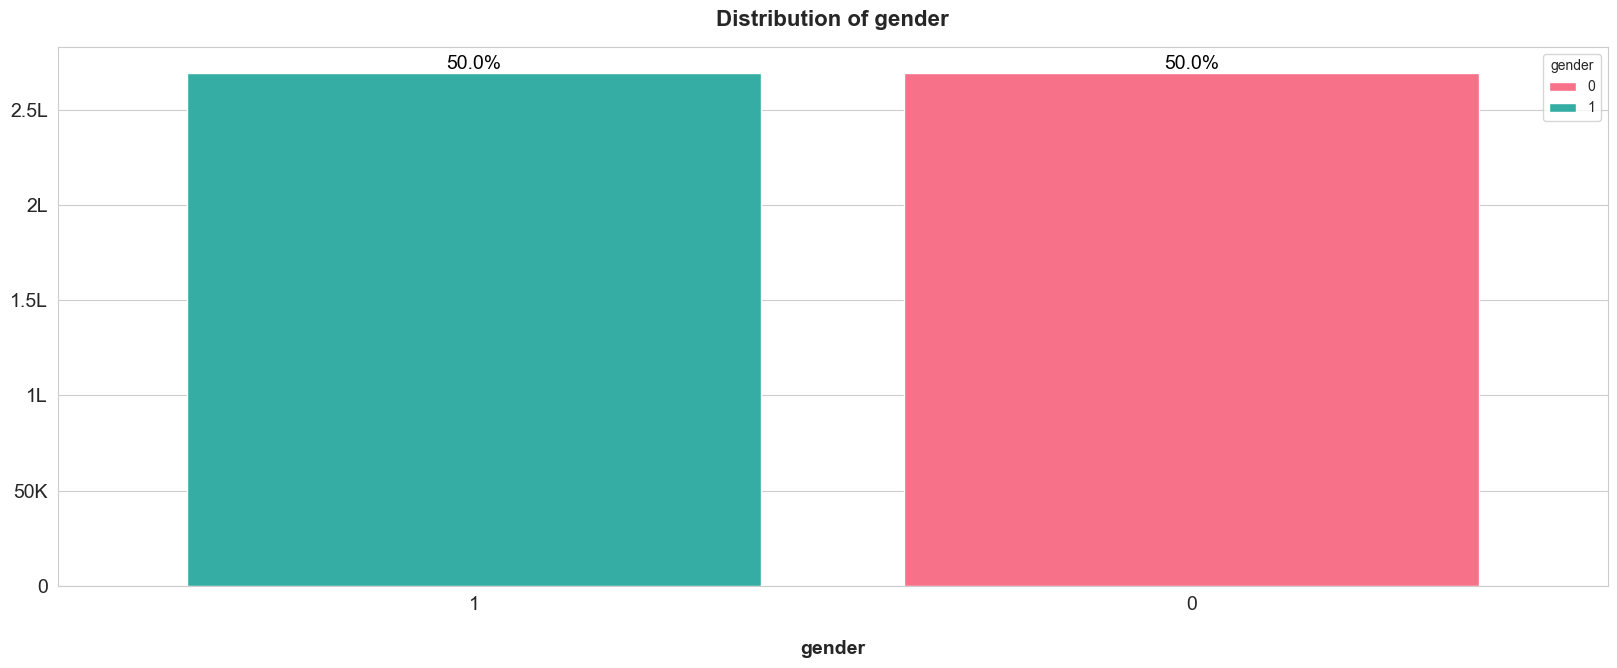

In [142]:
# Generate a count plot for the 'gender' column in the DataFrame `data_gender`.
count_plot(data_gender, 'gender')

In [143]:
# Export the DataFrame `data_gender` to a Parquet file named 'data_gender.parquet'.
data_gender.to_parquet('data_gender.parquet', index=False)

In [144]:
# Read the preprocessed gender data from a Parquet file named 'data_gender.parquet' and store it in `data_gender`.
data_gender = pd.read_parquet('data_gender.parquet')

#### Data Splitting

In [145]:
# Separate the features (X) from the target variable (y)
X = data_gender.drop(columns=['gender'])
y = data_gender['gender']

In [146]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocess Data

In [147]:
# Initialize a StandardScaler object to scale features by removing the mean and scaling to unit variance.
scaler = StandardScaler()

# Fit the scaler to the training data and transform it, storing the scaled version in X_train_scaled.
X_train_scaled = scaler.fit_transform(X_train)

# Use the already fitted scaler to transform the test data, storing the scaled version in X_test_scaled.
X_test_scaled = scaler.transform(X_test)

#### Build Base Models (Logistic Regression and Random Forest):

In [148]:
# Initialize a Logistic Regression model with a random state of 42 for reproducibility.
log_reg = LogisticRegression(random_state=42)

# Initialize a Random Forest classifier with 100 estimators and a random state of 42 for reproducibility.
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [149]:
# Train the Logistic Regression model using the scaled training data and corresponding labels.
log_reg.fit(X_train_scaled, y_train)

# Train the Random Forest classifier using the scaled training data and corresponding labels.
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

#### Stacking Models

In [150]:
# Create a list of models to be used in stacking. The list contains instances of LogisticRegression and RandomForestClassifier.
models = [log_reg, rf]

In [151]:
# Perform stacking with 4 folds. This uses the defined models to create a stacked training set (S_train) and a stacked test set (S_test).
S_train, S_test = stacking(models, X_train_scaled, y_train, X_test_scaled, regression=False, mode='oof_pred_bag', metric='accuracy', n_folds=4, shuffle=True)

#### Meta-Learner (XGBoost)

In [152]:
# Initialize an XGBoost classifier with 100 estimators, a learning rate of 0.1, and a random state of 42 for reproducibility.
xgb_scenario_1 = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [153]:
# Train the XGBoost classifier (meta-learner) using the stacked training data (S_train) and corresponding labels (y_train).
xgb_scenario_1.fit(S_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

##### Accuracy

In [154]:
# Use the trained meta-learner to predict the labels for the stacked test set (S_test).
y_pred = xgb_scenario_1.predict(S_test)

# Print the accuracy of the predictions.
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Print the precision of the predictions.
print(f'Precision: {precision_score(y_test, y_pred)}')

# Print the recall of the predictions.
print(f'Recall: {recall_score(y_test, y_pred)}')

# Print the F1 score of the predictions.
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.7073365379261707
Precision: 0.7256738099525781
Recall: 0.6704316480266198
F1 Score: 0.6969597970635714


##### Confusion Matrix and Classification Report

In [155]:
# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[39957 13710]
 [17828 36267]]

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.74      0.72     53667
           1       0.73      0.67      0.70     54095

    accuracy                           0.71    107762
   macro avg       0.71      0.71      0.71    107762
weighted avg       0.71      0.71      0.71    107762



##### ROC-AUC Curve

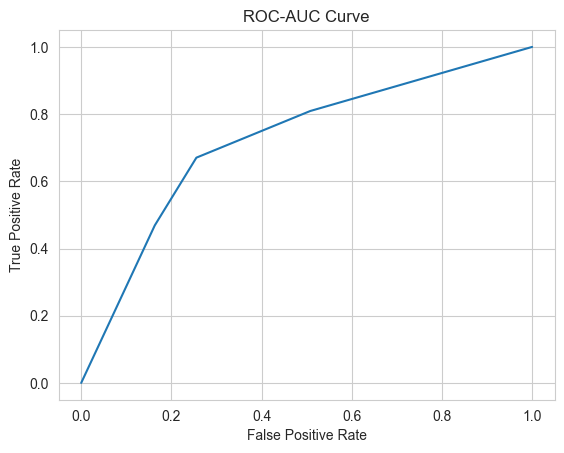

ROC-AUC Score: 0.7227407312348639


In [156]:
# Predict probabilities for the positive class using XGBoost model
y_proba = xgb_scenario_1.predict_proba(S_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Label the x-axis as False Positive Rate
plt.xlabel('False Positive Rate')

# Label the y-axis as True Positive Rate
plt.ylabel('True Positive Rate')

# Title of the plot: ROC-AUC Curve
plt.title('ROC-AUC Curve')

# Display the plot
plt.show()

# Print the ROC-AUC score
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba)}")

### Scenario 1 - Age Prediction

#### Data Preparation

In [157]:
# Select columns where the name contains the word 'age'
age_columns = data.columns[data.columns.str.contains('age')]

# Display the selected columns
age_columns

Index(['age_group_20 to 24', 'age_group_25 to 29', 'age_group_30 to 34',
       'age_group_35 to 39', 'age_group_40 to 44', 'age_group_45 to 49',
       'age_group_50 to 54', 'age_group_55 to 60', 'age_group_Above 60',
       'age_group_Less than 20'],
      dtype='object')

In [158]:
# Display a random sample of 5 rows from the DataFrame
data.sample(5)

phone_brand_category_Others  phone_brand_category_coolpad  \
event_id                                                               
953528.0                          True                         False   
2587085.0                        False                         False   
2307128.0                        False                         False   
929098.0                         False                         False   
3239514.0                        False                         False   

           phone_brand_category_gionee  phone_brand_category_htc  \
event_id                                                           
953528.0                         False                     False   
2587085.0                        False                     False   
2307128.0                        False                     False   
929098.0                         False                     False   
3239514.0                        False                     False   

           phone_brand_category_huawei  phone_brand_category_lenovo  \
event_id                                                              
953528.0                         False                        False   
2587085.0                        False                         True   
2307128.0                         True                        False   
929098.0                          True                        False   
3239514.0                        False                        False   

           phone_brand_category_meizu  phone_brand_category_oppo  \
event_id                                                           
953528.0                        False                      False   
2587085.0                       False                      False   
2307128.0                       False                      False   
929098.0                        False                      False   
3239514.0                       False                      False   

           phone_brand_category_samsung  phone_brand_category_vivo  ...  \
event_id                                                            ...   
953528.0                          False                      False  ...   
2587085.0                         False                      False  ...   
2307128.0                         False                      False  ...   
929098.0                          False                      False  ...   
3239514.0                         False                       True  ...   

           weekday_Tuesday  weekday_Wednesday  week_of_month_Week 1  \
event_id                                                              
953528.0             False               True                  True   
2587085.0            False              False                  True   
2307128.0            False              False                  True   
929098.0             False              False                  True   
3239514.0             True              False                  True   

           week_of_month_Week 2  week_of_month_Week 5  \
event_id                                                
953528.0                  False                 False   
2587085.0                 False                 False   
2307128.0                 False                 False   
929098.0                  False                 False   
3239514.0                 False                 False   

           Hour_Category_Afternoon  Hour_Category_Evening  \
event_id                                                    
953528.0                     False                  False   
2587085.0                     True                  False   
2307128.0                    False                  False   
929098.0                      True                  False   
3239514.0                     True                  False   

           Hour_Category_Morning  Hour_Category_Night  is_active  
event_id                                                          
953528.0                    True                False          1  
2

In [159]:
# Melt the DataFrame to convert 'age' columns into long format
age_columns = pd.melt(data[age_columns], ignore_index=False)

In [160]:
# Reset the index of the melted DataFrame
age_columns = age_columns.reset_index()

In [161]:
# Filter rows where the 'value' is 1 and keep only 'event_id' and 'variable' columns, then remove duplicates
age_columns = age_columns.loc[age_columns['value'] == 1, ['event_id', 'variable']].drop_duplicates()

In [162]:
# Display the first few rows of the age_columns DataFrame to check its content.
age_columns.head()

event_id            variable
89  2546766.0  age_group_20 to 24
90   943964.0  age_group_20 to 24
91  2734660.0  age_group_20 to 24
92  2719061.0  age_group_20 to 24
93  2672259.0  age_group_20 to 24

In [163]:
# Reset the index of the 'data' DataFrame and merge it with the 'age_columns' DataFrame on the 'event_id' column using a left join.
data_age = data.reset_index().merge(age_columns, on='event_id', how='left')

In [164]:
# Get the number of rows and columns in the original 'data' DataFrame.
data.shape

(358223, 46)

In [165]:
# Get the number of rows and columns in the merged 'data_age' DataFrame.
data_age.shape

(358223, 48)

In [166]:
# Set the 'event_id' column as the index of the 'data_age' DataFrame and create a copy to avoid modifying the original DataFrame.
data_age = data_age.set_index('event_id').copy()

In [167]:
# Drop all columns from 'data_age' that contain the word 'age' in their names and create a copy to avoid modifying the original DataFrame.
data_age = data_age.drop(columns=data.columns[data.columns.str.contains('age')]).copy()

In [168]:
# Rename the 'variable' column to 'age_group' and create a copy to avoid modifying the original DataFrame.
data_age = data_age.rename(columns={'variable': 'age_group'}).copy()

In [169]:
# Randomly sample 10 rows from the 'data_age' DataFrame to check a subset of its content.
data_age.sample(10)

phone_brand_category_Others  phone_brand_category_coolpad  \
event_id                                                               
1017794.0                        False                         False   
999149.0                         False                         False   
468069.0                         False                         False   
208200.0                         False                         False   
1214540.0                        False                         False   
3026631.0                        False                         False   
2516547.0                        False                         False   
2351428.0                        False                         False   
1711827.0                        False                         False   
1105845.0                        False                         False   

           phone_brand_category_gionee  phone_brand_category_htc  \
event_id                                                           
1017794.0                        False                     False   
999149.0                         False                     False   
468069.0                         False                     False   
208200.0                         False                     False   
1214540.0                        False                     False   
3026631.0                        False                     False   
2516547.0                        False                     False   
2351428.0                        False                     False   
1711827.0                        False                     False   
1105845.0                        False                     False   

           phone_brand_category_huawei  phone_brand_category_lenovo  \
event_id                                                              
1017794.0                        False                        False   
999149.0                         False                        False   
468069.0                          True                        False   
208200.0                         False                        False   
1214540.0                         True                        False   
3026631.0                        False                        False   
2516547.0                         True                        False   
2351428.0                        False                        False   
1711827.0                        False                        False   
1105845.0                         True                        False   

           phone_brand_category_meizu  phone_brand_category_oppo  \
event_id                                                           
1017794.0                       False                      False   
999149.0                        False                      False   
468069.0                        False                      False   
208200.0                        False                      False   
1214540.0                       False                      False   
3026631.0                       False                      False   
2516547.0                       False                      False   
2351428.0                       False                      False   
1711827.0                       False                      False   
1105845.0                       False                      False   

           phone_brand_category_samsung  phone_brand_category_vivo  ...  \
event_id                                                            ...   
1017794.0                          True                      False  ...   
999149.0                          False                      False  ...   
468069.0                          False                      False  ...   
208200.0                           True                      False  ...   
1214540.0                         False                      False  ...   
3026631.0                         False                      False  ...   
2516547.0                         False                    

#### Target Variable distribution

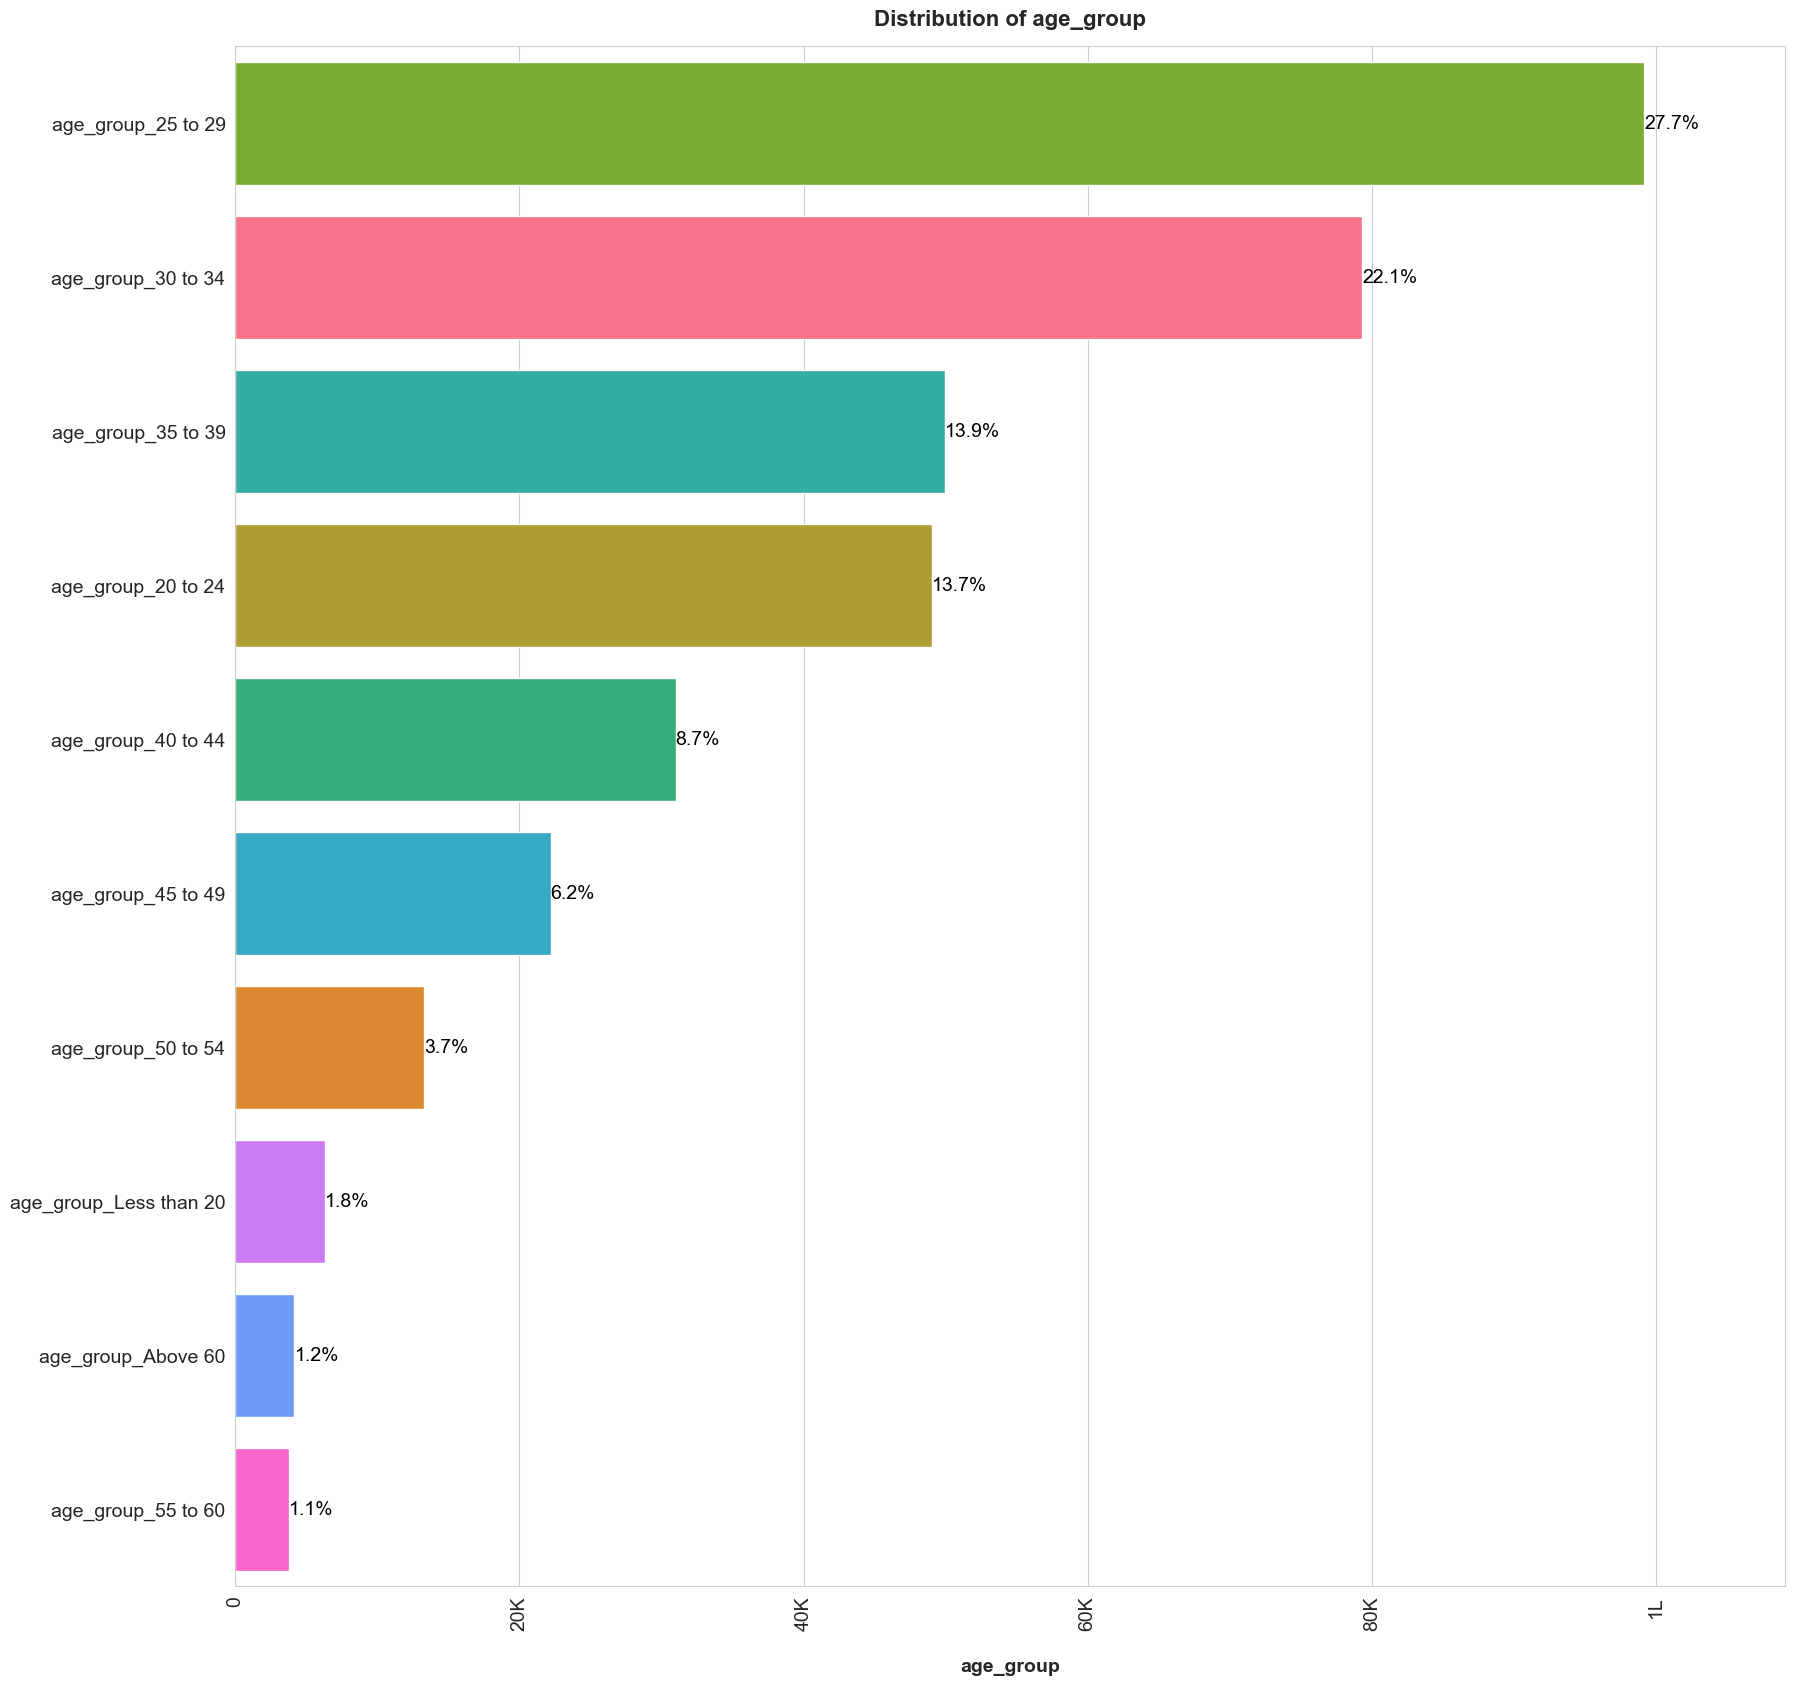

In [170]:
# Create a count plot for the 'age_group' column in the 'data_age' DataFrame with rotated labels and plot.
count_plot(data_age, 'age_group', rotate_label=True, rotate_plot=True)

In [171]:
try:
    # Attempt to read the preprocessed data from a Parquet file
    data_age_final = pd.read_parquet('data_age_final_smote.parquet')

except FileNotFoundError:
    # Apply SMOTE and save the result if the file is not found
    data_age_final = apply_smote(data_age, 'age_group')
    data_age_final.to_parquet('data_age_final_smote.parquet', index=False)

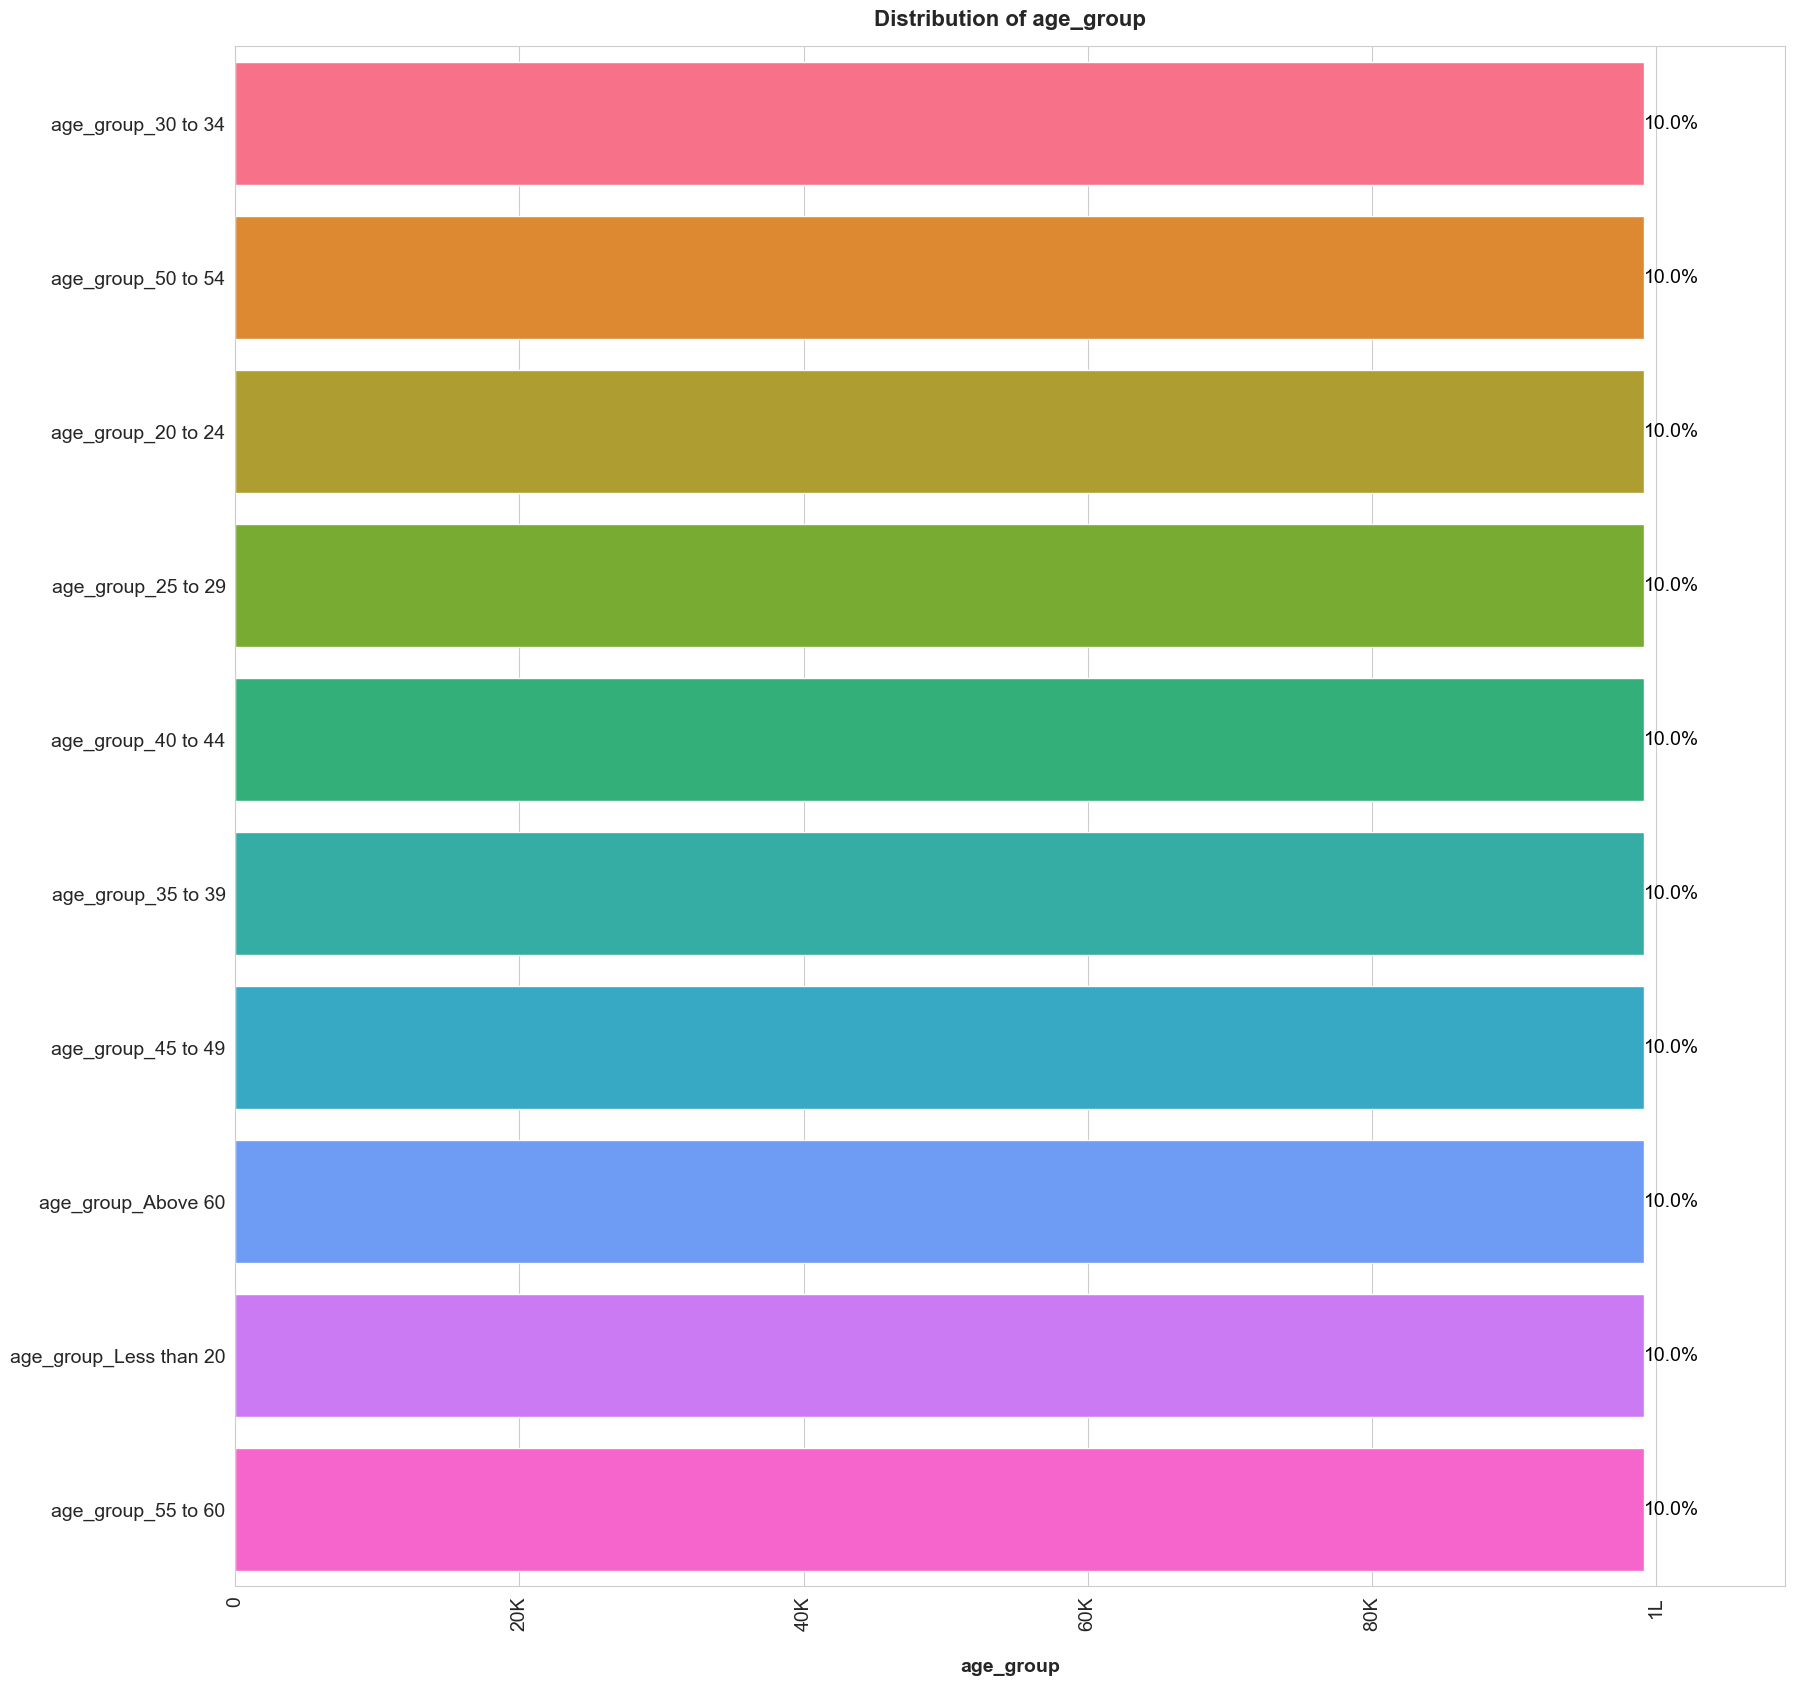

In [172]:
# Create a count plot for the age_group column in the data_age_final DataFrame
count_plot(data_age_final, 'age_group', rotate_plot=True, rotate_label=True)

In [173]:
# Save the DataFrame as a Parquet file.
data_age_final.to_parquet('data_age_final.parquet', index=False)

In [174]:
# Load the Parquet file into a DataFrame.
data_age_final = pd.read_parquet('data_age_final.parquet')

#### Mapping Target Variables

In [175]:
# Converts unique 'age_group' values from a DataFrame into a list.
data_age_final['age_group'].drop_duplicates().to_list()

['age_group_30 to 34',
 'age_group_50 to 54',
 'age_group_20 to 24',
 'age_group_25 to 29',
 'age_group_40 to 44',
 'age_group_35 to 39',
 'age_group_45 to 49',
 'age_group_Above 60',
 'age_group_Less than 20',
 'age_group_55 to 60']

In [176]:
# Map age group categories to numerical indices.
map_age = {
    'age_group_Less than 20': 0,
    'age_group_20 to 24': 1,
    'age_group_25 to 29': 2,
    'age_group_30 to 34': 3,
    'age_group_35 to 39': 4,
    'age_group_40 to 44': 5,
    'age_group_45 to 49': 6,
    'age_group_50 to 54': 7,
    'age_group_55 to 60': 8,
    'age_group_Above 60': 9,
}

#### Data Splitting

In [177]:
# Separate features and target variable
X = data_age_final.drop('age_group', axis=1)
y = data_age_final['age_group'].map(map_age)

In [178]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Preprocess Data

In [179]:
# Initialize the StandardScaler object.
scaler = StandardScaler()

# Fit the scaler to the training data and transform it.
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the already fitted scaler.
X_test_scaled = scaler.transform(X_test)

#### Define Base Models

In [180]:
# Define a list of base models with their respective names and instances.
base_models = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100))
]

#### Stacking Classifier with XGBoost as Meta-Learner

In [181]:
# Initialize a StackingClassifier with specified base and meta classifiers.
stacking_model = StackingClassifier(
    classifiers=[LogisticRegression(), RandomForestClassifier()],
    meta_classifier=XGBClassifier(learning_rate=0.1, n_estimators=100),
    use_probas=True,
    average_probas=True
)

#### Training the Model

In [182]:
# Fit the StackingClassifier to the training data.
stacking_model.fit(X_train, y_train)

StackingClassifier(average_probas=True,
                   classifiers=[LogisticRegression(), RandomForestClassifier()],
                   meta_classifier=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric=None,
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   use_probas=True)

#### Making Predictions

In [183]:
# Predict the target values for the test dataset using the fitted StackingClassifier.
y_pred = stacking_model.predict(X_test_scaled)

#### Evaluating the Model

In [184]:
# Calculate and print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate and print weighted precision
print(f'Precision: {precision_score(y_test, y_pred, average='weighted')}')

# Calculate and print weighted recall
print(f'Recall: {recall_score(y_test, y_pred, average='weighted')}')

# Calculate and print weighted F1 Score
print(f'F1 Score: {f1_score(y_test, y_pred, average='weighted')}')

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.22050578792401082
Precision: 0.2555036164674921
Recall: 0.22050578792401082
F1 Score: 0.18995910142562658

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.50      0.35     19676
           1       0.28      0.11      0.15     20075
           2       0.16      0.09      0.12     19885
           3       0.20      0.06      0.09     19917
           4       0.25      0.06      0.10     19656
           5       0.26      0.14      0.19     19825
           6       0.35      0.10      0.15     19844
           7       0.36      0.13      0.20     19862
           8       0.25      0.32      0.28     19917
           9       0.16      0.69      0.27     19687

    accuracy                           0.22    198344
   macro avg       0.26      0.22      0.19    198344
weighted avg       0.26      0.22      0.19    198344


Confusion Matrix:
[[ 9870   525   656   233   818   453   357   427  2141  4196]
 [ 5301  2129  11

<Figure size 2000x700 with 0 Axes>

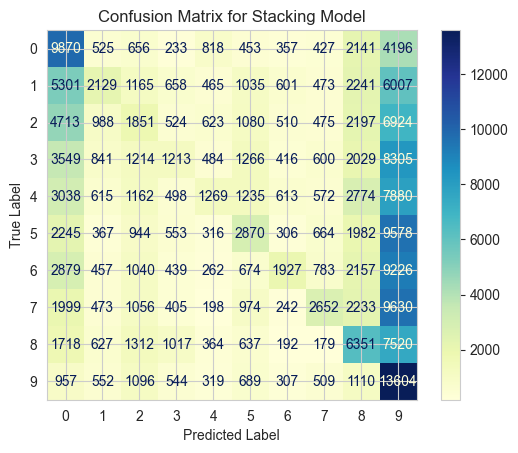

In [185]:
# Call the function to plot the confusion matrix
plot_confusion_matrix_stacked(stacking_model, X_test_scaled, y_test)

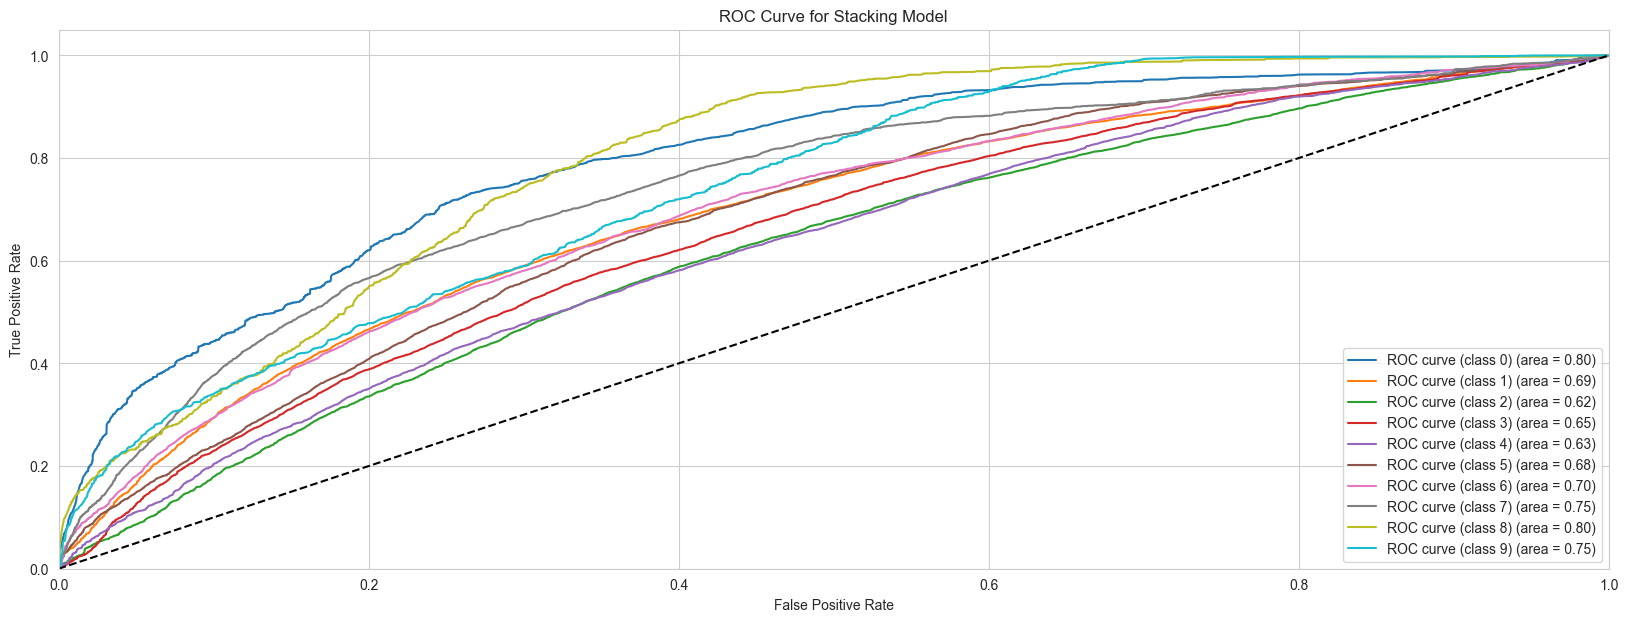

In [186]:
# Call the function to plot the ROC curve
plot_roc_curve_stacked(stacking_model, X_test_scaled, y_test)

### Scenario 2 - Age and Gender Prediction

#### Data Preparation

In [187]:
# Display the first 5 rows of the DataFrame
train_mobile_brand.head()

device_id  phone_brand_category_Others  \
0 -7548291590301750000                        False   
1  6943568600617760000                        False   
2  5441349705980020000                        False   
3 -5393876656119450000                        False   
4  4543988487649880000                        False   

   phone_brand_category_coolpad  phone_brand_category_gionee  \
0                         False                        False   
1                         False                        False   
2                         False                        False   
3                         False                        False   
4                         False                        False   

   phone_brand_category_htc  phone_brand_category_huawei  \
0                     False                         True   
1                     False                        False   
2                     False                        False   
3                     False                        False   
4                     False                        False   

   phone_brand_category_lenovo  phone_brand_category_meizu  \
0                        False                       False   
1                        False                       False   
2                        False                       False   
3                        False                       False   
4                        False                       False   

   phone_brand_category_oppo  phone_brand_category_samsung  \
0                      False                         False   
1                      False                         False   
2                       True                         False   
3                      False                         False   
4                      False                          True   

   phone_brand_category_vivo  phone_brand_category_xiaomi  
0                      False                        False  
1                      False                         True  
2                      False                        False  
3                      False                         True  
4                      False                        False

In [188]:
# Display the first 5 rows of the DataFrame
event_data.head()

device_id  gender   event_id  age_group_20 to 24  \
0 -7548291590301750000       1  2369465.0               False   
1 -7548291590301750000       1  1080869.0               False   
2 -7548291590301750000       1  1079338.0               False   
3 -7548291590301750000       1  1078881.0               False   
4 -7548291590301750000       1  1068711.0               False   

   age_group_25 to 29  age_group_30 to 34  age_group_35 to 39  \
0               False                True               False   
1               False                True               False   
2               False                True               False   
3               False                True               False   
4               False                True               False   

   age_group_40 to 44  age_group_45 to 49  age_group_50 to 54  ...  \
0               False               False               False  ...   
1               False               False               False  ...   
2               False               False               False  ...   
3               False               False               False  ...   
4               False               False               False  ...   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  week_of_month_Week 1  \
0             False             True              False                  True   
1             False             True              False                  True   
2             False            False               True                  True   
3             False            False               True                  True   
4             False             True              False                  True   

   week_of_month_Week 2  week_of_month_Week 5  Hour_Category_Afternoon  \
0                 False                 False                     True   
1                 False                 False                    False   
2                 False                 False                    False   
3                 False                 False                    False   
4                 False                 False                     True   

   Hour_Category_Evening  Hour_Category_Morning  Hour_Category_Night  
0                  False                  False                False  
1                  False                   True                False  
2                  False                  False                 True  
3                  False                  False                 True  
4                  False                  False                False  

[5 rows x 37 columns]

In [189]:
# Merge the DataFrames on 'device_id' using an inner join
data_2 = pd.merge(train_mobile_brand, event_data, on='device_id', how='inner')

In [190]:
# Set 'event_id' as the index for the DataFrame data_2
data_2 = data_2.set_index('event_id')

In [191]:
# Selects columns from the DataFrame `data_2` whose names contain the word 'age'.
age_columns = data_2.columns[data_2.columns.str.contains('age')]
age_columns

Index(['age_group_20 to 24', 'age_group_25 to 29', 'age_group_30 to 34',
       'age_group_35 to 39', 'age_group_40 to 44', 'age_group_45 to 49',
       'age_group_50 to 54', 'age_group_55 to 60', 'age_group_Above 60',
       'age_group_Less than 20'],
      dtype='object')

In [192]:
# Melts the DataFrame `data_2` to long format, selecting only the columns whose names contain 'age'.
age_columns = pd.melt(data_2[age_columns], ignore_index=False)

In [193]:
# Resets the index of the DataFrame `age_columns`, creating a new numerical index starting from 0.
age_columns = age_columns.reset_index()

In [194]:
# Filters the DataFrame to include only rows where 'value' is equal to 1 and selects the 'event_id' and 'variable' columns.
# Then removes any duplicate rows based on the selected columns.
age_columns = age_columns.loc[age_columns['value'] == 1, ['event_id', 'variable']].drop_duplicates()

In [195]:
# Displays the first few rows of the DataFrame `age_columns` to check its contents.
age_columns.head()

event_id            variable
407  2546766.0  age_group_20 to 24
408  1067121.0  age_group_20 to 24
409   943964.0  age_group_20 to 24
410  2734660.0  age_group_20 to 24
411  2719061.0  age_group_20 to 24

In [196]:
# Resets the index of the DataFrame `data_2`, creating a new numerical index starting from 0.
# Then merges it with the `age_columns` DataFrame on the 'event_id' column, using a left join to keep all rows from `data_2`.
data_2 = data_2.reset_index().merge(age_columns, on='event_id', how='left')

In [197]:
# Drops all columns from `data_2` that contain the word 'age' in their names.
# The `.copy()` method is used to ensure changes do not affect the original DataFrame.
data_2 = data_2.drop(columns=data_2.columns[data_2.columns.str.contains('age')]).copy()

In [198]:
# Renames the 'variable' column to 'age_group' in the DataFrame `data_2`.
# The `.copy()` method is used to ensure changes do not affect the original DataFrame.
data_2 = data_2.rename(columns={'variable': 'age_group'}).copy()

In [199]:
# Checks for duplicate rows in the DataFrame `data_2` and returns the count of such duplicates.
data_2.duplicated().sum()

0

In [200]:
# Filters the DataFrame `data_2` to return only the rows that are duplicated.
data_2[data_2.duplicated()]

Empty DataFrame
Columns: [event_id, device_id, phone_brand_category_Others, phone_brand_category_coolpad, phone_brand_category_gionee, phone_brand_category_htc, phone_brand_category_huawei, phone_brand_category_lenovo, phone_brand_category_meizu, phone_brand_category_oppo, phone_brand_category_samsung, phone_brand_category_vivo, phone_brand_category_xiaomi, gender, cluster_Cluster 0, cluster_Cluster 1, cluster_Cluster 2, cluster_Cluster 3, cluster_Cluster 4, cluster_Cluster 5, cluster_Cluster 6, cluster_Cluster 7, cluster_Cluster 8, cluster_Cluster 9, weekday_Friday, weekday_Monday, weekday_Saturday, weekday_Sunday, weekday_Thursday, weekday_Tuesday, weekday_Wednesday, week_of_month_Week 1, week_of_month_Week 2, week_of_month_Week 5, Hour_Category_Afternoon, Hour_Category_Evening, Hour_Category_Morning, Hour_Category_Night, age_group]
Index: []

[0 rows x 39 columns]

In [201]:
# Drops all duplicate rows from the DataFrame `data_2` and ensures changes do not affect the original DataFrame.
data_2 = data_2.drop_duplicates().copy()

In [202]:
# Checks for missing values in each column of the DataFrame `data_2`, sums them up, and sorts the result in descending order.
data_2.isnull().sum().sort_values(ascending=False)

event_id                        0
weekday_Tuesday                 0
cluster_Cluster 8               0
cluster_Cluster 9               0
weekday_Friday                  0
weekday_Monday                  0
weekday_Saturday                0
weekday_Sunday                  0
weekday_Thursday                0
weekday_Wednesday               0
cluster_Cluster 6               0
week_of_month_Week 1            0
week_of_month_Week 2            0
week_of_month_Week 5            0
Hour_Category_Afternoon         0
Hour_Category_Evening           0
Hour_Category_Morning           0
Hour_Category_Night             0
cluster_Cluster 7               0
cluster_Cluster 5               0
device_id                       0
phone_brand_category_oppo       0
phone_brand_category_Others     0
phone_brand_category_coolpad    0
phone_brand_category_gionee     0
phone_brand_category_htc        0
phone_brand_category_huawei     0
phone_brand_category_lenovo     0
phone_brand_category_meizu      0
phone_brand_ca

In [203]:
# Groups the DataFrame `data_2` by 'device_id' and counts the number of 'event_id' for each device.
# Resets the index to convert the result into a DataFrame and renames the columns appropriately.
app_usage = data_2.groupby('device_id')['event_id'].count().reset_index()
app_usage.columns = ['device_id', 'app_usage_count']

In [204]:
# Displays the first few rows of the DataFrame `app_usage` to check its contents.
app_usage.head()

device_id  app_usage_count
0 -9222956879900150000               65
1 -9221026417907250000              147
2 -9220061629197650000               52
3 -9218769147970100000               20
4 -9215352913819630000               18

In [205]:
# Merges the `data_2` DataFrame with the `app_usage` DataFrame on the 'device_id' column.
data_2 = pd.merge(data_2, app_usage, on='device_id')

In [206]:
# Sets the 'event_id' column as the index of the DataFrame `data_2`.
data_2 = data_2.set_index('event_id').copy()

In [207]:
# Finds and returns the columns in `data_2` that contain '_id' in their names.
data_2.columns[data_2.columns.str.contains('_id')]

Index(['device_id'], dtype='object')

In [208]:
# Drops the 'device_id' column from the DataFrame `data_2` and ensures changes do not affect the original DataFrame.
data_2 = data_2.drop(columns=['device_id']).copy()

In [209]:
# Returns the number of rows and columns in the DataFrame `data_2`.
data_2.shape

(1017426, 38)

In [210]:
# Randomly samples 10 rows from the DataFrame `data_2` to provide a subset for inspection.
data_2.sample(10)

phone_brand_category_Others  phone_brand_category_coolpad  \
event_id                                                               
1051886.0                        False                         False   
23074.0                          False                         False   
3046038.0                         True                         False   
2320412.0                        False                         False   
1206197.0                        False                         False   
2385724.0                        False                         False   
1274365.0                        False                         False   
87477.0                          False                         False   
2055316.0                        False                         False   
2664583.0                        False                         False   

           phone_brand_category_gionee  phone_brand_category_htc  \
event_id                                                           
1051886.0                        False                     False   
23074.0                           True                     False   
3046038.0                        False                     False   
2320412.0                        False                     False   
1206197.0                        False                     False   
2385724.0                        False                     False   
1274365.0                        False                     False   
87477.0                          False                     False   
2055316.0                        False                     False   
2664583.0                        False                     False   

           phone_brand_category_huawei  phone_brand_category_lenovo  \
event_id                                                              
1051886.0                        False                        False   
23074.0                          False                        False   
3046038.0                        False                        False   
2320412.0                        False                        False   
1206197.0                        False                        False   
2385724.0                        False                        False   
1274365.0                         True                        False   
87477.0                           True                        False   
2055316.0                         True                        False   
2664583.0                        False                        False   

           phone_brand_category_meizu  phone_brand_category_oppo  \
event_id                                                           
1051886.0                       False                      False   
23074.0                         False                      False   
3046038.0                       False                      False   
2320412.0                       False                       True   
1206197.0                       False                      False   
2385724.0                       False                       True   
1274365.0                       False                      False   
87477.0                         False                      False   
2055316.0                       False                      False   
2664583.0                       False                      False   

           phone_brand_category_samsung  phone_brand_category_vivo  ...  \
event_id                                                            ...   
1051886.0                         False                       True  ...   
23074.0                           False                      False  ...   
3046038.0                         False                      False  ...   
2320412.0                         False                      False  ...   
1206197.0                         False                      False  ...   
2385724.0                         False                      False  ...   
1274365.0                         False                    

#### Fix Target Variable distribution

In [211]:
# Drops the 'age_group' column from `data_2` and creates a new DataFrame `data_2_gender`.
# Ensures changes do not affect the original DataFrame.
data_2_gender = data_2.drop(columns=['age_group']).copy()

# Drops the 'gender' column from `data_2` and creates a new DataFrame `data_2_age`.
# Ensures changes do not affect the original DataFrame.
data_2_age = data_2.drop(columns=['gender']).copy()

##### Fix Gender Distribution

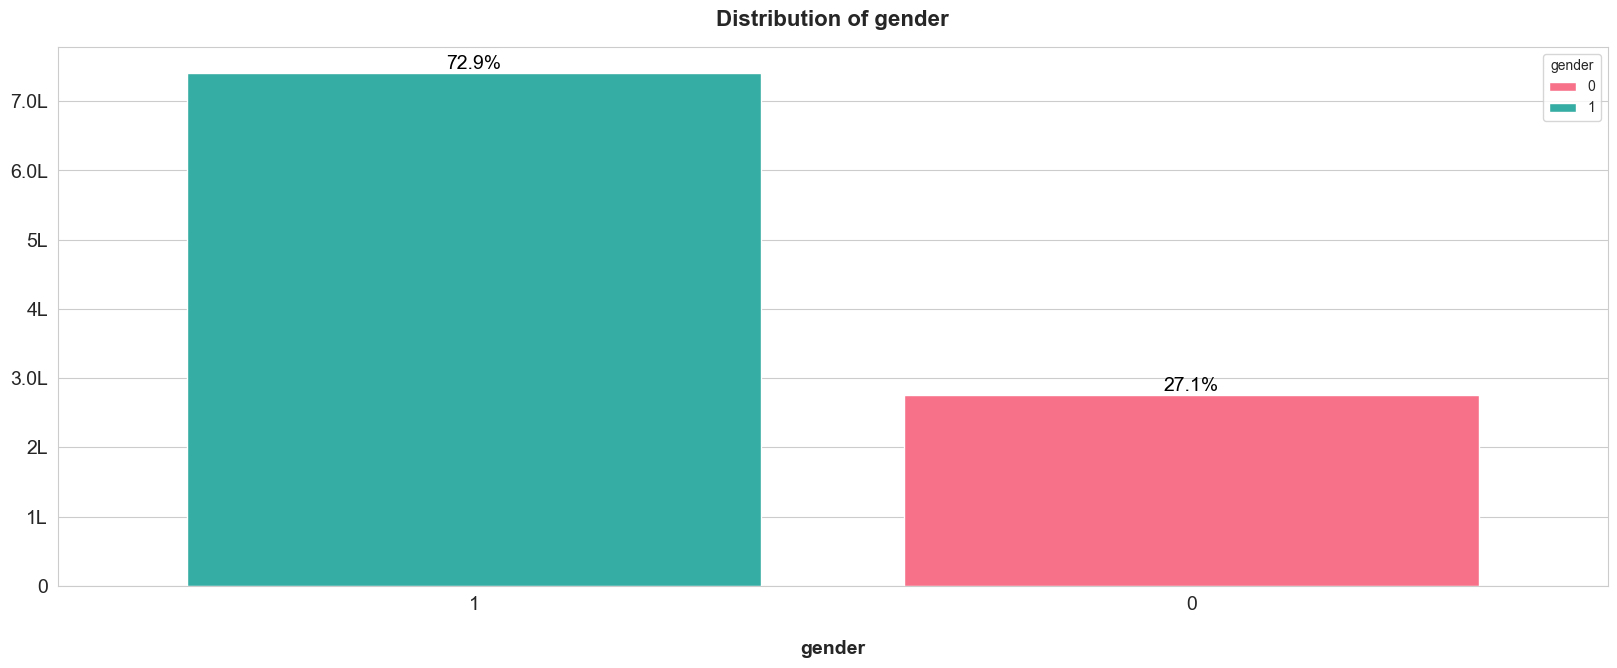

In [212]:
# Creates a count plot for the 'gender' column in the DataFrame `data_2_gender`.
count_plot(data_2_gender, 'gender')

In [213]:
try:
    # Attempt to read the pre-processed DataFrame from a Parquet file
    data_2_gender = pd.read_parquet('data_2_gender_smote.parquet')

except FileNotFoundError:
    # If the file is not found, apply SMOTE and save the result
    data_2_gender = apply_smote(data_2_gender, 'gender')
    data_2_gender.to_parquet('data_2_gender_smote.parquet', index=False)

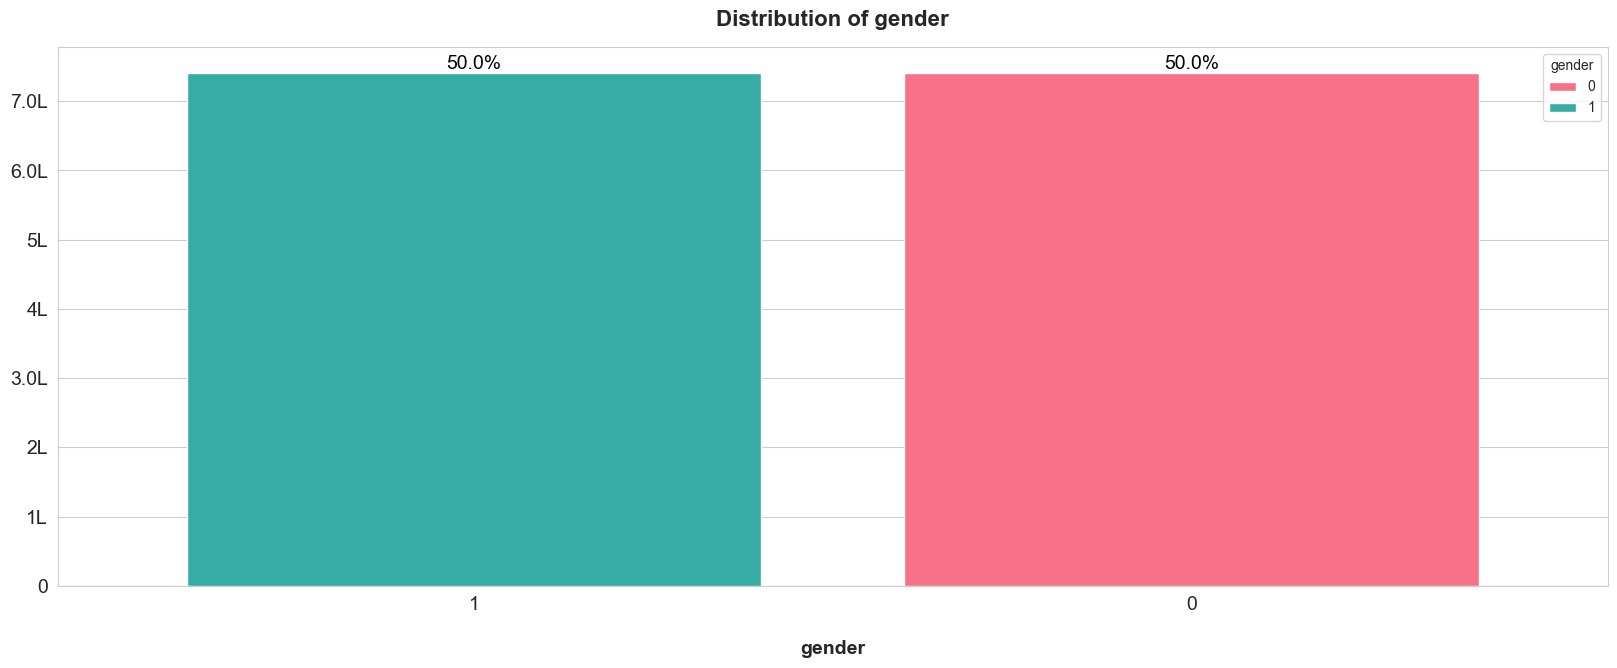

In [214]:
# Create a count plot for the 'gender' column in `data_2_gender`
count_plot(data_2_gender, 'gender')

##### Fix Age Distribution

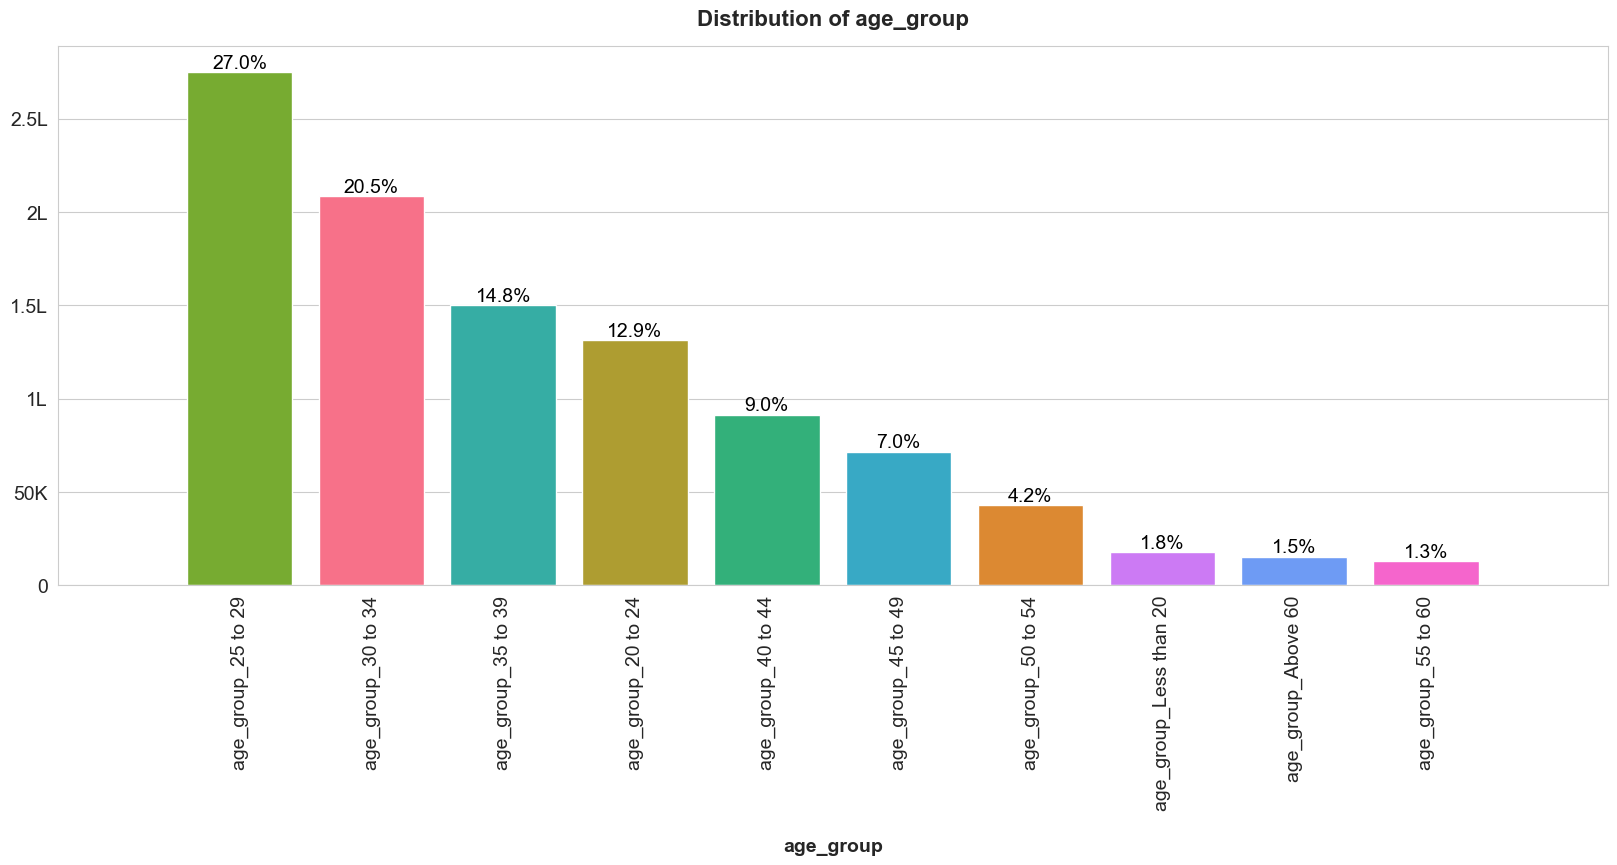

In [215]:
# Create a count plot for the 'age_group' column in `data_2_age`
count_plot(data_2_age, 'age_group', rotate_label=True)

In [216]:
# Apply SMOTE to balance the dataset based on the 'age_group' column
data_2_age = apply_smote(data_2_age, 'age_group')

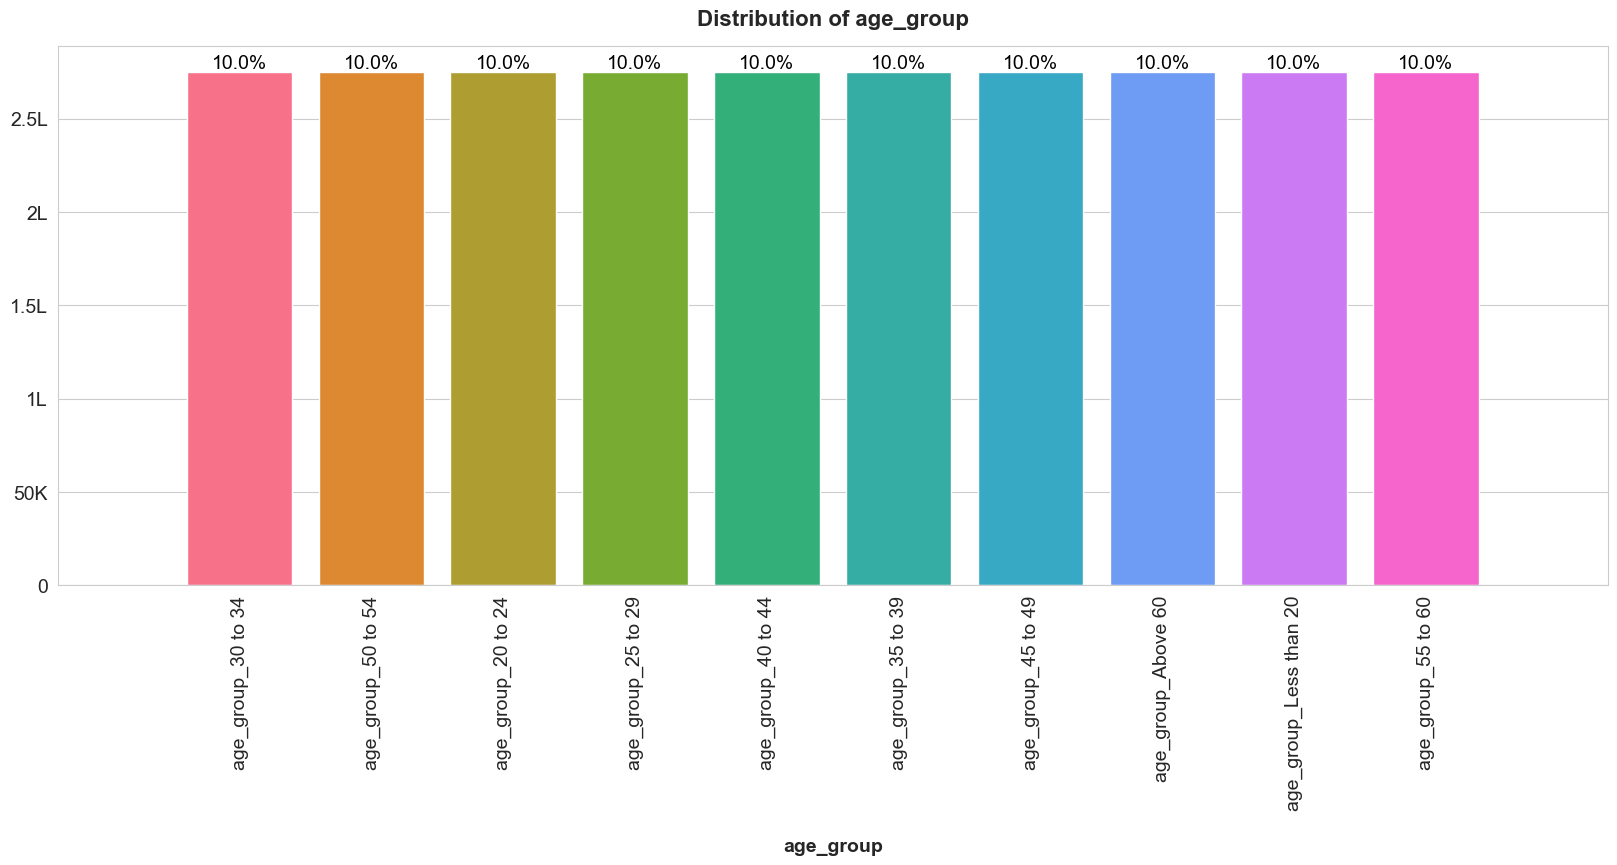

In [217]:
# Create a count plot for the 'age_group' column in `data_2_age`
count_plot(data_2_age, 'age_group', rotate_label=True)

#### Data Splitting

##### Define target variables

In [218]:
# Assigns the 'gender' column from the DataFrame `data_2_gender` to the variable `target_gender`.
target_gender = data_2_gender['gender']

# Maps each 'age_group' in the DataFrame `data_2_age` using the mapping function `map_age` and assigns the result to `target_age`.
target_age = data_2_age['age_group'].map(map_age)

##### Drop target variables from features

In [219]:
# Drops the 'gender' column from the DataFrame `data_2_gender` and assigns the result to `features_gender`.
features_gender = data_2_gender.drop(columns=['gender'])

# Drops the 'age_group' column from the DataFrame `data_2_age` and assigns the result to `features_age`.
features_age = data_2_age.drop(columns=['age_group'])

##### Check for categorical variables

In [220]:
# Selects columns of object (string) type from the DataFrame `features_gender` and lists their column names.
features_gender.select_dtypes(include=['object']).columns.tolist()

[]

In [221]:
# Selects columns of object (string) type from the DataFrame `features_age` and lists their column names.
features_age.select_dtypes(include=['object']).columns.tolist()

[]

##### Split data into training and testing sets for gender prediction

In [222]:
# Splits the `features_gender` and `target_gender` into training and testing sets with a 80-20 split and a fixed random state for reproducibility.
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(
    features_gender, target_gender, test_size=0.2, random_state=42)

##### Split data into training and testing sets for age prediction

In [223]:
# Splits the `features_age` and `target_age` into training and testing sets with a 80-20 split and a fixed random state for reproducibility.
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(
    features_age, target_age, test_size=0.2, random_state=42)

##### Perform Scaling

In [224]:
# Initializes the `StandardScaler` object for scaling numerical features.
scaler = StandardScaler()

# Fits the scaler to `X_train_gender` and transforms it, then assigns the scaled data to `X_train_gender_scaled`.
X_train_gender_scaled = scaler.fit_transform(X_train_gender)

# Transforms `X_test_gender` using the already fitted scaler, then assigns the scaled data to `X_test_gender_scaled`.
X_test_gender_scaled = scaler.transform(X_test_gender)

# Fits the scaler to `X_train_age` and transforms it, then assigns the scaled data to `X_train_age_scaled`.
X_train_age_scaled = scaler.fit_transform(X_train_age)

# Transforms `X_test_age` using the already fitted scaler, then assigns the scaled data to `X_test_age_scaled`.
X_test_age_scaled = scaler.transform(X_test_age)

#### Model Building

##### Model for Gender Prediction

In [225]:
# Initializes a `LogisticRegression` model with a maximum of 1000 iterations and a fixed random state for reproducibility.
gender_model_log = LogisticRegression(max_iter=1000, random_state=42)

# Trains the logistic regression model using the scaled training features `X_train_gender_scaled` and corresponding target labels `y_train_gender`.
gender_model_log.fit(X_train_gender_scaled, y_train_gender)

LogisticRegression(max_iter=1000, random_state=42)

In [226]:
# Initializes an `XGBClassifier` model with a fixed random state for reproducibility.
gender_model_xgb = xgb.XGBClassifier(random_state=42)

# Trains the XGBoost classifier using the scaled training features `X_train_gender_scaled` and corresponding target labels `y_train_gender`.
gender_model_xgb.fit(X_train_gender_scaled, y_train_gender)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [227]:
# Makes predictions on the scaled test features `X_test_gender_scaled` using the trained logistic regression model and assigns the predictions to `y_pred_log`.
y_pred_log = gender_model_log.predict(X_test_gender_scaled)

In [228]:
# Calculates the accuracy of the logistic regression model's predictions and assigns it to `accuracy_log`.
accuracy_log = accuracy_score(y_test_gender, y_pred_log)

# Calculates the precision of the logistic regression model's predictions and assigns it to `precision_log`.
precision_log = precision_score(y_test_gender, y_pred_log)

# Calculates the recall (sensitivity) of the logistic regression model's predictions and assigns it to `recall_log`.
recall_log = recall_score(y_test_gender, y_pred_log)

# Calculates the F1 score of the logistic regression model's predictions and assigns it to `f1_log`.
f1_log = f1_score(y_test_gender, y_pred_log)

In [229]:
# Prints the results of the logistic regression model.
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_log:.4f}")
print(f"Precision: {precision_log:.4f}")
print(f"Recall: {recall_log:.4f}")
print(f"F1 Score: {f1_log:.4f}")

Logistic Regression Results:
Accuracy: 0.5805
Precision: 0.5751
Recall: 0.6132
F1 Score: 0.5935


In [230]:
# Makes predictions on the scaled test features `X_test_gender_scaled` using the trained XGBoost model and assigns the predictions to `y_pred_xgb`.
y_pred_xgb = gender_model_xgb.predict(X_test_gender_scaled)

In [231]:
# Calculates the accuracy of the XGBoost model's predictions and assigns it to `accuracy_xgb`.
accuracy_xgb = accuracy_score(y_test_gender, y_pred_xgb)

# Calculates the precision of the XGBoost model's predictions and assigns it to `precision_xgb`.
precision_xgb = precision_score(y_test_gender, y_pred_xgb)

# Calculates the recall (sensitivity) of the XGBoost model's predictions and assigns it to `recall_xgb`.
recall_xgb = recall_score(y_test_gender, y_pred_xgb)

# Calculates the F1 score of the XGBoost model's predictions and assigns it to `f1_xgb`.
f1_xgb = f1_score(y_test_gender, y_pred_xgb)

In [232]:
# Prints the results of the XGBoost model.
print("XGBoost Results:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")

XGBoost Results:
Accuracy: 0.8180
Precision: 0.8495
Recall: 0.7724
F1 Score: 0.8091


In [233]:
# Define parameters for grid search to optimize the XGBoost model
params = {
    # Number of boosting rounds to run.
    'n_estimators': [50, 100],

    # Learning rate used to weight contribution of each tree.
    'learning_rate': [0.1, 0.05],

    # Maximum depth of the individual regression estimators.
    'max_depth': [3, 4],

    # Minimum number of observations in a node required for further partitioning.
    'min_child_weight': [1, 5]
}

In [234]:
# Perform grid search to find the best hyperparameters for the XGBoost model
grid_search = GridSearchCV(
    gender_model_xgb,                                           # The model to optimize (XGBoost model trained on gender data).
    params,                                                     # Parameters to tune.
    cv=5                                                        # Number of cross-validation folds.
)

# Fit the grid search object to the training data.
grid_search.fit(X_train_gender_scaled, y_train_gender)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [3, 4],
                         'min_child_weight': [1, 5],
                         'n_estimators': [50, 100]})

In [235]:
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)             # Display the best hyperparameters found
print("Best score:", grid_search.best_score_)                   # Display the cross-validation score for the best model

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
Best score: 0.6775751580764547


In [236]:
# Re-train the model with best parameters and re-fit it to the training data
best_gender_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=42)          # Create a new XGBoost model with the best parameters
best_gender_model.fit(X_train_gender, y_train_gender)                                       # Fit the model to the training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [237]:
# Evaluate the tuned model by making predictions on the test set and calculating various metrics
y_pred_tuned = best_gender_model.predict(X_test_gender)                                     # Predict the labels for the test set using the best model

t_accuracy = accuracy_score(y_test_gender, y_pred_tuned)                                    # Accuracy: proportion of correct predictions
t_precision = precision_score(y_test_gender, y_pred_tuned)                                  # Precision: proportion of true positives among predicted positives
t_recall = recall_score(y_test_gender, y_pred_tuned)                                        # Recall: proportion of true positives detected
t_f1 = f1_score(y_test_gender, y_pred_tuned)                                                # F1-score: harmonic mean of precision and recall

In [238]:
# Print the evaluation metrics for the tuned model
print("Tuned XGBoost Results:")
print(f"Accuracy: {t_accuracy:.4f}")                                                        # Accuracy: proportion of correct predictions
print(f"Precision: {t_precision:.4f}")                                                      # Precision: proportion of true positives among predicted positives
print(f"Recall: {t_recall:.4f}")                                                            # Recall: proportion of true positives detected
print(f"F1 Score: {t_f1:.4f}")                                                              # F1-score: harmonic mean of precision and recall

Tuned XGBoost Results:
Accuracy: 0.6770
Precision: 0.6901
Recall: 0.6411
F1 Score: 0.6647


##### Model for Age Prediction

In [239]:
# Initialize and train the RandomForestClassifier with specified parameters
age_model = RandomForestClassifier(
    n_estimators=100,                                                                       # Number of trees in the forest.
    random_state=42                                                                         # Seed for random number generation to ensure reproducibility.
)

# Fit the model to the training data
age_model.fit(X_train_age_scaled, y_train_age)

RandomForestClassifier(random_state=42)

In [240]:
# Make predictions on the test set using the trained RandomForestClassifier
y_pred_age = age_model.predict(X_test_age_scaled)

In [241]:
# Evaluate the performance of the RandomForestClassifier
print("Age Prediction Results:")
print("Accuracy:", accuracy_score(y_test_age, y_pred_age))
print(f'Precision: {precision_score(y_test_age, y_pred_age, average='weighted')}')
print(f'Recall: {recall_score(y_test_age, y_pred_age, average='weighted')}')
print(f'F1 Score: {f1_score(y_test_age, y_pred_age, average='weighted')}')
print('\n')

# Print the classification report
print(classification_report(y_test_age, y_pred_age))

Age Prediction Results:
Accuracy: 0.9598148067358869
Precision: 0.9596154382789345
Recall: 0.9598148067358869
F1 Score: 0.9596354351723937


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     55000
           1       0.94      0.95      0.94     54972
           2       0.95      0.92      0.93     55030
           3       0.94      0.91      0.92     55067
           4       0.95      0.94      0.94     54810
           5       0.95      0.96      0.95     55078
           6       0.96      0.97      0.97     54552
           7       0.97      0.98      0.97     55080
           8       0.98      1.00      0.99     55300
           9       0.98      0.99      0.98     55239

    accuracy                           0.96    550128
   macro avg       0.96      0.96      0.96    550128
weighted avg       0.96      0.96      0.96    550128



In [242]:
from sklearn.tree import DecisionTreeClassifier

In [243]:
# Define the model
# Initialize the SVC model
clf = DecisionTreeClassifier()
clf.fit(X_train_age_scaled, y_train_age)

DecisionTreeClassifier()

In [246]:
# Make predictions on the test set using the trained RandomForestClassifier
y_pred_age = clf.predict(X_test_age_scaled)

In [247]:
# Evaluate the performance of the RandomForestClassifier
print("Age Prediction Results:")
print("Accuracy:", accuracy_score(y_test_age, y_pred_age))
print(f'Precision: {precision_score(y_test_age, y_pred_age, average='weighted')}')
print(f'Recall: {recall_score(y_test_age, y_pred_age, average='weighted')}')
print(f'F1 Score: {f1_score(y_test_age, y_pred_age, average='weighted')}')
print('\n')

# Print the classification report
print(classification_report(y_test_age, y_pred_age))

Age Prediction Results:
Accuracy: 0.9661496960707326
Precision: 0.9660130999903154
Recall: 0.9661496960707326
F1 Score: 0.9660195013844917


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     55000
           1       0.95      0.96      0.96     54972
           2       0.95      0.93      0.94     55030
           3       0.95      0.92      0.94     55067
           4       0.96      0.95      0.95     54810
           5       0.96      0.96      0.96     55078
           6       0.97      0.97      0.97     54552
           7       0.97      0.98      0.98     55080
           8       0.98      1.00      0.99     55300
           9       0.98      0.99      0.99     55239

    accuracy                           0.97    550128
   macro avg       0.97      0.97      0.97    550128
weighted avg       0.97      0.97      0.97    550128



###### Grid search to optimize model hyperparameters for better performance

In [242]:
# Define parameters for grid search to optimize the XGBoost model
params = {
    # Number of boosting rounds to run.
    # 'n_estimators': [50, 100],
    'n_estimators': [50, 100, 150, 200],

    # Learning rate used to weight contribution of each tree.
    'learning_rate': [0.1, 0.05, 0.01],

    # Maximum depth of the individual regression estimators.
    'max_depth': [3, 4, 10, 20, 50, 100],

    # Minimum number of observations in a node required for further partitioning.
    'min_child_weight': [1, 5, 10, 20]
}

In [243]:
# Initializes an XGBoost classifier specifically for age prediction tasks.
age_model = xgb.XGBClassifier()

In [ ]:
# Performs a grid search to optimize the hyperparameters of the XGBoost classifier for age prediction.
grid_search_age = GridSearchCV(age_model, params, cv=5)                                     # Define and configure the grid search object
grid_search_age.fit(X_train_age, y_train_age)                                               # Fit the grid search object to the training data

In [ ]:
# Prints the best hyperparameters found by the grid search.
print("Best parameters:", grid_search_age.best_params_)

# Prints the best cross-validation score obtained by the grid search.
print("Best score:", grid_search_age.best_score_)

In [ ]:
# Re-trains the XGBoost classifier using the best hyperparameters found by the grid search.
best_age_model = xgb.XGBClassifier(**grid_search_age.best_params_)                          # Create a new model with best parameters
best_age_model.fit(X_train_age, y_train_age)                                                # Fit the model to the training data

In [ ]:
# Makes predictions on the test set using the re-trained model.
y_pred_age_tuned = best_age_model.predict(X_test_age)

# Evaluates the performance of the tuned model and prints various metrics.
print("Tuned Age Prediction Results:")
print("Accuracy:", accuracy_score(y_test_age, y_pred_age_tuned))
print(f'Precision: {precision_score(y_test_age, y_pred_age_tuned, average='weighted')}')
print(f'Recall: {recall_score(y_test_age, y_pred_age_tuned, average='weighted')}')
print(f'F1 Score: {f1_score(y_test_age, y_pred_age_tuned, average='weighted')}')
print('\n')

# Prints a detailed classification report.
print(classification_report(y_test_age, y_pred_age_tuned))

### Conclusion

Below is the summary of the evaluation metrics of the ML models,

| Scenario | Model                        | Predictor | Accuracy | Precision | Recall | F1 Score |
| -------- |------------------------------| --------- |----------|-----------|--------|----------|
| 1        | Meta (XGBoost)               | Gender    | 70.73    | 72.57     | 67.04  | 69.69    |
| 1        | Meta (XGBoost)               | Age       | 22.25    | 25.81     | 22.25  | 19.11    |
| 2        | Logistic Regression          | Gender    | 57.64    | 56.55     | 65.54  | 60.72    |
| 2        | XGBoost                      | Gender    | 82.31    | 84.83     | 78.66  | 81.63    |
| 2        | XGBoost with GridSearchCV    | Gender    | 67.97    | 70.09     | 62.56  | 66.11    |
| 2        | Random Forest Classification | Age       | 95.88    | 95.86     | 95.88  | 95.86    |
| 2        | XGBoost                      | Age       | 49.84    | 50.51     | 49.84  | 47.88    |
| 2        | Decision Trees               | Age       | 96.15    | 96.01     | 96.15  | 96.60    |

Accuracy: 0.9661496960707326
Precision: 0.9660130999903154
Recall: 0.9661496960707326
F1 Score: 0.9660195013844917

---
On the basis of above evaluation,
- **Gender prediction:** Choosing **XGBoost** as it provides the highest accuracy, precision, recall, and F1 score among all models evaluated for this task. It consistently outperforms other models like Logistic Regression and Random Forest Classification when used for gender prediction.
- **Age prediction:** Choosing **Random Forest Classification** because it achieves nearly perfect performance across all evaluation metrics (accuracy, precision, recall, and F1 score). Its superior performance suggests that it is the best model for predicting age in this scenario.

## Exporting Final Models for Web App usage

### Gender Model

In [248]:
# Creates an XGBoost pipeline that includes standard scaling of features.
xgb_pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier())

# Fits the pipeline to the training data for gender prediction.
xgb_pipe.fit(X_train_gender, y_train_gender)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [249]:
# Saves the trained XGBoost pipeline to a file for future use.
joblib.dump(xgb_pipe, 'gender.joblib')

['gender.joblib']

### Age Model

#### Random Forest

In [250]:
# Creates a Random Forest pipeline that includes standard scaling of features.
rf_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100))

# Fits the pipeline to the training data for age prediction.
rf_pipe.fit(X_train_age, y_train_age)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [251]:
# Saves the trained Random Forest pipeline to a file for future use.
joblib.dump(rf_pipe, 'age_rf.joblib')

['age.joblib']

In [252]:
# Saves the trained Random Forest pipeline to a file for future use.
joblib.dump(rf_pipe, 'age_rf_compressed.joblib', compress=9)

['age_compressed.joblib']

#### Decision Trees

In [249]:
# Creates a Random Forest pipeline that includes standard scaling of features.
dt_pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier())

# Fits the pipeline to the training data for age prediction.
dt_pipe.fit(X_train_age, y_train_age)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [250]:
# Saves the trained Decision Tree pipeline to a file for future use.
joblib.dump(dt_pipe, 'age_dt.joblib')

['age_dt.joblib']